In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from matplotlib.gridspec import GridSpec
import pickle
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import os
from matplotlib.patches import Patch


In [202]:
# LOAD CIRCUIT GEOMETRY UNIQUE

circuit_geometry = pd.read_csv('csv_output/Circuit_geometry_unique.csv')

print("Circuit Geometry Dataset")
print(f"Shape: {circuit_geometry.shape}")
print(f"Columns: {circuit_geometry.columns.tolist()}")
print(f"Unique circuits: {circuit_geometry['circuitRef'].nunique()}")


# LOAD COMBINED LAP TIMING CLEAN

lap_timing = pd.read_excel('csv_output/Combined_Lap_Timing_Final.xlsx')

print(f"\nCombined Lap Timing Final Dataset")

print(f"Shape: {lap_timing.shape}")
print(f"Columns: {lap_timing.columns.tolist()}")
print(f"Total Rows: {len(lap_timing)}")



Circuit Geometry Dataset
Shape: (24, 28)
Columns: ['circuitRef', 'year', 'round', 'name', 'type', 'num_drs_zones', 'length_km', 'num_turns', 'slow_corners', 'medium_corners', 'fast_corners', 'flat_corners', 'slow_cluster_max', 'straight_distance_m', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_spacing_std_m', 'hb_at_end_of_max', 'corner_density_tpkm', 'avg_corner_angle', 'total_corner_angle', 'avg_corner_distance', 'drs_zones_detected', 'drs_total_len_m', 'drs_on_max']
Unique circuits: 24

Combined Lap Timing Final Dataset
Shape: (73592, 27)
Columns: ['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall', 'any_violation', 'lap_clean', 'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'TyreLife', 'PitStop', 'Pit_Out']
Total Rows: 73592


<h3><center> From interval to position ahead we derive traffic feutre(dirty air/clean air) </center></h3>

In [203]:

def create_traffic_and_behavior_features(df,drs_thresh=1.1,clean_thresh=3.0,interp_limit=1):
    """
    Traffic & behavior features: gap parsing, traffic regimes,

    Returns
    -------
    DataFrame with columns:
      - is_leadern_drs_range, in_dirty_air, in_clean_air
    """
    df = df.copy()

    print(f"\nCreating traffic features(clean air, dirty air, DRS range)")

    # Sort for temporal operations
    keys = ['year', 'round', 'RacingNumber', 'Stint', 'lap_number']
    df = df.sort_values(keys)

    # Parse IntervalToPositionAhead robustly (no arbitrary values for leaders)

    s = df['IntervalToPositionAhead'].astype(str)

    # Leader flag: Position==1 OR LAPk tokens
    df['is_leader'] = ((df['Position'] == 1) | s.str.upper().str.contains(r'\bLAP\s*\d+\b')).astype(int)

    # Extract FIRST numeric token anywhere in the string; handles "1.23", "+1.23", "1,23", "1.23s", etc.
    num_str = s.str.extract(r'([-+]?\d+(?:[.,]\d*)?)', expand=False)
    num_clean = num_str.str.replace(',', '.', regex=False).str.strip()
    gap_num = pd.to_numeric(num_clean, errors='coerce')

    # Numeric gap only for non-leaders; leaders have no numeric gap
    df['gap_seconds_raw'] = np.where(df['is_leader'].values == 0, gap_num.values, np.nan)
    df['gap_numeric_valid'] = df['gap_seconds_raw'].notna().astype(int)

    # ── 3) Conservative interpolation: only isolated 1-lap holes within (year, round, driver)

    grp = df.groupby(['year', 'round', 'RacingNumber'], group_keys=False)
    df['gap_seconds_interp'] = grp['gap_seconds_raw'].apply(
        lambda x: x.interpolate(limit=interp_limit, limit_direction='both')
    )

    # Adopt interpolation only where original was NaN
    df['gap_seconds'] = df['gap_seconds_raw'].where(df['gap_seconds_raw'].notna(), df['gap_seconds_interp'])
    df['gap_missing'] = (df['gap_seconds'].isna() & (df['is_leader'] == 0)).astype(int)

    # Optional: capped numeric (useful for trees/GBMs; not required for linear+dummies)
    #df['gap_capped'] = df['gap_seconds'].clip(lower=0, upper=6)

    # 4) Traffic regime dummies (mutually exclusive physical regimes)

    df['in_drs_range'] = ((df['is_leader'] == 0) & df['gap_seconds'].notna() & (df['gap_seconds'] <= drs_thresh)).astype(int)
    df['in_dirty_air'] = ((df['is_leader'] == 0) & df['gap_seconds'].notna()
                          & (df['gap_seconds'] > drs_thresh) & (df['gap_seconds'] < clean_thresh)).astype(int)
    df['in_clean_air'] = ((df['gap_seconds'].notna() & (df['gap_seconds'] >= clean_thresh)) | (df['is_leader'] == 1)).astype(int)

    # Diagnostics
    n = len(df)
    n_leader = int(df['is_leader'].sum())
    n_nonleader = n - n_leader
    n_gap_known_nonleader = int((df['is_leader'].eq(0) & df['gap_seconds'].notna()).sum())
    n_gap_missing_nonleader = int((df['is_leader'].eq(0) & df['gap_seconds'].isna()).sum())

    
    print(f"\nFeature creation")

    print(f"Rows total: {n:,}")
    print(f"   Leaders: {n_leader:,} ({n_leader/n*100:.1f}%)")
    print(f"   Non-leaders: {n_nonleader:,} ({n_nonleader/n*100:.1f}%)")
    print(f"   Gap known (non-leaders): {n_gap_known_nonleader:,} ({(n_gap_known_nonleader/max(1,n_nonleader))*100:.1f}%)")
    print(f"   Gap missing (non-leaders): {n_gap_missing_nonleader:,} ({(n_gap_missing_nonleader/max(1,n_nonleader))*100:.1f}%)")

    # Regime counts (note: only one of DRS/dirty/clean or leader should be 1; unknown is implicit via gap_missing)
    print("\nTraffic regime distribution:")
    print(f"  in_drs_range: {int(df['in_drs_range'].sum()):,}")
    print(f"  in_dirty_air: {int(df['in_dirty_air'].sum()):,}")
    print(f"  in_clean_air (incl. leaders): {int(df['in_clean_air'].sum()):,}")

    # column to drop 
    labels_to_drop = ['gap_seconds_raw', 'gap_seconds_interp','gap_numeric_valid', 'gap_missing','gap_seconds']
    df = df.drop(columns=labels_to_drop)

    return df

# Create traffic and behavior features
lap_timing = create_traffic_and_behavior_features(lap_timing)


Creating traffic features(clean air, dirty air, DRS range)

Feature creation
Rows total: 73,592
   Leaders: 4,059 (5.5%)
   Non-leaders: 69,533 (94.5%)
   Gap known (non-leaders): 68,924 (99.1%)
   Gap missing (non-leaders): 609 (0.9%)

Traffic regime distribution:
  in_drs_range: 19,425
  in_dirty_air: 22,471
  in_clean_air (incl. leaders): 31,087


<h3><center> In 2025 at Interlagos - Sãu Paolo Grand Prix we do not have the Compound for a total of 3 stint :Driver 10, 55, 81. Looking at the race we can infer the actual compound used.</center></h3>

In [204]:

# Fixing missing Compound datas - 2025 SÃO PAULO GRAND PRIX
# 3 drivers had missing compound data in telemetry (verified from race footage):
# - Driver 81: laps 39-51 → SOFT compound
# - Driver 55: laps 41-71 → MEDIUM compound  
# - Driver 10: laps 41-71 → MEDIUM compound

# Identify rows needing fixes
sao_paulo_2025_mask = (lap_timing['year'] == 2025) & (lap_timing['Grand_Prix'] == 'São_Paulo_Grand_Prix')

# Driver 81: laps 39-51 → SOFT

driver_81_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 81) & (lap_timing['lap_number'].between(39, 51))
rows_81 = driver_81_mask.sum()
if rows_81 > 0:
    lap_timing.loc[driver_81_mask, 'Compound'] = 'SOFT'
    print(f"✓ Driver 81: Updated {rows_81} laps (39-51) → SOFT")


# Driver 55: laps 41-71 → MEDIUM
driver_55_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 55) & (lap_timing['lap_number'].between(41, 71))
rows_55 = driver_55_mask.sum()
if rows_55 > 0:
    lap_timing.loc[driver_55_mask, 'Compound'] = 'MEDIUM'
    print(f"✓ Driver 55: Updated {rows_55} laps (41-71) → MEDIUM")

# Driver 10: laps 41-71 → MEDIUM
driver_10_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 10) & (lap_timing['lap_number'].between(41, 71))
rows_10 = driver_10_mask.sum()
if rows_10 > 0:
    lap_timing.loc[driver_10_mask, 'Compound'] = 'MEDIUM'
    print(f"✓ Driver 10: Updated {rows_10} laps (41-71) → MEDIUM")

total_fixed = rows_81 + rows_55 + rows_10
print(f"\n✓ Total compound values inserted: {total_fixed} rows")



✓ Driver 81: Updated 13 laps (39-51) → SOFT
✓ Driver 55: Updated 31 laps (41-71) → MEDIUM
✓ Driver 10: Updated 31 laps (41-71) → MEDIUM

✓ Total compound values inserted: 75 rows


In [205]:
def filter_clean_racing_laps(df):
    """
    Filter the lap timing dataset to keep only clean racing laps.
    
    Removes rows where:
    - Rainfall is True (wet conditions)
    - any_violation is True (track limits, safety car, etc.)
    - lap_clean is False (outlier/invalid laps)
    - PitIn is True (lap entering pit)
    - PitOut is True (lap exiting pit)
    - LapTime is missing/NaN (removes that row AND the next row)
    - Compound is "UNKNOWN"
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The Combined Lap Timing Clean dataset
    
    Returns:
    --------
    pandas.DataFrame
        Filtered dataset with only clean racing laps
    """
    print("Filtering for clean racing laps")
    print(f"\nInitial rows: {len(df)}")
    
    # Create a copy to avoid modifying the original
    df_filtered = df.copy()
    
    # Step 1: Identify rows with missing LapTime and mark them + next row for removal
    missing_laptime_mask = df_filtered['LapTime'].isna()
    rows_to_remove = missing_laptime_mask.copy()
    
    # Mark the row AFTER each missing LapTime for removal (x+1)
    missing_indices = df_filtered[missing_laptime_mask].index
    for idx in missing_indices:
        # Find the position of this index in the dataframe
        pos = df_filtered.index.get_loc(idx)
        # If there's a next row, mark it for removal
        if pos + 1 < len(df_filtered):
            next_idx = df_filtered.index[pos + 1]
            rows_to_remove.loc[next_idx] = True
    
    print(f"\nRows with missing LapTime: {missing_laptime_mask.sum()}")
    print(f"Total rows to remove (missing + next): {rows_to_remove.sum()}")
    
    # Step 2: Apply all filters - keep rows where all conditions are "clean"
    df_filtered = df_filtered[~rows_to_remove]  # Remove rows with missing LapTime and their next row
    
    initial_after_laptime = len(df_filtered)
    
    # Step 3: Track removals for each filter condition (before applying filters)
    print(f"\n{'='*80}")
    print("BREAKDOWN OF ROWS REMOVED BY EACH FILTER:")
    print(f"{'='*80}")
    
    rows_rainfall = (df_filtered['Rainfall'] == True).sum()
    rows_any_violation = (df_filtered['any_violation'] == True).sum()
    rows_lap_clean_false = (df_filtered['lap_clean'] == False).sum()
    rows_pitstop = (df_filtered['PitStop'] == True).sum()
    rows_pitout = (df_filtered['Pit_Out'] == True).sum()
    rows_unknown = (df_filtered['Compound'] == 'UNKNOWN').sum()
    rows_intermediate = (df_filtered['Compound'] == 'INTERMEDIATE').sum()
    rows_wet = (df_filtered['Compound'] == 'WET').sum()
    
    print(f"  Rainfall == True: {rows_rainfall:,} ({rows_rainfall/initial_after_laptime*100:.2f}%)")
    print(f"  any_violation == True: {rows_any_violation:,} ({rows_any_violation/initial_after_laptime*100:.2f}%)")
    print(f"  lap_clean == False: {rows_lap_clean_false:,} ({rows_lap_clean_false/initial_after_laptime*100:.2f}%)")
    print(f"  PitStop == True: {rows_pitstop:,} ({rows_pitstop/initial_after_laptime*100:.2f}%)")
    print(f"  Pit_Out == True: {rows_pitout:,} ({rows_pitout/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'UNKNOWN': {rows_unknown:,} ({rows_unknown/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'INTERMEDIATE': {rows_intermediate:,} ({rows_intermediate/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'WET': {rows_wet:,} ({rows_wet/initial_after_laptime*100:.2f}%)")
    
    # Note: Some rows may match multiple conditions, so total unique removals may be less than sum
    print(f"\nNote: Some rows may match multiple conditions (overlap)")
    
    # Step 4: Apply all filters
    df_filtered = df_filtered[
        (df_filtered['Rainfall'] != True) &            # No rain
        (df_filtered['any_violation'] != True) &       # No violations => Track Limits and off track control
        (df_filtered['lap_clean'] == True) &           # Lap is clean  group => blue flag, Safety-Car/ VSC deployed-end, yellow and double yellow flag and red flag.  
        (df_filtered['PitStop'] != True) &             # Not in pit stop
        (df_filtered['Pit_Out'] != True) &             # No pit out laps
        (df_filtered['Compound'] != 'UNKNOWN') &       # No unknown compound
        (df_filtered['Compound'] != 'INTERMEDIATE') &  # No intermediate compound
        (df_filtered['Compound'] != 'WET')             # No wet compound
    ]
    
    print(f"\n{'='*80}")
    print(f"FINAL RESULTS:")
    print(f"{'='*80}")
    print(f"Rows after missing LapTime removal: {initial_after_laptime:,}")
    print(f"Rows after all filtering: {len(df_filtered):,}")
    print(f"Total rows removed by all filters: {initial_after_laptime - len(df_filtered):,} ({100 * (initial_after_laptime - len(df_filtered)) / initial_after_laptime:.2f}%)")
    print(f"Total rows removed from initial: {len(df) - len(df_filtered):,} ({100 * (len(df) - len(df_filtered)) / len(df):.2f}%)")
    
    return df_filtered

# Apply the filter to get clean racing laps
lap_timing_clean = filter_clean_racing_laps(lap_timing)

print("\nClean first filtered Dataset")
print(f"Shape: {lap_timing_clean.shape}")

lap_timing_clean.to_excel('csv_output/Filtered_01_dataset.xlsx', index=False)


Filtering for clean racing laps

Initial rows: 73592

Rows with missing LapTime: 2187
Total rows to remove (missing + next): 3788

BREAKDOWN OF ROWS REMOVED BY EACH FILTER:
  Rainfall == True: 2,164 (3.10%)
  any_violation == True: 610 (0.87%)
  lap_clean == False: 12,690 (18.18%)
  PitStop == True: 2,066 (2.96%)
  Pit_Out == True: 1,984 (2.84%)
  Compound == 'UNKNOWN': 0 (0.00%)
  Compound == 'INTERMEDIATE': 3,500 (5.01%)
  Compound == 'WET': 70 (0.10%)

Note: Some rows may match multiple conditions (overlap)

FINAL RESULTS:
Rows after missing LapTime removal: 69,804
Rows after all filtering: 50,655
Total rows removed by all filters: 19,149 (27.43%)
Total rows removed from initial: 22,937 (31.17%)

Clean first filtered Dataset
Shape: (50655, 31)


<h1><center> Now we will further filter the dataset : </center></h1>



- In 2023 , the API failed to identify pit stop for the first 6 races(from Bahrain to Monaco), so Pit stop datas are taken from F1 official web page. The pit in and out lap are excluded. ( https://www.formula1.com/en/results/2023/races/1141/bahrain/pit-stop-summary)

- Even though we filter for safety, VSC , any violation (track limit and off track), outliers still are present. So manually we will remove for races from 2023 to 2025 accident, puncture ecc( event not related with pure tyre degradation). Below the reader can find year by year the main events from 2023 to 2025

- If a certain race has a Safety Car or a VSC, from lap 4 to 7(7 is the lap with the green flag), we will remove also lap 8. Why ? green flag is given at the end of the lap(7),hence lap 8 on average is 1.5 seconds slower then the following lap due to the slow speed before main straight.  

<h1><center> Race analysis </center></h1>




---
<h1><center> 2023 </center></h1>

---


### Bahrain Grand Prix 
- Lap 37: Hamilton–Alonso contact  
- Lap 41: Leclerc mechanical failure  
- Laps 41–42: VSC + yellow flag  

### Saudi Arabian Grand Prix 
- Lap 18: Stroll out  
- Lap 18: Safety car deployed  
- Lap 20: Safety car in → first green lap: 21  
- Lap 26: Albon brake failure (remained on track until lap 27)  

### Australian Grand Prix 
- Lap 1: Yellow flag (Leclerc out)
- Lap 3: Safety car until end of lap 3  
- Lap 7: Albon off-track → yellow  
- Lap 8: Red flag  
- Lap 10: Restart  
- Lap 18: Russell mechanical failure (continued to pits)  
- Lap 47: Verstappen off-track  
- Lap 53: Yellow flag  
- Lap 53: Magnussen crash  
- Lap 55: Red flag  
- Lap 57: Restart (finish lap 58)

### Azerbaijan Grand Prix
- Lap 10: De Vries out → yellow (laps 10–11)  
- Safety car until end lap 13 → first green lap: 14  
- Lap 16: Stroll hit wall  
- Lap 34: Pérez hit wall  

### Monaco Grand Prix
- Lap 11: Sainz contact  
- Lap 11: Pérez–Stroll contact  
- Lap 51: Rain → multiple offs, yellow flags, safety periods  

### Canadian Grand Prix
- Lap 2: Magnussen off-track  
- Lap 7: Sargeant out 
- Lap 8: VSC   
- Lap 12: Russell hit barrier → yellow → safety car  
- Lap 16: Safety car in → first green lap: 17  
- Lap 35: Magnussen–Tsunoda collision (both out)  
- Lap 55: Russell retired  

### Austrian Grand Prix
- Lap 13: Yellow + VSC  
- Lap 16: VSC ending → first green lap: 17  

### British Grand Prix
- Lap 4: Gasly–Stroll collision  
- Lap 32: Safety car deployed (Magnussen stopped)  
- Lap 38: Safety car in → first green lap: 39  

### Singapore Grand Prix
- Lap 1: Tsunoda out  
- Lap 19: Sargeant crash → Safety car until lap 23  
- Lap 23: Safety car in → first green lap: 24  
- Lap 36: Car(10)-Car(20), contact forcing another driver off track 
- Lap 43: Ocon stopped → VSC  
- Lap 45: VSC ending → first green lap: 46  
- Last lap: Russell crash → yellow  

### Qatar Grand Prix
- Lap 1: Hamilton–Russell collision → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 33: Alonso off-track  
- Laps 39–40: Sargeant retired (illness) → remove laps 39–40  

### United States Grand Prix
- Lap 7: Piastri–Ocon collision → Ocon out  
- Lap 10: Piastri retired  

### Mexico City Grand Prix
- Lap 1: Leclerc–Pérez collision → Pérez out  
- Lap 5: VSC deployed
- Lap 8: Yellow  
- Lap 33: Magnussen crash → safety → red flag  
- Restart on lap 36 → remove lap 36  
- Lap 48–49: Piastri–Tsunoda repeated contact 
- Lap 66: Stroll(18)contact, spin around causing yellow flag
- Lap 67: Yellow  

### São Paulo Grand Prix
- Formation lap: Leclerc out  
- Lap 1: Major crash → red flag  
- Restart on lap 4  
- Russel(63) retire the car on lap 59, so big delta on lap 57 is due to failure.

### Las Vegas Grand Prix
- Laps 1–6: Safety car cycles → remove laps 1–6  
- Lap 17: Piastri puncture → remove lap 17  
- Lap 25: Russell–Verstappen collision → Safety car until lap 28 → first green lap: 29  

---

 <h1><center> 2024 </center></h1>

---


### Australian Grand Prix
- Lap 4: Verstappen mechanical failure → out  
- Lap 17: Hamilton engine failure  
- Lap 17: VSC → ended lap 18 → first green lap: 19  
- Lap 58: Russell crash → yellow → red flag  

### Chinese Grand Prix
- Lap 21: Bottas out → VSC until lap 23  
- Lap 23: Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 27: Stroll–Ricciardo collision → Tsunoda out → remove lap 27  
- Lap 35: Stroll aggressive battling  

### Miami Grand Prix
- Lap 23: VSC deployed
- Lap 28: Sargeant–Magnussen collision → both out  
- Lap 28: Safety car deployed  
- Lap 32: Safety car in → first green lap: 33  

### Canadian Grand Prix
- Very wet conditions  
- Lap 25: Yellow → Safety car  
- Lap 29: Safety car in → first green lap: 30  
- Lap 52: Yellow  
- Lap 54: Sainz–Albon collision → Safety car  
- Lap 58: Safety car in → first green lap: 59  
- Lap 63: Russell off-track  
- Lap 66: Tsunoda spin → yellow  

### Austrian Grand_Prix 
- Lap 64: accident between Verstappen(1)- Norris(4), both puncture
- Lap 66 VSC

### Singapore Grand Prix
- Lap 15: Albon mechanical issue → retired  
- Lap 29: Norris hit barrier (continued) 
- Magnussen(20) retired on lap 57 

### Azerbaijan Grand Prix 
- Lap 1: Stroll(18) puncture 
- Lap 50: Perez(11), Sainz(55) contact , VSC

### United States Grand Prix
- Lap 1: Ocon spin  
- Lap 3: Hamilton out → Safety car  
- Lap 5: Safety car in → first green lap: 6  
- Lap 10: Zhou spin  

### Mexico City Grand Prix
- Lap 1: Albon–Tsunoda collision → Safety car  
- Lap 6: Safety car in → first green lap: 7  
- Lap 10: Verstappen–Norris off-track  
- Lap 16: Alonso retired  
- Lap 18: Pérez–Lawson contact  
- Lap 19: Pérez–Stroll contact  

### Qatar Grand Prix
- Lap 1: Ocon–Hülkenberg–Colapinto collision → yellow → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 5: Lawson–Bottas contact → yellow  
- Lap 30: Debris (mirror lost)  
- Lap 34: Hamilton puncture  
- Lap 35: Sainz puncture → Safety car  
- Lap 39: Safety car in → first green lap: 40  
- Lap 39: Second safety car  
- Lap 42: Safety car in → first green lap: 43  

### Abu Dhabi Grand Prix
- Lap 1: Piastri–Verstappen contact  
- Lap 1: Pérez spin  
- Lap 2: VSC  
- Lap 3: VSC ending → first green lap: 4  
- Lap 30: Yellow  
- Lap 31: Bottas puncture  
- Lap 31: Magnussen spin  

---

<h1><center> 2025 </center></h1>

---


### Australian Grand Prix
- Wet race → removed  

### Bahrain Grand Prix
- Lap 32: Safety car deployed  
- Lap 35: Safety car in → first green lap: 36  

### Miami Grand_Prix
- Lap 1: Accident for Doohan
- Lap 2: Safety can deployed
- Lap 3: Safety car in → first green lap:4
- Lap 10: Alonso(14) spin around 
- Lap 28: Bearman(87) failure, VSC deployed
- Lap 30: VSC ending 
- Lap 33-34: VSC



### Emilia Romagna Grand Prix
- Lap 3: Gasly off-track  
- Lap 29: Ocon engine failure → stopped on track  
- Lap 31: VSC deployed  
- Lap 32: VSC ending → first green lap: 33  
- Lap 46: Antonelli engine failure → stopped on track  
- Lap 46: Safety car deployed  
- Lap 53: Safety car in → first green lap: 54  

### Monaco Grand Prix
- Lap 1: VSC deployed  
- Lap 5: VSC ending → first green lap: 5  
- Laps 8–9: Gasly no tyre → yellow  
- Lap 38: Alonso out → yellow  

### Spanish Grand Prix
- Lap 29: Albon retired  
- Lap 31: Lawson–Bearman collision  
- Lap 55: Antonelli out → yellow  
- Lap 55: Safety car deployed  
- Lap 60: Safety car in → first green lap: 61  

### Austrian Grand Prix
- Lap 1: Safety car deployed  
- Lap 3: Safety car in → first green lap: 4  
- Lap 31: Colapinto–Tsunoda contact → Colapinto spin (continued)  

### Belgian_Grand_Prix
- Very wet , track dry out , on lap 15 everybody has medium 

### Dutch Grand Prix
- Lap 23: Hamilton out → Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 31: VSC  
- Lap 32: VSC ending  
- Lap 53: Safety car deployed  
- Lap 57: Safety car in → first green lap: 58  
- Lap 65: Yellow → Norris out → Safety car deployed  
- Lap 68: Safety car in → first green lap: 69  

### Italian Grand Prix
- Lap 24: Alonso car failure  
- Lap 41: contact between Sain(55) and Bearman(87), spin around and they keep going 


### Singapore Grand Prix
- Lap 61: Hamilton car failure  

### Azerbaijan Grand Prix
- Lap 1: Piastri(81) out, yellow flag
- Lap 1: Safety Car deployed
- Lap 4: Safety in this lap
- Lap 6: Hadjar(6), complain about engine failure
- Lap 17: Albon(23) Colapinto(43) contact, yellow 

### Singapore Grand Prix

- Lap 27: Hadjar(6), engine issue 
- Lap 43: debries on track 
- Lap 45: Hulkenberg spin around 

### Austin Grand Prix 
- Lap 1: Albon(23) Bortoleto(5) contact 
- Lap 7: VSC , Sainz(55) hit Antonelli(12)  
- Lap 8: VSC in this lap 
- Lap 35: Bearman(87) spin around 

### Mexico City Grand Prix 
- Lap 3: Yellow 
- Lap 6: Hamilton(44) Vertappen(1) contact 
- Lap 70: VSC

### São Paolo Grand Prix 
- Lap 1: Double yellow that becomes Safety Car
- Lap 6: Safety Car in this lap
- Lap 7: on restart Leclerc out 
- Lap 7: VSC
- Lap 8: VSC ending 

### Las Vegas Grand Prix 
- Lap 1: Yellow that becomes VSC
- Lap 4: VSC ending  
- Lap 14: Hamilton(44) Albon(23) contact, VSC
- Lap 16: VSC ending 

### Qatar Grand Prix 
- Lap 7: Hulckemberg(27) out, Safety car deployed
- Lap 10: Safety car in this lap  

The following cell filter out this event that the flags may have missed in order to have the cleanest possible dataset 

In [206]:

def norm_gp(s: str) -> str:
    """Normalize Grand_Prix label: lowercase, strip, remove accents, unify underscores/spaces."""
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.replace("_", " ").lower().strip()
    s = " ".join(s.split())
    return s

def expand_laps(spec):
    """
    Accepted specs:
      int -> {int}
      (a,b) -> inclusive range
      ("upto", n) -> {1..n}
      ("from", n) -> marker ('from', n)
    Returns: (set(int), from_start or None)
    """
    laps = set()
    from_start = None
    if isinstance(spec, int):
        laps.add(spec)
    elif isinstance(spec, tuple) and len(spec) == 2:
        a, b = spec
        if isinstance(a, int) and isinstance(b, int):
            lo, hi = sorted((a, b))
            laps |= set(range(lo, hi + 1))
        elif a == "upto":
            laps |= set(range(1, int(b) + 1))
        elif a == "from":
            from_start = int(b)
        else:
            raise ValueError(f"Bad lap spec: {spec}")
    else:
        raise ValueError(f"Bad lap spec: {spec}")
    return laps, from_start

def add_rule(year_rules, gp, laps, numbers=None):
    year_rules.append({"gp": gp, "laps": laps, "numbers": None if numbers is None else list(numbers)})

# load input 

in_path = Path("csv_output/Filtered_01_dataset.xlsx")
df = pd.read_excel(in_path)

required = {"year","Grand_Prix","RacingNumber","lap_number"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in input: {missing}")

df["_gp_key"] = df["Grand_Prix"].map(norm_gp)
df["RacingNumber"] = pd.to_numeric(df["RacingNumber"], errors="coerce").astype("Int64")

# RULES

# 2023

RULES_2023 = []
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (36,37)], [1])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31), (40,41)], [2])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (27,28), (37,38),(40), (47,48), (54,55)], [4])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(9,10), (25,26), (40,41)], [10])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (34,35)], [11])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (34,35)], [14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (33,34)], [16])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (30,31)], [18])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (29,30), (40,41)], [20])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (27,28)], [21])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [22])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [23])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (32,33), (54,55)], [24])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12),(26,27),(40,41)], [27])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (15,16), (32,33)], [31])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31)], [44])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [55])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [63])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (29,30)], [77])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [37], [44,14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(41,44)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,21)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(26,27)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [1])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(12,19)], [2])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(2,3), (19,20)], [4])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,15)], [10])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [11])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,19)], [14])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [16])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(13,14)], [18])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(8,9)], [20])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [21])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [22])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12), (18,19)], [24])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12)], [27])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [31])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [44])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(15,16)], [55])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [63])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(9,10), (17,18)], [77])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(1,2)], [81])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,11)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(18)], None)   # russel failure , yellow flag lap 
add_rule(RULES_2023, "Australian_Grand_Prix", [18], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [47], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(53,58)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (2,3), (8,9), (36,37),(54,55), (55,56)], [2])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [4])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9),(55,56)], [10])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (57,58)], [11])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56)], [14])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [18])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [20])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (45,46), (54,55), (55,56)], [21])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55),(55,56)], [22])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [24])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [27])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (55,56)], [31])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [44])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (57,58)], [55])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (54,55), (55,56)], [77])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [81])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,14)], None)
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [16], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [34], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [1])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [2])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [4])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(5,6), (23,24)], [10])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [14])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [16])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [20])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [22])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(7,8)], [23])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [24])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(50,51)], [31])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [44])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [55])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12), (49,50)], [63])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(6,7),(12,13)], [77])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [81])
add_rule(RULES_2023, "Miami_Grand_Prix", [(45,46)], [1])
add_rule(RULES_2023, "Miami_Grand_Prix", [(2,3)], [2])
add_rule(RULES_2023, "Miami_Grand_Prix", [(4,5)], [4])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [10])
add_rule(RULES_2023, "Miami_Grand_Prix", [(20,21)], [11])
add_rule(RULES_2023, "Miami_Grand_Prix", [(24,25)], [14])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [16])
add_rule(RULES_2023, "Miami_Grand_Prix", [(42,43)], [18])
add_rule(RULES_2023, "Miami_Grand_Prix", [(14,15)], [20])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [21])
add_rule(RULES_2023, "Miami_Grand_Prix", [(36,37)], [22])
add_rule(RULES_2023, "Miami_Grand_Prix", [(22,23)], [23])
add_rule(RULES_2023, "Miami_Grand_Prix", [(31,32)], [24])
add_rule(RULES_2023, "Miami_Grand_Prix", [(33,34)], [27])
add_rule(RULES_2023, "Miami_Grand_Prix", [(39,40)], [31])
add_rule(RULES_2023, "Miami_Grand_Prix", [(37,38)], [44])
add_rule(RULES_2023, "Miami_Grand_Prix", [(18,19)], [55])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [63])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16), (17,18)], [77])
add_rule(RULES_2023, "Miami_Grand_Prix", [(5,6)], [81])
add_rule(RULES_2023, "Monaco_Grand_Prix", [11], [55,11,18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [("from", 51)], None)
add_rule(RULES_2023, "Monaco_Grand_Prix", [(55,56)], [1])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(20,21),(23,24), (52,53)], [2])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(50,51)], [4])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(47,48), (54,55)], [10])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (34,35),(53,54), (57,58), (70,71)], [11])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55), (55,56)], [14])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(44,45), (55,56)], [16])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(56,57)], [20])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [21])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [22])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(18,19), (52,53)], [23])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (52,53)], [24])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (59,60)], [27])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(32,33), (54,55)], [31])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(31,32), (54,55)], [44])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(33,34), (55,56)], [55])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [63])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [77])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [81])
add_rule(RULES_2023, "Canadian_Grand_Prix", [2], [20])
add_rule(RULES_2023, "Canadian_Grand_Prix", [7], [2])
add_rule(RULES_2023, "Canadian_Grand_Prix", [(7,9)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [(12,17)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [35], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [55], [63])
add_rule(RULES_2023, "Austrian_Grand_Prix", [(13,17)], None)
add_rule(RULES_2023, "British_Grand_Prix", [(32,39)], None)
add_rule(RULES_2023, "British_Grand_Prix", [4], [10,18])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(19,24)], None)
add_rule(RULES_2023, "Singapore_Grand_Prix", [36], [11,20])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(43,46)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [(1,5)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [33], [14])
add_rule(RULES_2023, "Qatar_Grand_Prix", [(39,40)], [2])
add_rule(RULES_2023, "United_States_Grand_Prix", [7], [31,81])
add_rule(RULES_2023, "United_States_Grand_Prix", [(8,10)], [81])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [1], [16,11])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [5], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [8], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [66], [18])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(33,37)], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(48,49)], [81,22])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [67], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(57)],[63]) # russel mechanical issue
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [("upto", 6)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [17], [81])
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(25,29)], None)


# 2024

RULES_2024 = []
add_rule(RULES_2024, "Australian_Grand_Prix", [4], [1])
add_rule(RULES_2024, "Australian_Grand_Prix", [17], [44])
add_rule(RULES_2024, "Australian_Grand_Prix", [(17,19)], None)
add_rule(RULES_2024, "Australian_Grand_Prix", [(57,58)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [(21,27)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [27], [18,3,22])
add_rule(RULES_2024, "Chinese_Grand_Prix", [35], [18])
add_rule(RULES_2024, "Miami_Grand_Prix", [23], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [31], None)
add_rule(RULES_2024, "Miami_Grand_Prix", [(28,33)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(25,30)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [52], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(54,59)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [63], [63])
add_rule(RULES_2024, "Canadian_Grand_Prix", [66], None)
add_rule(RULES_2024, "Singapore_Grand_Prix", [15], [23])  # Albon mechanical issue
add_rule(RULES_2024, "Singapore_Grand_Prix", [29], [4])
add_rule(RULES_2024, "Singapore_Grand_Prix", [57], [20])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(65,67)], None)
add_rule(RULES_2024, "Austrian_Grand_Prix", [64], [1])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(64)], [4])
add_rule(RULES_2024, "Azerbaijan_Grand_Prix", [(49,52)], None) # accident lap on first turn of lap 50, influence lap 49 for some cars
add_rule(RULES_2024, "United_States_Grand_Prix", [1], [31])
add_rule(RULES_2024, "United_States_Grand_Prix", [(3,6)], None)
add_rule(RULES_2024, "United_States_Grand_Prix", [10], [24])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [(1,7)], None)
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [10], [1,4])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [16], [14])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [18], [11,30])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [19], [11,18])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(1,5)], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [5], [30,77])
add_rule(RULES_2024, "Qatar_Grand_Prix", [30], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [34], [44])
add_rule(RULES_2024, "Qatar_Grand_Prix", [35], [55])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(35,43)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [(1,3)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [30], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [31], [77,20])


# 2025

RULES_2025 = []
add_rule(RULES_2025, "Australian_Grand_Prix", [("from", 1)], None)
add_rule(RULES_2025, "Bahrain_Grand_Prix", [(32,36)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [3], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [29], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(31,33)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [46], [12])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(45,54)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(1,3)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [10], [14])
add_rule(RULES_2025, "Miami_Grand_Prix", [(28,31)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(33,35)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(1,6)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(8,9)], [10])
add_rule(RULES_2025, "Monaco_Grand_Prix", [38], None)
add_rule(RULES_2025, "Spanish_Grand_Prix", [29], [23])
add_rule(RULES_2025, "Spanish_Grand_Prix", [31], [30,87])
add_rule(RULES_2025, "Spanish_Grand_Prix", [(54,61)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [(1,4)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [31], [43,22])
add_rule(RULES_2025, "Belgian_Grand_Prix", [(1,15)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [23], [44])
add_rule(RULES_2025, "Dutch_Grand_Prix", [(23,27)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(31,33)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(53,58)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(65,69)], None)
add_rule(RULES_2025, "Italian_Grand_Prix", [24], [14])
add_rule(RULES_2025, "Italian_Grand_Prix", [41], [55,87])
add_rule(RULES_2025, "Singapore_Grand_Prix", [61], [44])
add_rule(RULES_2025, "Azerbaijan_Grand_Prix", [(1,5)], None)
add_rule(RULES_2025, "Azerbaijan_Grand_Prix", [17], None)
add_rule(RULES_2025, "Singapore_Grand_Prix", [45], [27])
add_rule(RULES_2025, "United_States_Grand_Prix", [1], [23,5])
add_rule(RULES_2025, "United_States_Grand_Prix", [(7,9)], None)
add_rule(RULES_2025, "United_States_Grand_Prix", [35], [87])
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [3], None)
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [6], [44,1])
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [(70,71)], None)
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(1,9)], None)
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(38,39)], [55 ,81])
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(39,40)],[10])
add_rule(RULES_2025, "Las_Vegas_Grand_Prix", [(1,5)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(14,17)], None)
add_rule(RULES_2025, "Qatar_Grand_Prix", [(7,11)], None)

# Bundle by year

RULES_BY_YEAR = {
    2023: RULES_2023,
    2024: RULES_2024,
    2025: RULES_2025,
}

# Apply all years

to_drop = pd.Series(False, index=df.index)

for yr, rules in RULES_BY_YEAR.items():
    df_y = df[df["year"] == yr]
    if df_y.empty:
        continue

    race_max = (
        df_y.groupby(["_gp_key"])["lap_number"]
            .max().rename("max_lap").reset_index()
    )

    for r in rules:
        gp_key = norm_gp(r["gp"])
        subset = df_y[df_y["_gp_key"] == gp_key]
        if subset.empty:
            continue

        mx = race_max[race_max["_gp_key"] == gp_key]
        max_lap = int(mx["max_lap"].iloc[0]) if not mx.empty else int(subset["lap_number"].max())

        lap_mask = pd.Series(False, index=subset.index)
        for spec in r["laps"]:
            laps_set, from_start = expand_laps(spec)
            if from_start is not None:
                laps_set |= set(range(from_start, max_lap + 1))
            lap_mask |= subset["lap_number"].isin(laps_set)

        if r["numbers"] is None:
            idx = subset[lap_mask].index
        else:
            idx = subset[lap_mask & subset["RacingNumber"].isin(r["numbers"])].index

        to_drop.loc[idx] = True


# Add blanket first lap exclusion for all races
first_lap_mask = df["lap_number"] == 1
to_drop.loc[first_lap_mask] = True

df["manual_exclude"] = to_drop
df["exclude_reason"] = np.where(df["manual_exclude"], "manual_incident", "")

kept = df.loc[~df["manual_exclude"]].drop(columns=["_gp_key"])
removed = df.loc[df["manual_exclude"]].drop(columns=["_gp_key"])

# Save
out_dir = Path("csv_output")
out_dir.mkdir(parents=True, exist_ok=True)
kept.to_excel(out_dir / "Filtered_02_manual_clean.xlsx", index=False)
removed.to_excel(out_dir / "Filtered_02_manual_removed.xlsx", index=False)

print(f"Removed: {len(removed):,} laps")
print(f"Kept: {len(kept):,} laps")
print(f"✓ Saved: csv_output/Filtered_02_manual_clean.xlsx")
print(f"✓ Saved: csv_output/Filtered_02_manual_removed.xlsx")


Removed: 2,403 laps
Kept: 48,252 laps
✓ Saved: csv_output/Filtered_02_manual_clean.xlsx
✓ Saved: csv_output/Filtered_02_manual_removed.xlsx


In [207]:
def compute_stint_metrics(df):
    """
    Compute stint length and relative progress based on physical lap progression.
    
    This function calculates:
    - stint_length: Maximum physical LapInStint reached in each stint (true tyre age)
    - rel_stint_progress: Relative position in stint (LapInStint / stint_length)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Filtered lap timing dataset with columns: year, round, RacingNumber, 
        Stint, LapInStint
    
    Returns:
    --------
    pandas.DataFrame
        Input dataframe with added columns: stint_length, rel_stint_progress
    """
    # Copy to avoid modifying original
    df = df.copy()
    
    # Sort by year, round, driver, stint, and physical lap order
    df = df.sort_values(["year", "round", "RacingNumber", "Stint", "LapInStint"]).copy()
    
    # Compute total PHYSICAL laps in each stint (max LapInStint reached)
    # This preserves the true tyre age even if some laps were filtered out
    df["stint_length"] = df.groupby(["year", "round", "RacingNumber", "Stint"])["LapInStint"].transform("max")
    
    # Relative progress through the stint (0 to 1)
    df["rel_stint_progress"] = df["LapInStint"] / df["stint_length"]
    
    return df

#Load the manually cleaned dataset for delta computation
print("Loading Filtered_02_manual_clean.xlsx")
lap_timing_manual_clean = pd.read_excel('csv_output/Filtered_02_manual_clean.xlsx')

# Apply stint metrics computation
df = compute_stint_metrics(lap_timing_manual_clean)


def build_laptime_prediction_features(g):
    """
    Build prediction features for LapTime_{t+1} (next lap time).
    
    Creates:
    - TARGET: LapTime_next_normalized = (LapTime_{t+1} - race_median) / race_median * 100 (%)
    - REFERENCE: race_median (for denormalization after prediction)
    - TEMPORAL: laptime_rolling_std_3, laptime_change_prev, laptime_cumulative_trend
    
    Filters to valid consecutive lap pairs (no anomalies like SC/VSC).
    """
    g = g.sort_values(["Stint", "LapInStint"]).copy()
    
    
    # TARGET: Next lap time 
  
    g["LapTime_next"] = g.groupby("Stint")["LapTime"].shift(-1)
    g["LapInStint_next"] = g.groupby("Stint")["LapInStint"].shift(-1)
    
    # Check if next lap is consecutive
    g["is_consecutive"] = g["LapInStint_next"] == (g["LapInStint"] + 1)

    # Calculate delta: lap-to-lap change (momentum from PREVIOUS lap)
    # delta_laptime_t = LapTime_t - LapTime_{t-1}
    # This means lap 1 gets NaN (no previous lap in stint), lap 2 gets lap2-lap1, etc.
    g["delta_laptime"] = g.groupby("Stint")["LapTime"].diff().fillna(0)


    # Compute race baseline (median lap time - robust to outliers)
    race_median = g["LapTime"].median()
    
    # Normalize target: percentage relative to race median
    g["LapTime_next_normalized"] = (g["LapTime_next"] - race_median) / race_median * 100
    
    # Store median for reference (can convert back if needed)
    g["race_median"] = race_median

    # ──────────────────────────────────────────────────────────────────────────
    # CUMULATIVE DEGRADATION: LapTime - FirstLapOfStint
    # ──────────────────────────────────────────────────────────────────────────
    # Represents total tire degradation: how much slower vs fresh tires
    # First lap of stint = 0 (baseline), subsequent laps = cumulative slowdown
    
    g["first_lap_of_stint"] = g.groupby("Stint")["LapTime"].transform("first")
    g["cumulative_degradation"] = g["LapTime"] - g["first_lap_of_stint"]
    

    # Temporal Features

    # 1. Rolling std (consistency measure) 
    g["laptime_rolling_std_3"] = (
        g.groupby("Stint")["LapTime"]
        .rolling(window=3, min_periods=1)
        .std()
        .fillna(0)
        .reset_index(level=0, drop=True)
    )
    
    # 2. Cumulative trend (degradation slope) 
    # Average change per lap so far in stint
    g["laptime_cumulative_trend"] = (
        g.groupby("Stint")["delta_laptime"]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 3. Stint mean so far (stint baseline) - NEW feature 
    # Mean lap time up to current lap in this stint (captures stint difficulty)
    g["stint_mean_so_far"] = (
        g.groupby("Stint")["LapTime"]
        .cumsum() / (g.groupby("Stint").cumcount() + 1)
    )
    
    # FILTERING: Remove anomalous laps
 
    # Detect anomalous next laps (SC/VSC/incident)
    median_laptime = g["LapTime"].median()
    g["next_lap_is_anomaly"] = g["LapTime_next"] > (median_laptime * 1.20)

    # Detect extreme deltas (pit stops, incidents, etc.)
    g["delta_is_extreme"] = g["delta_laptime"].abs() > 10.0
    
    # Keep only valid transitions
    valid_mask = (
        g["is_consecutive"] & 
        g["LapTime_next"].notna() & 
        ~g["next_lap_is_anomaly"] &
        ~g["delta_is_extreme"]
    )
    
    return g[valid_mask].copy()

# Apply to each driver per race
df_pairs = df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(build_laptime_prediction_features)

print(f"\nClean filtered dataset: {len(df)} laps")
print(f"Valid consecutive lap pairs: {len(df_pairs)} transitions ({100*len(df_pairs)/len(df):.1f}%)")

print(f"\nAbsolute (seconds):")
print(f"  Mean: {df_pairs['delta_laptime'].mean():.3f}s")
print(f"  Std:  {df_pairs['delta_laptime'].std():.3f}s")
print(f"  Min:  {df_pairs['delta_laptime'].min():.3f}s")
print(f"  Max:  {df_pairs['delta_laptime'].max():.3f}s")



print(f"\nRaw LapTime_next ")
print(f"  Mean: {df_pairs['LapTime_next'].mean():.3f}s")
print(f"  Std:  {df_pairs['LapTime_next'].std():.3f}s")
print(f"  Min:  {df_pairs['LapTime_next'].min():.3f}s")
print(f"  Max:  {df_pairs['LapTime_next'].max():.3f}s")

# Drop temporary columns (keep normalization columns for later use)
df_pairs.drop(columns=["Rainfall", "any_violation", "lap_clean", "PitStop", "Pit_Out", "manual_exclude","exclude_reason","LapInStint_next", "is_consecutive", "next_lap_is_anomaly", "delta_is_extreme", 'first_lap_of_stint'], inplace=True)

print(f"\nColumns in dataset:")
print(columns:=df_pairs.columns.tolist())

Loading Filtered_02_manual_clean.xlsx

Clean filtered dataset: 48252 laps
Valid consecutive lap pairs: 41222 transitions (85.4%)

Absolute (seconds):
  Mean: -0.018s
  Std:  0.555s
  Min:  -9.907s
  Max:  9.486s

Raw LapTime_next 
  Mean: 89.393s
  Std:  10.271s
  Min:  68.485s
  Max:  122.165s

Columns in dataset:
['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'TyreLife', 'is_leader', 'in_drs_range', 'in_dirty_air', 'in_clean_air', 'stint_length', 'rel_stint_progress', 'LapTime_next', 'delta_laptime', 'LapTime_next_normalized', 'race_median', 'cumulative_degradation', 'laptime_rolling_std_3', 'laptime_cumulative_trend', 'stint_mean_so_far']


<h1><center>Lap time distribution </center></h1>


 Delta LapTime Distribution Visualization

Figure saved to: figures/delta_laptime_distribution.pdf


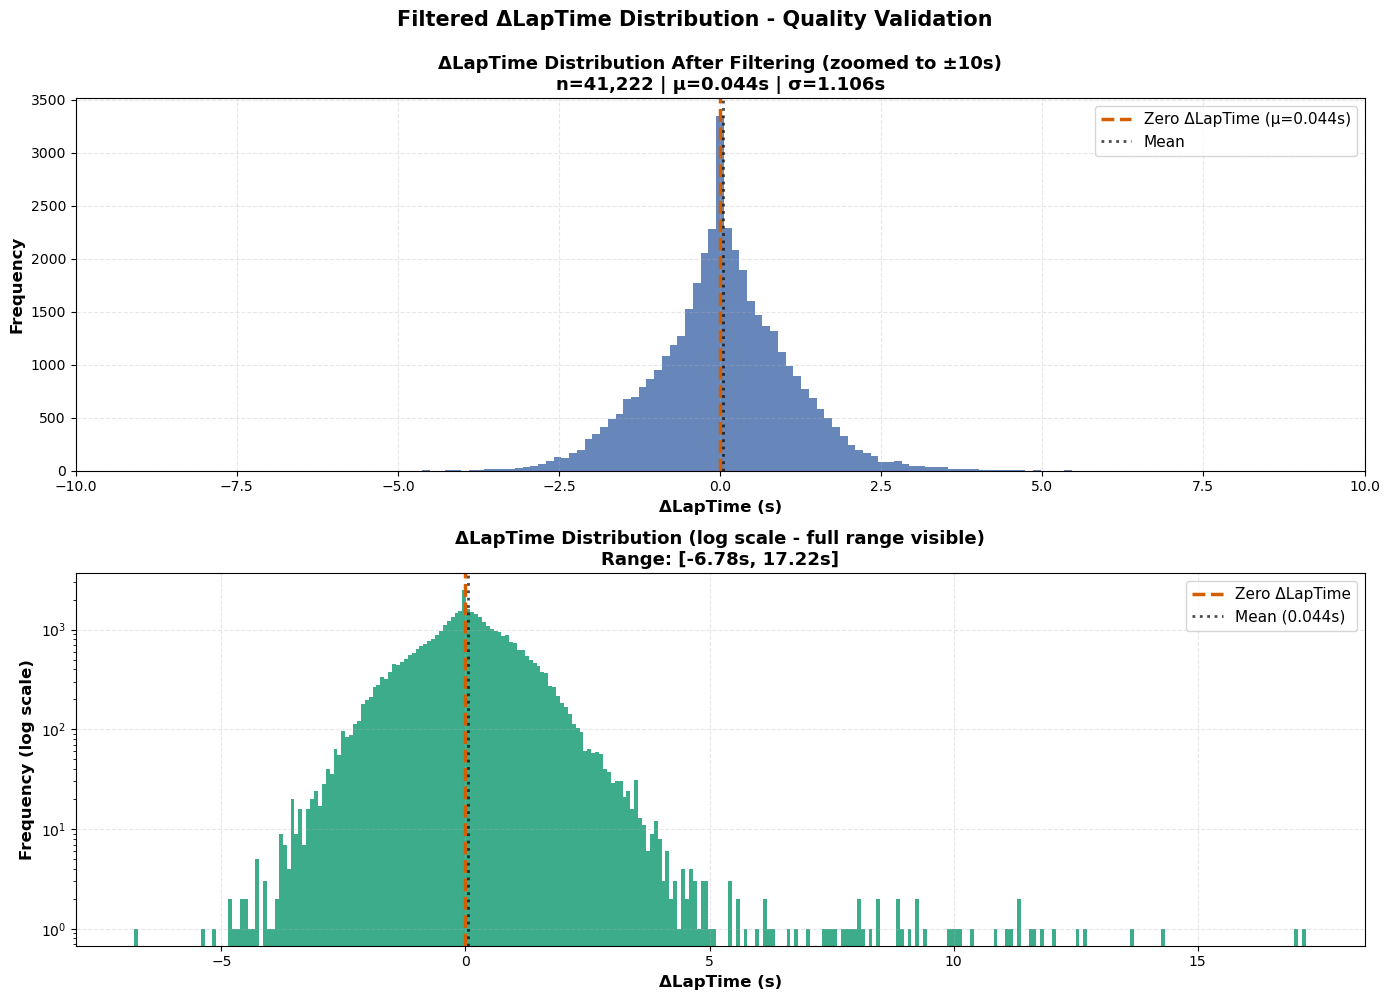


ΔLapTime Summary:
  Transitions: 41,222
  Mean: 0.0442s
  Std: 1.1061s
  Median: 0.0146s
  Range: [-6.783s, 17.219s]
  95th percentile: ±2.116s
  99th percentile: ±3.111s

Applying outlier filtering

Filtering: removed top/bottom 1.0% = 2.0% total
  Lower threshold: -2.530s
  Upper threshold: 2.806s
  Outliers removed: 826 (2.00%)
  Data retained: 40,396 (98.00%)

 Delta LapTime Distribution Visualization

Figure saved to: figures/delta_laptime_distribution.pdf


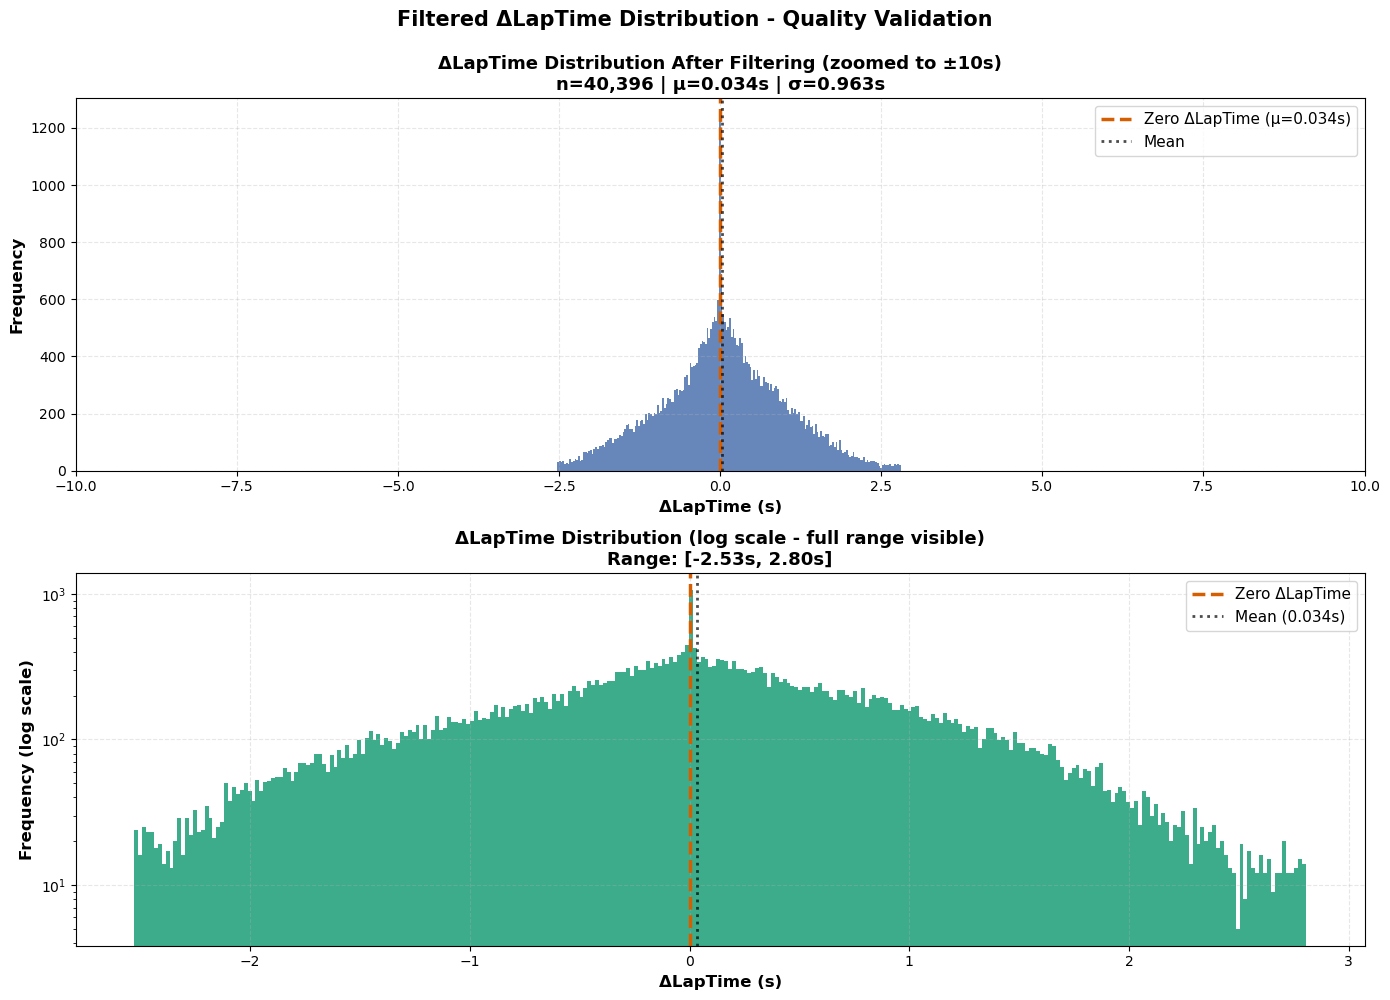


ΔLapTime Summary:
  Transitions: 40,396
  Mean: 0.0338s
  Std: 0.9627s
  Median: 0.0146s
  Range: [-2.527s, 2.805s]
  95th percentile: ±1.949s
  99th percentile: ±2.428s

✓ Saved filtered dataset: csv_output/Filtered_03_with_deltas.xlsx


In [208]:

def visualize_delta_distribution(df, delta_col="LapTime_next_normalized", outlier_percentile=None):
    """
    Visualize LapTime normalized distribution with optional outlier removal.
    
    Parameters:
    -----------
    df : DataFrame
        Data with delta_laptime column
    delta_col : str
        Column name for delta values
    outlier_percentile : float or None
        If None: show full data
        If float: remove top/bottom percentile (e.g., 0.005 = 0.5% each tail, 1% total)
    """

    # Create figures folder if it doesn't exist
    figures_dir = "figures"
    os.makedirs(figures_dir, exist_ok=True)
    
    x_full = df[delta_col].dropna()
    
    # Apply outlier filtering if requested
    if outlier_percentile is not None:
        lower_thresh = x_full.quantile(outlier_percentile)
        upper_thresh = x_full.quantile(1 - outlier_percentile)
        x = x_full[(x_full >= lower_thresh) & (x_full <= upper_thresh)]
        n_outliers = len(x_full) - len(x)


        print(f"\n" + "="*90)
        print("\n Delta LapTime Distribution Visualization (Outliers Removed)")

        print(f"\nFiltering: removed top/bottom {outlier_percentile*100:.1f}% = {outlier_percentile*200:.1f}% total")
        print(f"  Lower threshold: {lower_thresh:.3f}s")
        print(f"  Upper threshold: {upper_thresh:.3f}s")
        print(f"  Outliers removed: {n_outliers:,} ({n_outliers/len(x_full)*100:.2f}%)")
        print(f"  Data retained: {len(x):,} ({len(x)/len(x_full)*100:.2f}%)")
        
        title_suffix = f"Outliers removed: {n_outliers:,} ({outlier_percentile*200:.1f}%)"
        main_title = "Filtered ΔLapTime Distribution - Quality Validation (Outliers Removed)"
        filename = "delta_laptime_distribution_filtered.pdf"
    else:
        x = x_full
        n_outliers = 0
        

        print(f"\n Delta LapTime Distribution Visualization")

        
        title_suffix = ""
        main_title = "Filtered ΔLapTime Distribution - Quality Validation"
        filename = "delta_laptime_distribution.pdf"
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color palette
    color_main = "#4C72B0"      # blue
    color_zero = "#D55E00"      # red/orange
    color_green = "#1B9E77"     # green
    
    # Plot 1: Zoomed view (±10s)
    axes[0].hist(x, bins=200, color=color_main, edgecolor="none", alpha=0.85)
    axes[0].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label=f"Zero ΔLapTime (μ={x.mean():.3f}s)")
    axes[0].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean", alpha=0.7)
    axes[0].set_xlim(-10, 10)
    axes[0].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    
    # Dynamic title based on outlier removal
    if title_suffix:
        title = (f"ΔLapTime Distribution After Filtering (zoomed to ±10s)\n"
                f"n={len(x):,} | μ={x.mean():.3f}s | σ={x.std():.3f}s | {title_suffix}")
    else:
        title = (f"ΔLapTime Distribution After Filtering (zoomed to ±10s)\n"
                f"n={len(x):,} | μ={x.mean():.3f}s | σ={x.std():.3f}s")
    
    axes[0].set_title(title, fontsize=13, fontweight="bold")
    axes[0].legend(fontsize=11, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle="--")
    
    # Plot 2: Log scale (full range - see tails)
    axes[1].hist(x, bins=300, color=color_green, edgecolor="none", alpha=0.85)
    axes[1].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label="Zero ΔLapTime")
    axes[1].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean ({x.mean():.3f}s)", alpha=0.7)
    axes[1].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency (log scale)", fontsize=12, fontweight="bold")
    axes[1].set_yscale("log")
    axes[1].set_title(
        f"ΔLapTime Distribution (log scale - full range visible)\n"
        f"Range: [{x.min():.2f}s, {x.max():.2f}s]",
        fontsize=13, fontweight="bold"
    )
    axes[1].legend(fontsize=11, loc='upper right')
    axes[1].grid(True, alpha=0.3, linestyle="--")
    
    fig.suptitle(main_title, fontsize=15, fontweight="bold", y=0.995)
    plt.tight_layout()
    
    # Save figure as PDF
    pdf_path = os.path.join(figures_dir, filename)
    fig.savefig(pdf_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nFigure saved to: {pdf_path}")
    
    plt.show()
    
    # Print summary
    print(f"\nΔLapTime Summary:")
    print(f"  Transitions: {len(x):,}")
    print(f"  Mean: {x.mean():.4f}s")
    print(f"  Std: {x.std():.4f}s")
    print(f"  Median: {x.median():.4f}s")
    print(f"  Range: [{x.min():.3f}s, {x.max():.3f}s]")
    print(f"  95th percentile: ±{x.abs().quantile(0.95):.3f}s")
    print(f"  99th percentile: ±{x.abs().quantile(0.99):.3f}s")

# Step 1: Visualize full data (no filtering)
visualize_delta_distribution(df_pairs, delta_col="LapTime_next_normalized", outlier_percentile=None)

# Step 2: Apply outlier filtering (remove top/bottom 0.5% = 1% total)
print(f"\n{'='*90}")
print("Applying outlier filtering")
print(f"{'='*90}")

outlier_percentile = 0.01
delta_full = df_pairs['LapTime_next_normalized'].dropna()
lower_thresh = delta_full.quantile(outlier_percentile)
upper_thresh = delta_full.quantile(1 - outlier_percentile)

# Filter dataset
df_pairs_original = df_pairs.copy()  # Keep original for reference
df_pairs = df_pairs[(df_pairs['LapTime_next_normalized'] >= lower_thresh) & 
                    (df_pairs['LapTime_next_normalized'] <= upper_thresh)].copy()

n_removed = len(df_pairs_original) - len(df_pairs)
print(f"\nFiltering: removed top/bottom {outlier_percentile*100:.1f}% = {outlier_percentile*200:.1f}% total")
print(f"  Lower threshold: {lower_thresh:.3f}s")
print(f"  Upper threshold: {upper_thresh:.3f}s")
print(f"  Outliers removed: {n_removed:,} ({n_removed/len(df_pairs_original)*100:.2f}%)")
print(f"  Data retained: {len(df_pairs):,} ({len(df_pairs)/len(df_pairs_original)*100:.2f}%)")

# Step 3: Visualize filtered data
visualize_delta_distribution(df_pairs, delta_col="LapTime_next_normalized", outlier_percentile=None)

# Step 4: Save filtered dataset
df_pairs.to_excel('csv_output/Filtered_03_with_deltas.xlsx', index=False)
print(f"\n✓ Saved filtered dataset: csv_output/Filtered_03_with_deltas.xlsx")


ANALYZING: LapTime (Absolute Lap Times) - Performance by Stint Progress
✓ Saved: figures/laptime_curves_separated.pdf


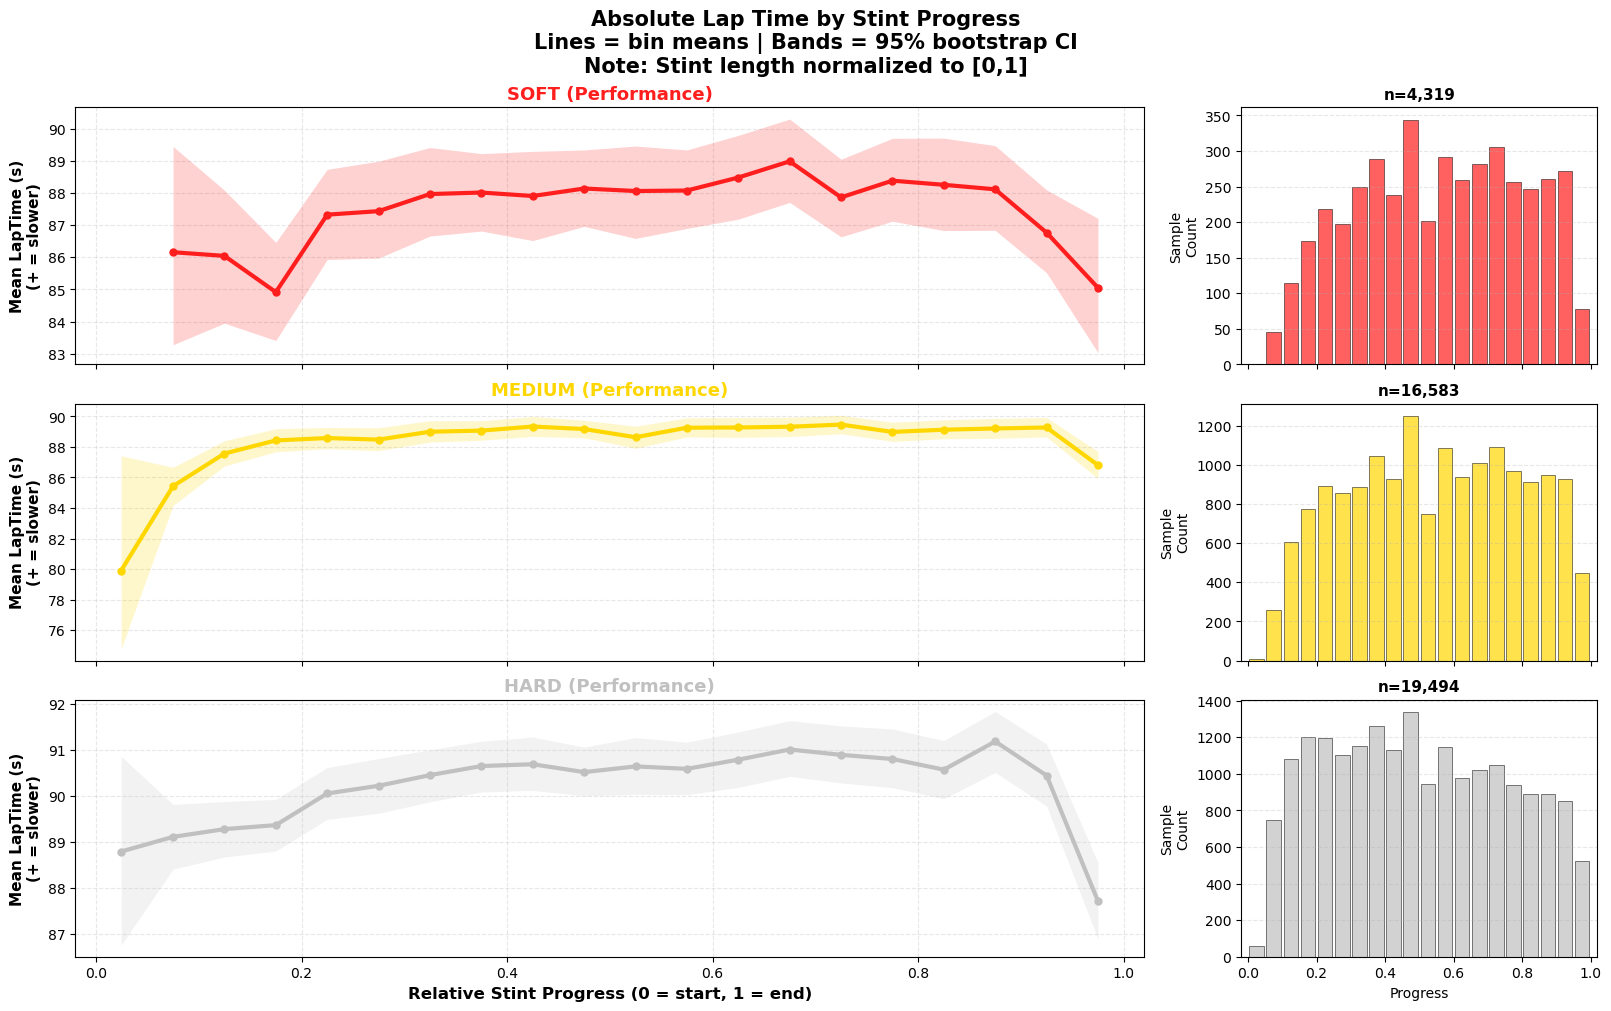


LapTime: Early vs Late by Compound

Compound   Early (0-10%)   Late (90-100%)  Δ (Late-Early)  Total n   
SOFT       +86.1576s        +85.9082s        -0.2494s           4,319
MEDIUM     +82.6695s        +88.0402s        +5.3707s          16,583
HARD       +88.9510s        +89.0783s        +0.1273s          19,494


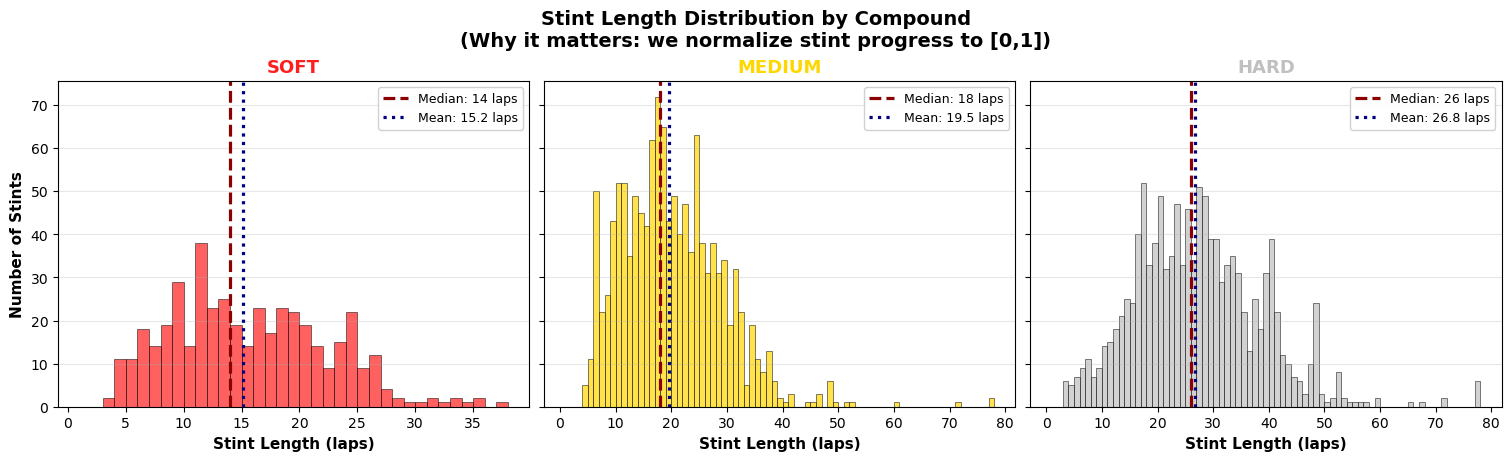

In [209]:

# Helpers
def _bootstrap_ci_mean(x, n_boot=2000, alpha=0.05, seed=42):
    """Return (mean, lower, upper) via bootstrap percentile CI."""
    x = np.asarray(pd.Series(x).dropna(), float)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(x.mean()), float(lo), float(hi)

def summarize_degradation(df, bins=np.linspace(0, 1, 21), metric="delta_laptime"):
    """
    Bin rel_stint_progress and compute mean metric (delta_laptime or LapTime) with 95% CI and counts per compound.
    Returns a tidy summary DataFrame.
    
    Parameters:
    -----------
    df : DataFrame
        Input data with rel_stint_progress, Compound, and metric column
    bins : array-like
        Bin edges for rel_stint_progress
    metric : str
        Either "delta_laptime" (lap-to-lap change) or "LapTime" (absolute lap time)
    """
    keep = df[df["Compound"].isin(["SOFT","MEDIUM","HARD"])].copy()
    keep["bin"] = pd.cut(keep["rel_stint_progress"], bins=bins, include_lowest=True, right=True)
    mids = keep["bin"].cat.categories.mid
    rows = []
    for comp, g in keep.groupby("Compound", observed=True):
        for i, cat in enumerate(g["bin"].cat.categories):
            vals = g.loc[g["bin"] == cat, metric]
            mean, lo, hi = _bootstrap_ci_mean(vals)
            rows.append({
                "Compound": comp,
                "bin": cat,
                "mid": mids[i],
                "mean": mean, "lo": lo, "hi": hi,
                "n": int(vals.notna().sum())
            })
    out = pd.DataFrame(rows)
    return out[out["n"] > 0].sort_values(["Compound","mid"]).reset_index(drop=True)

# Plots
def plot_degradation_curves(summary, bins=np.linspace(0,1,21), metric="delta_laptime"):
    """
    Figure 1: Degradation/Performance curves per compound (left) + sample counts (right).
    Works with both delta_laptime (degradation) and LapTime (absolute performance).
    
    Parameters:
    -----------
    summary : DataFrame
        Summary dataframe from summarize_degradation
    bins : array-like
        Bin edges (for computing bar width)
    metric : str
        Either "delta_laptime" or "LapTime" (determines labels and interpretation)
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    
    # Dynamic titles and labels based on metric
    if metric == "delta_laptime":
        ylabel = "Mean ΔLapTime (s)\n(+ = slower)"
        title_main = "Tire Degradation Curves by Compound"
        title_suffix = "Lines = bin means | Bands = 95% bootstrap CI"
        filename = 'figures/degradation_curves_separated.pdf'
    else:  # LapTime
        ylabel = "Mean LapTime (s)\n(+ = slower)"
        title_main = "Absolute Lap Time by Stint Progress"
        title_suffix = "Lines = bin means | Bands = 95% bootstrap CI"
        filename = 'figures/laptime_curves_separated.pdf'
    
    fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig, 
                  width_ratios=[3, 1], height_ratios=[1, 1, 1])
    
    for r, comp in enumerate(compounds):
        s = summary[summary["Compound"] == comp]
        ax_curve = fig.add_subplot(gs[r, 0])
        ax_count = fig.add_subplot(gs[r, 1])
        
        # Curve with 95% CI
        ax_curve.plot(s["mid"], s["mean"], lw=3, color=colors[comp], marker='o', ms=5, zorder=3)
        ax_curve.fill_between(s["mid"], s["lo"], s["hi"], color=colors[comp], alpha=0.20, zorder=2, lw=0)
        if metric == "delta_laptime":
            ax_curve.axhline(0, color="black", ls="--", lw=1.5, alpha=0.6)
        ax_curve.set_xlim(-0.02, 1.02)
        ax_curve.set_ylabel(ylabel, fontsize=11, fontweight='bold')
        ax_curve.set_title(f"{comp} ({'Degradation' if metric == 'delta_laptime' else 'Performance'})", 
                          fontsize=13, color=colors[comp], fontweight="bold")
        ax_curve.grid(True, alpha=0.3, ls="--")
        if r == 2:
            ax_curve.set_xlabel("Relative Stint Progress (0 = start, 1 = end)", fontsize=12, fontweight='bold')
        else:
            ax_curve.set_xticklabels([])
        
        # Counts (bar height = n per bin)
        width = (bins[1]-bins[0]) * 0.85
        ax_count.bar(s["mid"], s["n"], width=width, color=colors[comp], alpha=0.7,
                     edgecolor='black', linewidth=0.5)
        ax_count.set_xlim(-0.02, 1.02)
        ax_count.set_ylabel("Sample\nCount", fontsize=10)
        ax_count.set_title(f"n={s['n'].sum():,}", fontsize=11, fontweight="bold")
        ax_count.grid(True, axis="y", alpha=0.3, ls="--")
        ax_count.ticklabel_format(style='plain', axis='y')
        if r == 2:
            ax_count.set_xlabel("Progress", fontsize=10)
        else:
            ax_count.set_xticklabels([])
    
    fig.suptitle(f"{title_main}\n{title_suffix}\nNote: Stint length normalized to [0,1]",
                 fontsize=15, fontweight='bold')
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

def plot_stint_length_distribution(df):
    """
    Figure 2: Stint-length histograms per compound (context for normalization).
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True, constrained_layout=True)
    
    for ax, comp in zip(axes, compounds):
        d = df[df["Compound"] == comp]
        if d.empty:
            ax.axis("off")
            continue
        
        # unique stint lengths
        stints = d.groupby(["year","round","RacingNumber","Stint"])["stint_length"].first()
        bins = range(1, int(stints.max())+2)
        ax.hist(stints, bins=bins, color=colors[comp], alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(stints.median(), color='darkred', ls='--', lw=2.3, label=f"Median: {stints.median():.0f} laps")
        ax.axvline(stints.mean(),   color='navy',    ls=':',  lw=2.3, label=f"Mean: {stints.mean():.1f} laps")
        ax.set_title(comp, fontsize=13, fontweight="bold", color=colors[comp])
        ax.set_xlabel("Stint Length (laps)", fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(fontsize=9, framealpha=0.9)
    
    axes[0].set_ylabel("Number of Stints", fontsize=11, fontweight='bold')
    fig.suptitle("Stint Length Distribution by Compound\n(Why it matters: we normalize stint progress to [0,1])",
                 fontsize=14, fontweight='bold')
    
    plt.savefig('figures/stint_length_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()


# Build summary for LapTime metric only
_bins = np.linspace(0, 1, 21)  # 20 bins, 5%-wide each

print("\n" + "="*90)
print("ANALYZING: LapTime (Absolute Lap Times) - Performance by Stint Progress")
print("="*90)

summary_laptime = summarize_degradation(df_pairs, bins=_bins, metric="LapTime")
plot_degradation_curves(summary_laptime, bins=_bins, metric="LapTime")

# Print Early vs Late summary table for LapTime
print(f"\nLapTime: Early vs Late by Compound")
print(f"\n{'Compound':<10} {'Early (0-10%)':<15} {'Late (90-100%)':<15} {'Δ (Late-Early)':<15} {'Total n':<10}")

for comp in ["SOFT", "MEDIUM", "HARD"]:
    s = summary_laptime[summary_laptime["Compound"] == comp]
    early = s.loc[s["mid"] <= 0.10, "mean"].mean()
    late = s.loc[s["mid"] >= 0.90, "mean"].mean()
    delta = (late - early) if np.isfinite(early) and np.isfinite(late) else np.nan
    n_tot = int(s["n"].sum())
    
    print(f"{comp:<10} {early:+.4f}s        {late:+.4f}s        {delta:+.4f}s        {n_tot:>8,}")

# Figure: stint-length context (same for both analyses)
plot_stint_length_distribution(df_pairs)


In [210]:
# ANALYSIS: How many stints show IMPROVEMENT (faster) vs DEGRADATION (slower)?


print("Stint-Level Analysis: Early vs Late Performance")


def analyze_stint_improvement(df, method="thirds"):
    """
    Analyze each stint: is first third faster/slower than last third?
    
    Parameters:
    -----------
    df : DataFrame
        Data with 'Compound', 'Stint', 'RacingNumber', 'year', 'round', 'LapTime', 'LapInStint'
    method : str
       "quantiles" (25th vs 75th percentile)
    
    Returns:
    --------
    results : dict
        Statistics on improvement vs degradation by compound
    """
    
    results = {}
    
    for compound in ["SOFT", "MEDIUM", "HARD"]:
        comp_data = df[df["Compound"] == compound].copy()
        
        improvements = []  # early faster than late (negative difference)
        degradations = []  # early slower than late (positive difference)
        
        # Group by each unique stint
        stint_groups = comp_data.groupby(["year", "round", "Grand_Prix", "RacingNumber", "Stint"])
        
        for (year, rnd, gp, driver, stint), group in stint_groups:
            group = group.sort_values("LapInStint")
            
            if len(group) < 4:  # Skip stints with too few laps
                continue
            
            if method == "thirds":
                # First third and last third
                third_idx = len(group) // 3
                first_third = group.iloc[:third_idx]["LapTime"]
                last_third = group.iloc[-third_idx:]["LapTime"]
            else:  # quantiles
                # 25th and 75th percentile position
                q1_idx = int(len(group) * 0.25)
                q3_idx = int(len(group) * 0.75)
                first_third = group.iloc[:q1_idx]["LapTime"]
                last_third = group.iloc[q3_idx:]["LapTime"]
            
            # Only compare if both have data
            if len(first_third) > 0 and len(last_third) > 0:
                early_avg = first_third.mean()
                late_avg = last_third.mean()
                diff = late_avg - early_avg  # negative = faster at end, positive = slower at end
                
                if diff < 0:  # IMPROVEMENT (faster at end)
                    improvements.append((year, rnd, gp, driver, stint, early_avg, late_avg, diff))
                else:  # DEGRADATION (slower at end)
                    degradations.append((year, rnd, gp, driver, stint, early_avg, late_avg, diff))
        
        total_stints = len(improvements) + len(degradations)
        pct_improvement = (len(improvements) / total_stints * 100) if total_stints > 0 else 0
        pct_degradation = (len(degradations) / total_stints * 100) if total_stints > 0 else 0
        
        avg_improvement = np.mean([d[7] for d in improvements]) if improvements else 0
        avg_degradation = np.mean([d[7] for d in degradations]) if degradations else 0
        
        results[compound] = {
            'total': total_stints,
            'improvement': len(improvements),
            'degradation': len(degradations),
            'pct_improvement': pct_improvement,
            'pct_degradation': pct_degradation,
            'avg_improvement': avg_improvement,
            'avg_degradation': avg_degradation,
            'improvement_stints': improvements,
            'degradation_stints': degradations
        }
    
    return results

results_quantiles = analyze_stint_improvement(df_pairs, method="quantiles")

for comp in ["SOFT", "MEDIUM", "HARD"]:
    r = results_quantiles[comp]
    print(f"\n{comp}:")
    print(f"  Total stints analyzed: {r['total']:,}")
    print(f"  Improvement (faster at end): {r['improvement']:,} ({r['pct_improvement']:.1f}%)")
    print(f"  Degradation (slower at end): {r['degradation']:,} ({r['pct_degradation']:.1f}%)")
    print(f"  Average improvement: {r['avg_improvement']:+.4f}s (negative = faster)")
    print(f"  Average degradation: {r['avg_degradation']:+.4f}s (positive = slower)")



Stint-Level Analysis: Early vs Late Performance

SOFT:
  Total stints analyzed: 354
  Improvement (faster at end): 114 (32.2%)
  Degradation (slower at end): 240 (67.8%)
  Average improvement: -0.5122s (negative = faster)
  Average degradation: +0.7080s (positive = slower)

MEDIUM:
  Total stints analyzed: 1,097
  Improvement (faster at end): 540 (49.2%)
  Degradation (slower at end): 557 (50.8%)
  Average improvement: -0.7288s (negative = faster)
  Average degradation: +0.5757s (positive = slower)

HARD:
  Total stints analyzed: 1,064
  Improvement (faster at end): 597 (56.1%)
  Degradation (slower at end): 467 (43.9%)
  Average improvement: -0.8256s (negative = faster)
  Average degradation: +0.6123s (positive = slower)


Looking at this plot it look like the more close to the end of a stint we are lap time actually improve, but if we take a same race and compare stint with same compound and similar lenght ? 

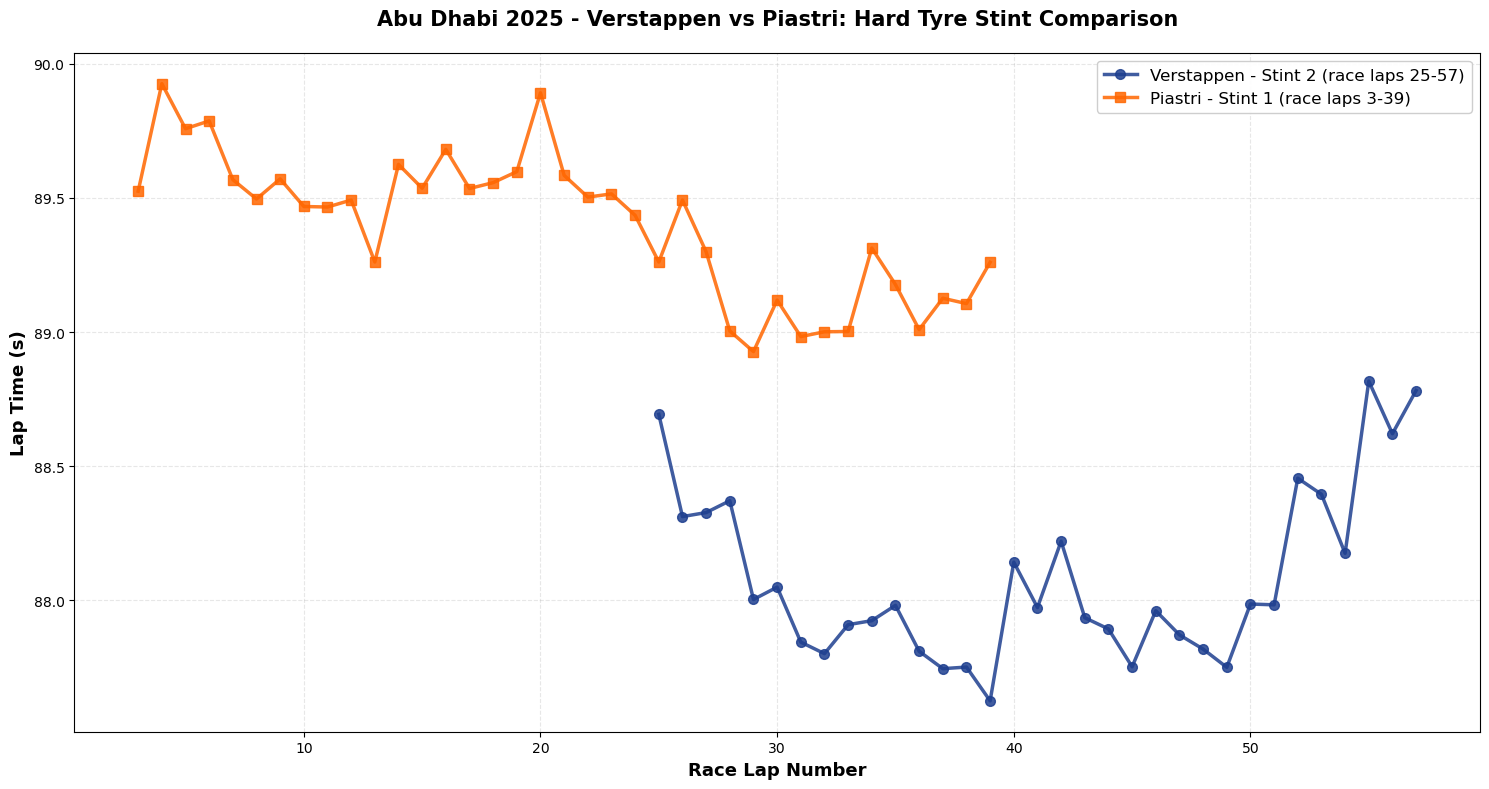

In [211]:
# PLOT: Abu Dhabi 2025 - Verstappen vs Piastri on Hard Tyres

# Filter data for Abu Dhabi 2025, Hard tyres
df_ad2025_hard = df_pairs[
    (df_pairs['year'] == 2025) & 
    (df_pairs['Grand_Prix'] == 'Abu_Dhabi_Grand_Prix') & 
    (df_pairs['Compound'] == 'HARD')
].copy()

if len(df_ad2025_hard) > 0:


    # Try to convert RacingNumber to int if it's a string
    if 'RacingNumber' in df_ad2025_hard.columns:
        df_ad2025_hard['RacingNumber'] = pd.to_numeric(df_ad2025_hard['RacingNumber'], errors='coerce')
    
    # Get ALL laps for Verstappen (RacingNumber=1, Stint 2) and Piastri (RacingNumber=81, Stint 1)
    verstappen_data = df_ad2025_hard[
        (df_ad2025_hard['RacingNumber'] == 1) & 
        (df_ad2025_hard['Stint'] == 2)
    ].sort_values('LapInStint').reset_index(drop=True)
    
    piastri_data = df_ad2025_hard[
        (df_ad2025_hard['RacingNumber'] == 81) & 
        (df_ad2025_hard['Stint'] == 1)
    ].sort_values('LapInStint').reset_index(drop=True)
    

    if len(verstappen_data) > 0 and len(piastri_data) > 0:
        # Use lap_number for x-axis (absolute race lap) instead of LapInStint
        v_laps = verstappen_data['lap_number'].values
        p_laps = piastri_data['lap_number'].values
        
        v_start_lap = v_laps[0]
        v_end_lap = v_laps[-1]
        p_start_lap = p_laps[0]
        p_end_lap = p_laps[-1]
        
        # Create comparison plot
        fig, ax = plt.subplots(figsize=(15, 8))
        
        ax.plot(v_laps, verstappen_data['LapTime'].values, 
                marker='o', linewidth=2.5, markersize=7, 
                label=f'Verstappen - Stint 2 (race laps {v_start_lap}-{v_end_lap})', 
                color='#1E3F8F', alpha=0.85)
        
        ax.plot(p_laps, piastri_data['LapTime'].values, 
                marker='s', linewidth=2.5, markersize=7, 
                label=f'Piastri - Stint 1 (race laps {p_start_lap}-{p_end_lap})', 
                color='#FF6600', alpha=0.85)
        
        ax.set_xlabel('Race Lap Number', fontsize=13, fontweight='bold')
        ax.set_ylabel('Lap Time (s)', fontsize=13, fontweight='bold')
        ax.set_title('Abu Dhabi 2025 - Verstappen vs Piastri: Hard Tyre Stint Comparison', 
                     fontsize=15, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=12, loc='best', framealpha=0.95)
        
        plt.tight_layout()
        plt.savefig('figures/ad2025_verstappen_vs_piastri_hard.pdf', dpi=300, bbox_inches='tight')
        plt.show()


<h3><center>
Let's see the LapTime distribution for 3 random grand prix: 

- 2023: Sãu Paulo Grad Prix 
- 2024: Chinese Grand Prix 
- 2025: Azjerbaijan Grand Prix </center></h1>


Loading filtered data

Lap time evolution by stint analysis 
Grand Prix: 2023 São Paulo
(Skipping first 2 stints from plots)
(Min drivers per stint: 3)

Total laps in 2023 São Paulo (FILTERED - consecutive pairs only): 892
Total drivers: 17
Number of stints: 4
Drivers in race: 17
  Skipping Stint 6 (1 driver(s) < 3 minimum)

Valid stints to plot: 3 stints
Creating 3 subplot(s)...
  Stint 3: 17 drivers, 262 valid laps (filtered)
  Stint 4: 17 drivers, 367 valid laps (filtered)
  Stint 5: 15 drivers, 246 valid laps (filtered)

 Saved: figures/são_paulo_2023_laptime_by_stint_FILTERED.pdf


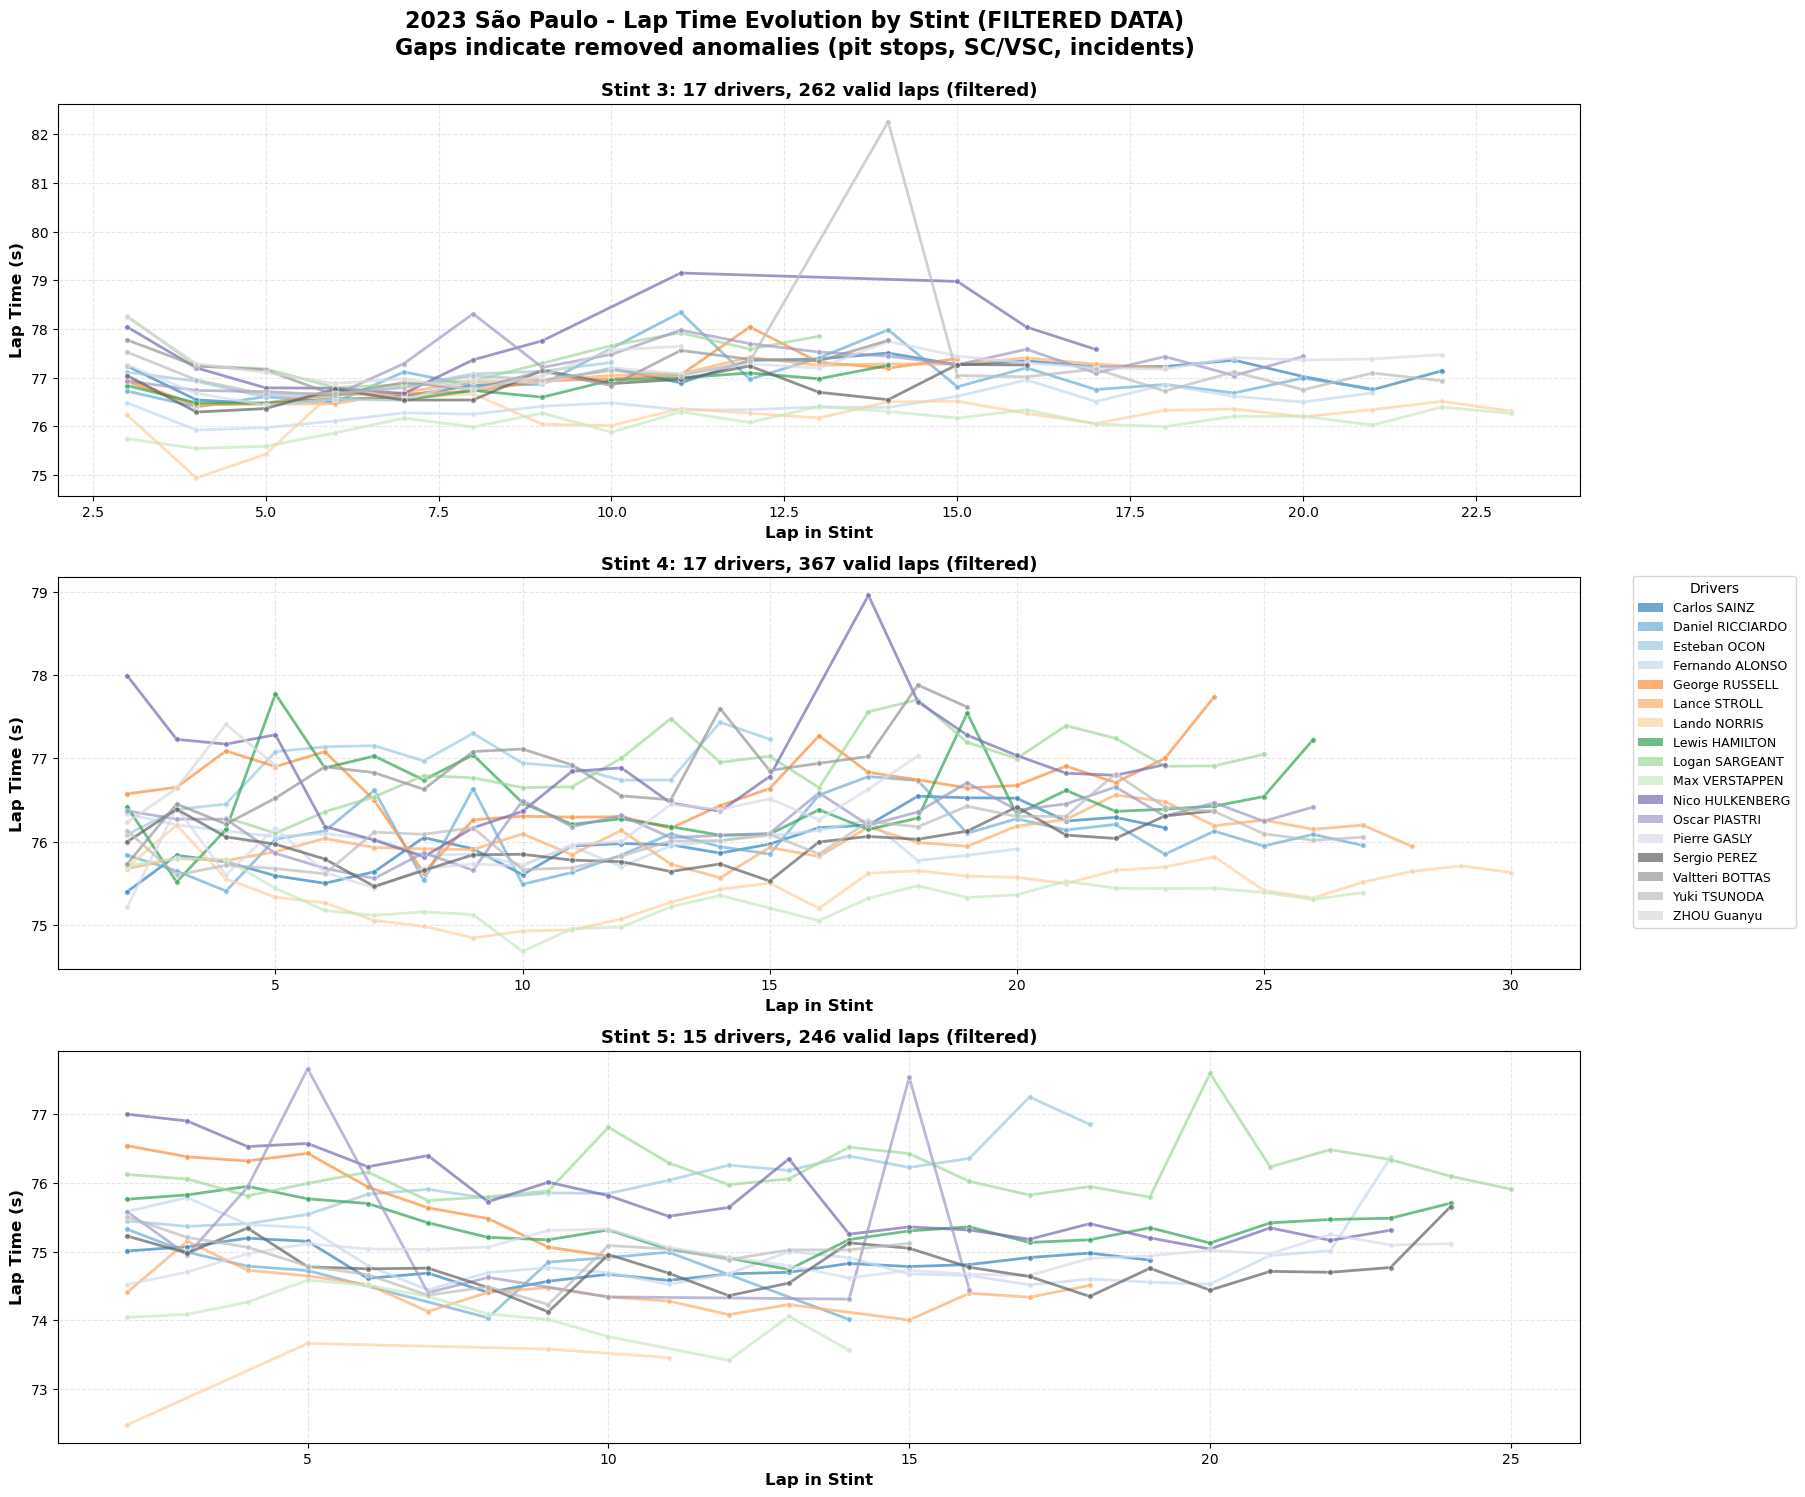


Lap time evolution by stint analysis 
Grand Prix: 2024 Chinese
(Min drivers per stint: 3)

Total laps in 2024 Chinese (FILTERED - consecutive pairs only): 660
Total drivers: 20
Number of stints: 5
Drivers in race: 20
  Skipping Stint 5 (1 driver(s) < 3 minimum)

Valid stints to plot: 4 stints
Creating 4 subplot(s)...
  Stint 1: 20 drivers, 159 valid laps (filtered)
  Stint 2: 20 drivers, 190 valid laps (filtered)
  Stint 3: 13 drivers, 251 valid laps (filtered)
  Stint 4: 4 drivers, 41 valid laps (filtered)

 Saved: figures/chinese_2024_laptime_by_stint_FILTERED.pdf


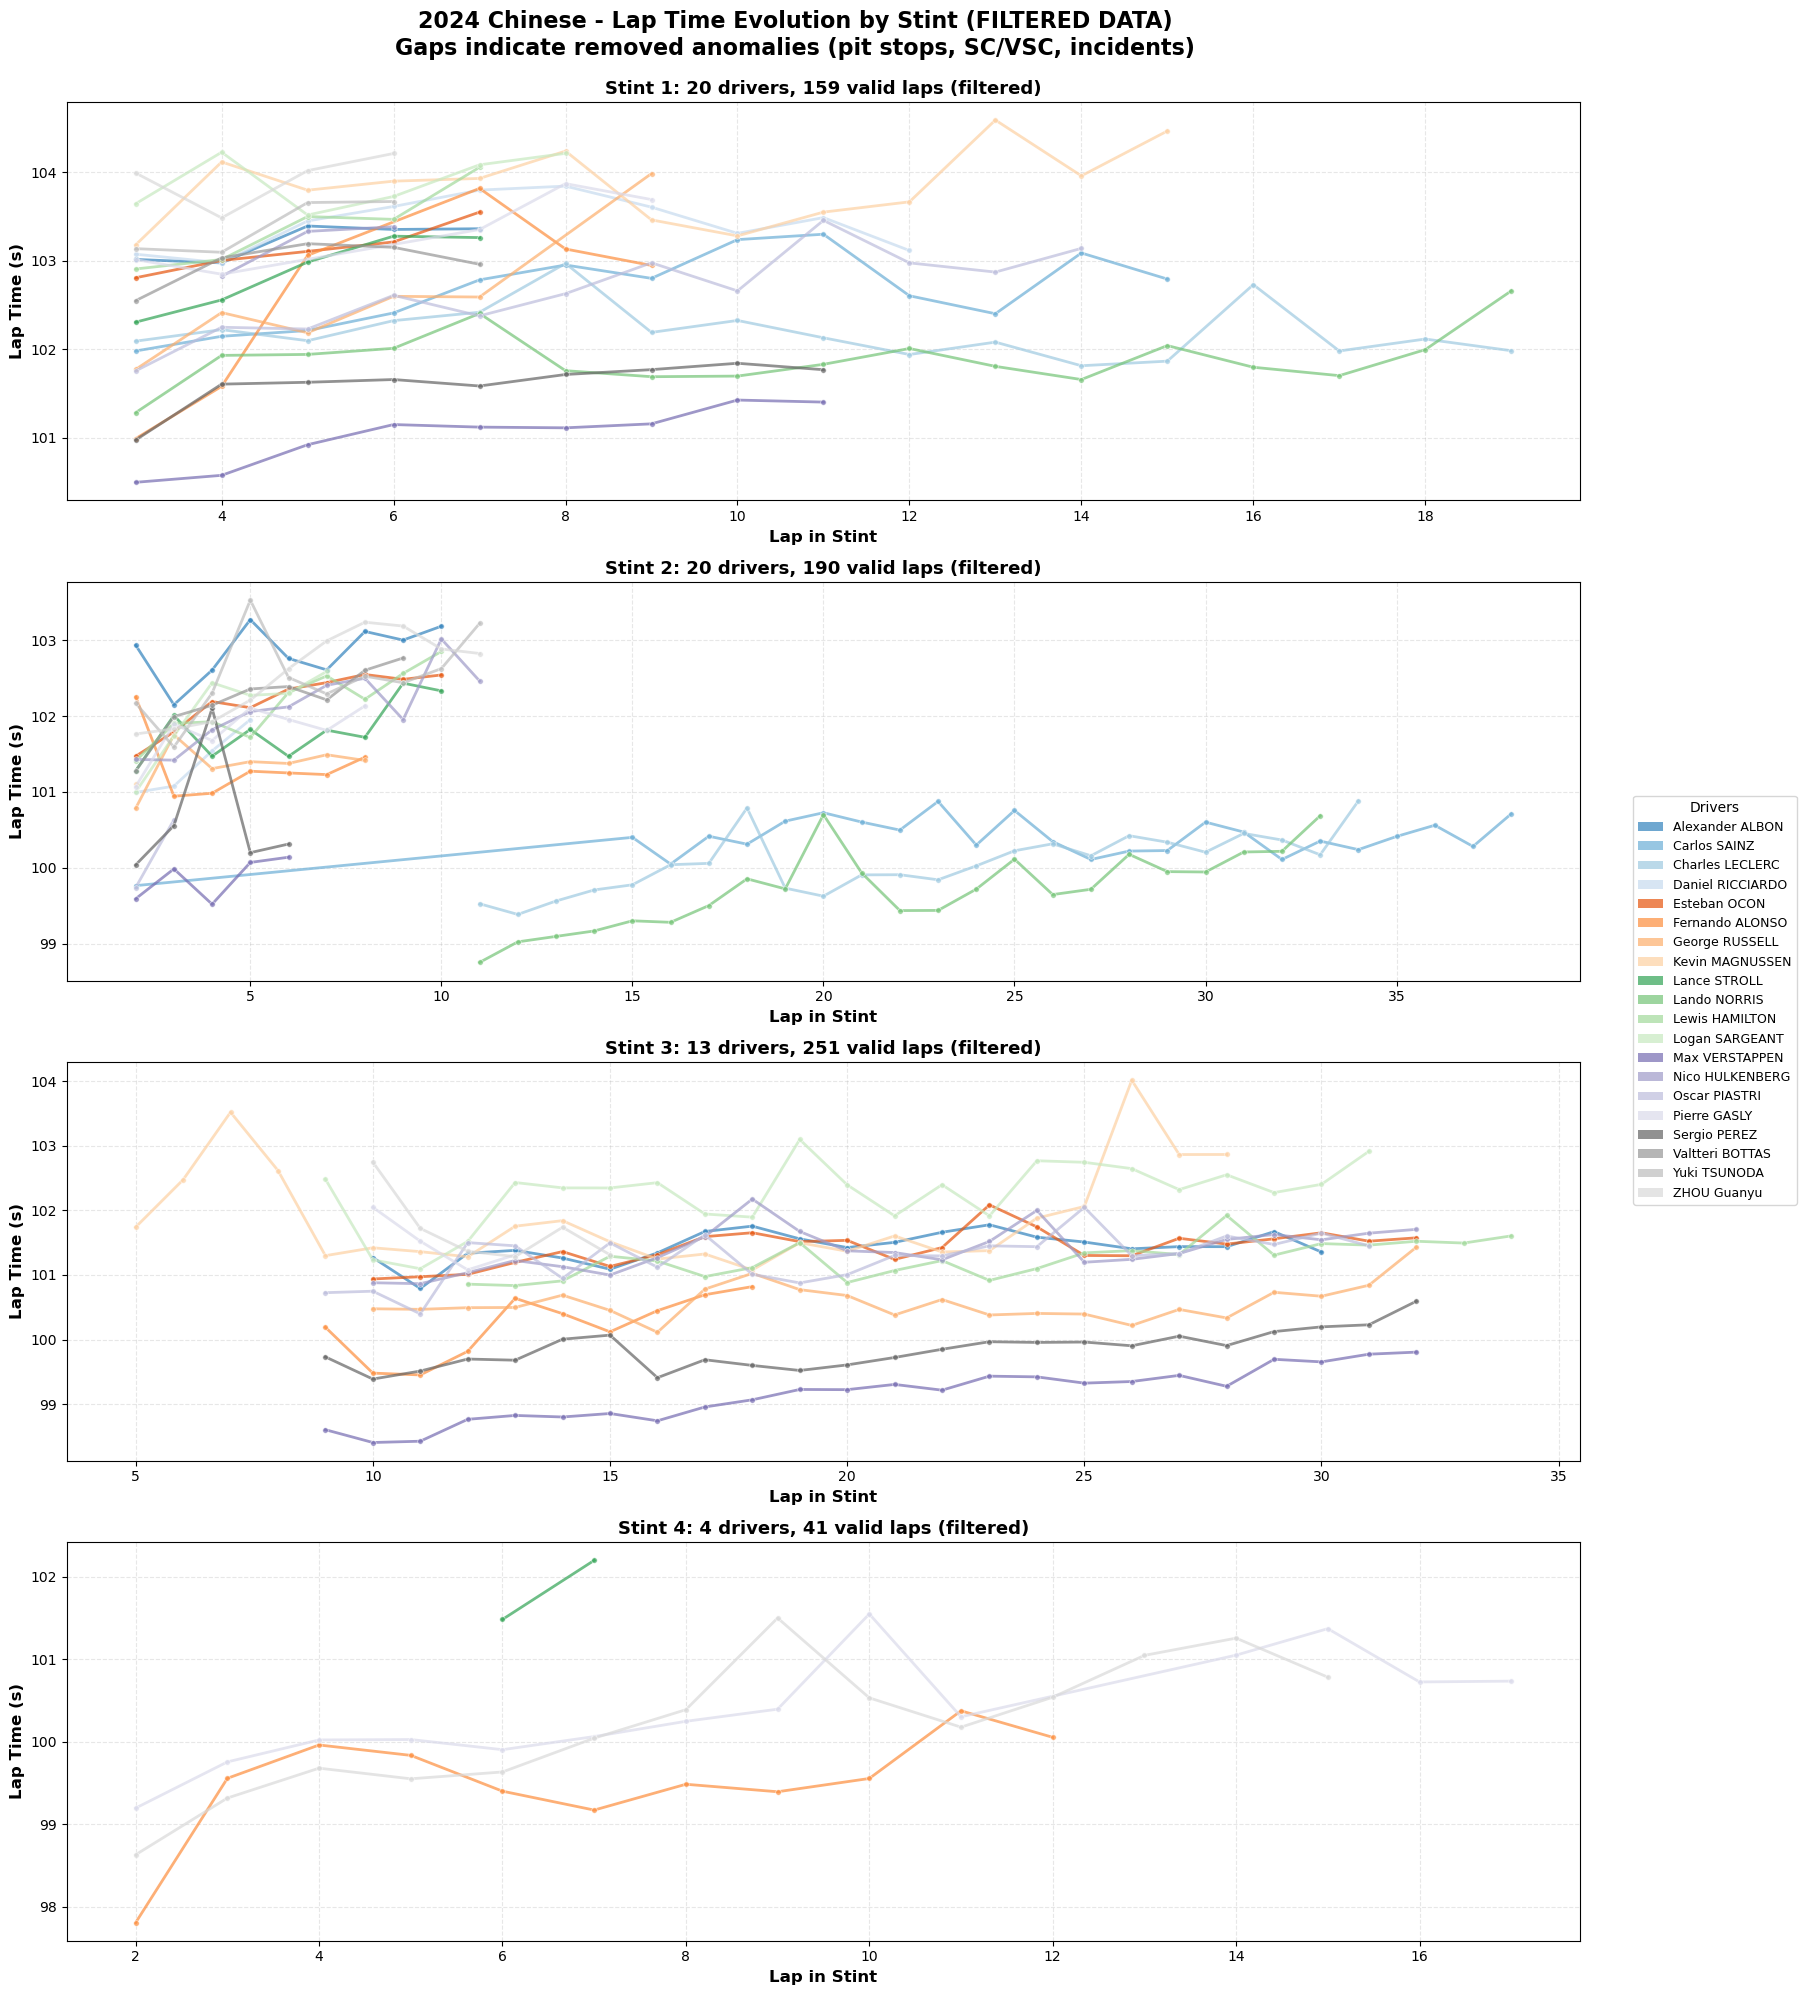


Lap time evolution by stint analysis 
Grand Prix: 2025 Azerbaijan
(Min drivers per stint: 3)

Total laps in 2025 Azerbaijan (FILTERED - consecutive pairs only): 638
Total drivers: 19
Number of stints: 3
Drivers in race: 19
  Skipping Stint 3 (2 driver(s) < 3 minimum)

Valid stints to plot: 2 stints
Creating 2 subplot(s)...
  Stint 1: 17 drivers, 291 valid laps (filtered)
  Stint 2: 18 drivers, 283 valid laps (filtered)

 Saved: figures/azerbaijan_2025_laptime_by_stint_FILTERED.pdf


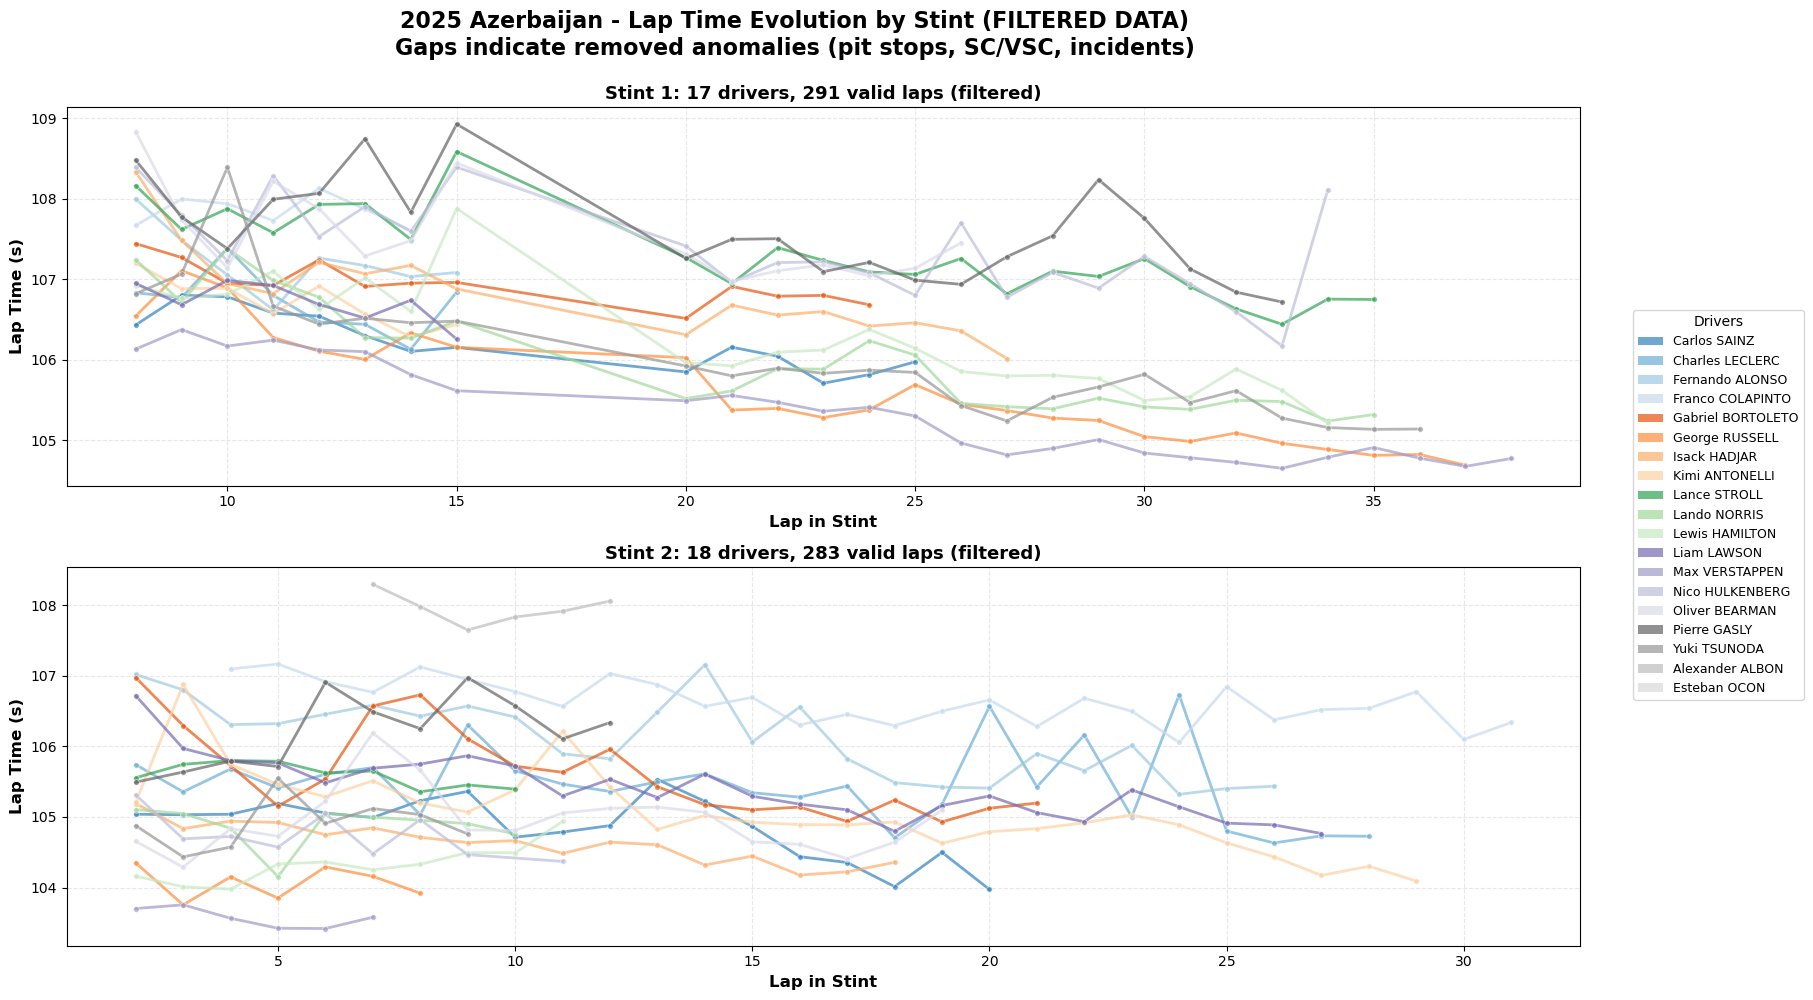

True

In [212]:
# analyzing lap time by stint for some random races 

def analyze_laptime_by_stint(year, grand_prix, race_name, df_pairs=None, min_drivers=2, skip_first_stints=0):
    """
    Analyze and plot lap time evolution by stint for a Grand Prix race.
    
    Parameters:
    -----------
    year : int
        Race year (e.g., 2023, 2024, 2025)
    grand_prix : str
        Grand Prix name (e.g., 'São_Paulo_Grand_Prix', 'Chinese_Grand_Prix')
    race_name : str
        Display name for the race (e.g., "2023 São Paulo")
    df_pairs : pd.DataFrame, optional
        Filtered lap data. If None, loads from 'csv_output/Filtered_03_with_deltas.xlsx'
    min_drivers : int
        Minimum number of drivers in a stint to include it (default: 2)
    skip_first_stints : int
        Number of first stints to skip from plotting (default: 0)
    
    Returns:
    --------
    bool : True if successful, False if no data found
    """
    
    # Load data if not provided
    if df_pairs is None:
        df_pairs = pd.read_excel('csv_output/Filtered_03_with_deltas.xlsx')
    

    print(f"\nLap time evolution by stint analysis ")
    print(f"Grand Prix: {race_name}")
    if skip_first_stints > 0:
        print(f"(Skipping first {skip_first_stints} stints from plots)")
    print(f"(Min drivers per stint: {min_drivers})")


    # Filter for specified race
    race_data_filtered = df_pairs[
        (df_pairs['year'] == year) & 
        (df_pairs['Grand_Prix'] == grand_prix)
    ].copy()

    if len(race_data_filtered) == 0:
        print(f"\n No filtered data found for {race_name}")
        return False

    print(f"\nTotal laps in {race_name} (FILTERED - consecutive pairs only): {len(race_data_filtered):,}")
    print(f"Total drivers: {race_data_filtered['Name'].nunique()}")

    # Get number of stints
    all_stints = sorted(race_data_filtered['Stint'].unique())
    print(f"Number of stints: {len(all_stints)}")

    # Sort by driver and stint
    race_data_filtered = race_data_filtered.sort_values(['Stint', 'Name', 'LapInStint']).reset_index(drop=True)

    # Get all drivers
    all_drivers = race_data_filtered['Name'].unique()
    n_drivers = len(all_drivers)

    print(f"Drivers in race: {n_drivers}")

    # Create color map for drivers
    colors = plt.cm.tab20c(np.linspace(0, 1, n_drivers)) if n_drivers <= 20 else plt.cm.hsv(np.linspace(0, 1, n_drivers))
    driver_colors = {driver: colors[idx] for idx, driver in enumerate(all_drivers)}

    # Filter stints: skip first N and exclude those with fewer than min_drivers
    valid_stints = []
    for stint_num in all_stints:
        if stint_num <= skip_first_stints:
            print(f"  Skipping Stint {stint_num} (in skip_first_stints)")
            continue
        
        stint_data = race_data_filtered[race_data_filtered['Stint'] == stint_num]
        drivers_in_stint = stint_data['Name'].nunique()
        
        if drivers_in_stint < min_drivers:
            print(f"  Skipping Stint {stint_num} ({drivers_in_stint} driver(s) < {min_drivers} minimum)")
            continue
        
        valid_stints.append(stint_num)

    if len(valid_stints) == 0:
        print(f"\n No valid stints found after filtering")
        return False

    print(f"\nValid stints to plot: {len(valid_stints)} stints")

    # Create subplots - one for each valid stint
    n_plots = len(valid_stints)
    fig, axes = plt.subplots(n_plots, 1, figsize=(16, 5 * n_plots), sharex=False)

    # Handle single subplot case
    if n_plots == 1:
        axes = [axes]

    print(f"Creating {n_plots} subplot(s)...")

    # Plot each valid stint
    for plot_idx, stint_num in enumerate(valid_stints):
        stint_data = race_data_filtered[race_data_filtered['Stint'] == stint_num].copy()
        ax = axes[plot_idx]

        # Plot each driver's lap time evolution within this stint
        drivers_in_stint = stint_data['Name'].unique()

        for driver in drivers_in_stint:
            driver_stint_data = stint_data[stint_data['Name'] == driver].sort_values('LapInStint')
            
            # Plot with markers to show gaps where data was filtered
            ax.plot(driver_stint_data['LapInStint'].values, driver_stint_data['LapTime'].values, 
                    color=driver_colors[driver], linewidth=2, alpha=0.7, marker='o', markersize=4,
                    linestyle='-', markerfacecolor=driver_colors[driver], markeredgecolor='white', markeredgewidth=0.5)

        # Formatting
        ax.set_xlabel('Lap in Stint', fontsize=12, fontweight='bold')
        ax.set_ylabel('Lap Time (s)', fontsize=12, fontweight='bold')
        ax.set_title(f'Stint {stint_num}: {len(drivers_in_stint)} drivers, {len(stint_data)} valid laps (filtered)', 
                     fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')

        print(f"  Stint {stint_num}: {len(drivers_in_stint)} drivers, {len(stint_data)} valid laps (filtered)")

    # Add a global legend
    legend_elements = [Patch(facecolor=driver_colors[driver], label=driver, alpha=0.7) 
                       for driver in all_drivers]
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
               fontsize=9, ncol=1, title='Drivers', title_fontsize=10)

    # Generate filename
    race_name_clean = grand_prix.replace('_Grand_Prix', '').lower()
    filename = f'figures/{race_name_clean}_{year}_laptime_by_stint_FILTERED.pdf'

    fig.suptitle(f'{race_name} - Lap Time Evolution by Stint (FILTERED DATA)\nGaps indicate removed anomalies (pit stops, SC/VSC, incidents)', 
                 fontsize=16, fontweight='bold', y=0.995)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n Saved: {filename}")
    plt.show()
    
    return True

# Load data once (more efficient)
print("Loading filtered data")
df_pairs = pd.read_excel('csv_output/Filtered_03_with_deltas.xlsx')
    
# Analyze races with filters
   
    
# São Paulo
analyze_laptime_by_stint(2023, 'São_Paulo_Grand_Prix', '2023 São Paulo', df_pairs, min_drivers=3, skip_first_stints=2)
    
# China
analyze_laptime_by_stint(2024, 'Chinese_Grand_Prix', '2024 Chinese', df_pairs, min_drivers=3)

# Azerbaijan
analyze_laptime_by_stint(2025, 'Azerbaijan_Grand_Prix', '2025 Azerbaijan', df_pairs, min_drivers=3)
    

<h1><center>Wheater influence on Lap Time  </center></h1>

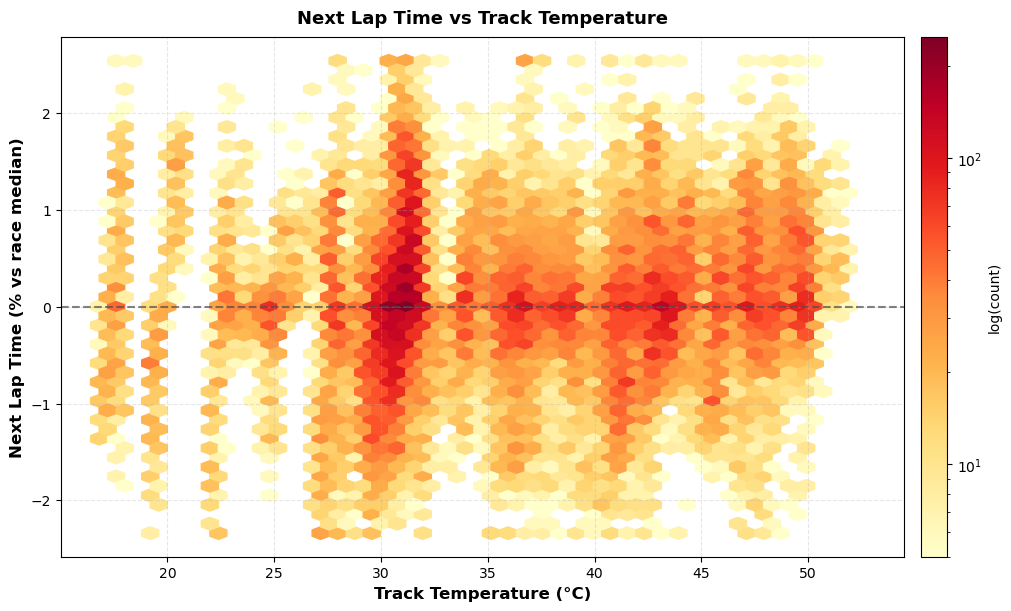

  Slope: +0.007 ± 0.001 %/°C (n=40,396)


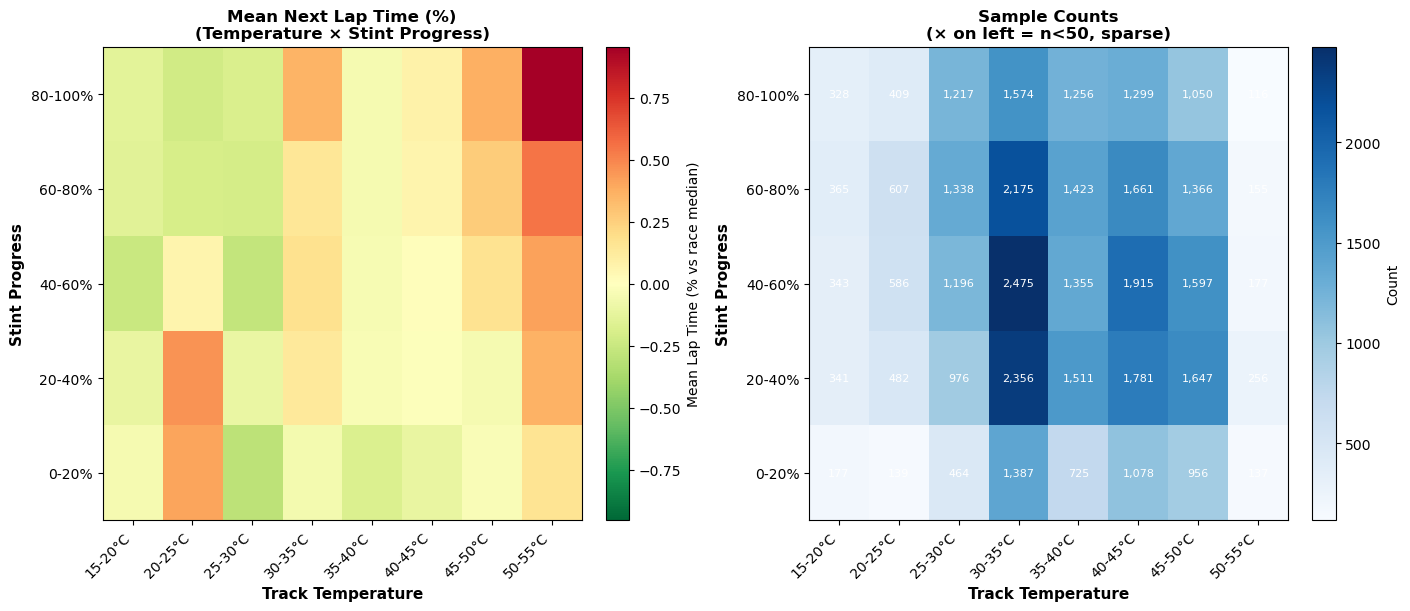

In [213]:
# Helpers 

def _clean(df, cols):
    """Drop rows with NaN in specified columns."""
    return df.dropna(subset=cols).copy()

def _winsor(x, p=0.005):
    """Clip extreme values for visual clarity."""
    lo, hi = x.quantile([p, 1-p])
    return x.clip(lo, hi)


# Panel A: Hexbin

def plot_hexbin_tracktemp(df, gridsize=45, show_slope=False):
    """
    Hexbin density plot: Next Lap Time (normalized) vs Track Temperature.
    Shows temperature effect on normalized lap time performance.
    
    Parameters:
    -----------
    show_slope : bool
        If True, add regression line (default: False for clean visual)
    
    Returns:
    --------
    slope, se, n : float, float, int
        Slope, standard error, sample size (for caption if needed)
    """
    metric = "LapTime_next_normalized"
    d = _clean(df, [metric, "TrackTemp"])
    y = _winsor(d[metric], 0.005)
    x = d["TrackTemp"]
    
    # Labels
    y_label = "Next Lap Time (% vs race median)"
    title = "Next Lap Time vs Track Temperature"
    
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    hb = ax.hexbin(x, y, gridsize=gridsize, bins='log', mincnt=5, cmap='YlOrRd')
    cb = fig.colorbar(hb, ax=ax, pad=0.02)
    cb.set_label("log(count)", fontsize=10)
    
    # Show zero baseline
    ax.axhline(0, ls="--", c="0.3", lw=1.5, alpha=0.7, zorder=2)
    
    ax.set_xlabel("Track Temperature (°C)", fontsize=12, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    
    # Optional slope line
    if show_slope:
        m = ~x.isna() & ~y.isna()
        slope, intercept, r, p, se = linregress(x[m], y[m])
        xx = np.linspace(x.min(), x.max(), 100)
        ax.plot(xx, intercept + slope*xx, c="blue", lw=2, alpha=0.7, ls='--', zorder=3,
                label=f"Slope: {slope:+.2f}%/°C")
        ax.legend(fontsize=9, loc='upper left', framealpha=0.9)
    
    ax.grid(alpha=0.3, ls="--")
    filename = f'figures/weather_panel_A_hexbin_laptime_normalized.pdf'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return stats for caption
    m = ~x.isna() & ~y.isna()
    slope, _, _, _, se = linregress(x[m], y[m])
    return slope, se, len(d)


# Interaction Heatmap

def plot_temp_stint_interaction(df):
    """
    Heatmap: Temperature × Stint Progress interaction for normalized lap times.
    
    Left panel:  Mean Next Lap Time (normalized, %)
    Right panel: Sample counts (blue = reliable, × = sparse)
    
    Shows: Vertical gradient >> horizontal gradient
           → Stint progress dominates over temperature
    """
    metric = "LapTime_next_normalized"
    d = _clean(df, [metric, "TrackTemp", "rel_stint_progress"])
    
    # Bin data
    temp_bins = pd.cut(d["TrackTemp"], bins=np.arange(15, 56, 5))
    prog_bins = pd.cut(d["rel_stint_progress"], bins=np.linspace(0, 1, 6))
    
    pivot = d.groupby([temp_bins, prog_bins])[metric].mean().unstack()
    counts = d.groupby([temp_bins, prog_bins]).size().unstack()
    
    # Symmetric color scale for diverging colormap
    vmax = max(abs(pivot.min().min()), abs(pivot.max().max()))
    vmin = -vmax
    
    fig, (ax, ax_count) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    
    # LEFT: Mean Next Lap Time (normalized)
    im = ax.imshow(pivot.T, aspect='auto', cmap='RdYlGn_r', origin='lower',
                   vmin=vmin, vmax=vmax)
    
    ax.set_yticks(range(len(pivot.columns)))
    ax.set_yticklabels([f"{int(iv.left*100)}-{int(iv.right*100)}%" 
                        for iv in pivot.columns])
    ax.set_xticks(range(len(pivot.index)))
    ax.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                        for iv in pivot.index], rotation=45, ha='right')
    ax.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax.set_title("Mean Next Lap Time (%)\n(Temperature × Stint Progress)", 
                 fontsize=12, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Mean Lap Time (% vs race median)", fontsize=10)
    
    # Mark sparse cells (n < 50)
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            if counts.iloc[i, j] < 50:
                ax.text(i, j, '×', ha='center', va='center', 
                       color='white', fontsize=16, fontweight='bold')
    
    # RIGHT: Sample Counts 
    im2 = ax_count.imshow(counts.T, aspect='auto', cmap='Blues', origin='lower')
    
    ax_count.set_yticks(range(len(counts.columns)))
    ax_count.set_yticklabels([f"{int(iv.left*100)}-{int(iv.right*100)}%" 
                              for iv in counts.columns])
    ax_count.set_xticks(range(len(counts.index)))
    ax_count.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                              for iv in counts.index], rotation=45, ha='right')
    ax_count.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax_count.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax_count.set_title("Sample Counts\n(× on left = n<50, sparse)", 
                       fontsize=12, fontweight='bold')
    
    cbar2 = fig.colorbar(im2, ax=ax_count)
    cbar2.set_label("Count", fontsize=10)
    
    # Annotate counts
    for i in range(len(counts.index)):
        for j in range(len(counts.columns)):
            if counts.iloc[i, j] >= 50:
                ax_count.text(i, j, f"{int(counts.iloc[i, j]):,}", 
                            ha='center', va='center', fontsize=8, color='white')
    
    filename = f'figures/weather_panel_C_interaction_laptime_normalized.pdf'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


slope, se, n = plot_hexbin_tracktemp(df_pairs, gridsize=45, show_slope=False)
print(f"  Slope: {slope:+.3f} ± {1.96*se:.3f} %/°C (n={n:,})")
    
# Interaction heatmap: Temperature × Stint Progress

plot_temp_stint_interaction(df_pairs)
    

<h1><center> Are some drivers better than others/more consistent regarding tyre management? </center></h1>

Here we try to see if there are any difference looking at driver behaviour, we will inspect just one race, specifically the 2024 Italian Grand Prix , why ? 


HARD tyre degradation analysis - Italian GP 2024
Plotting Max VERSTAPPEN...


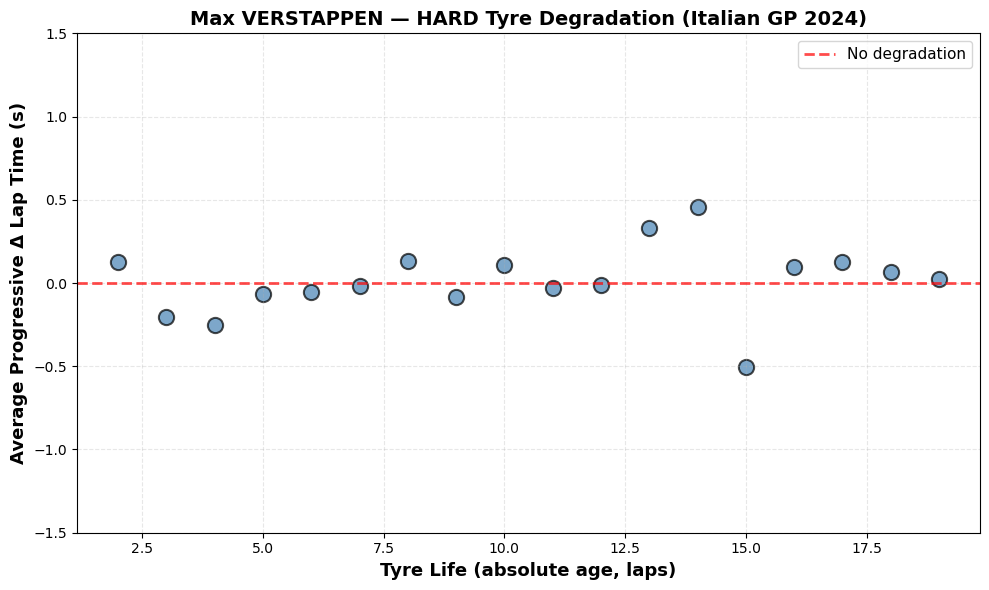

Plotting Lewis HAMILTON...


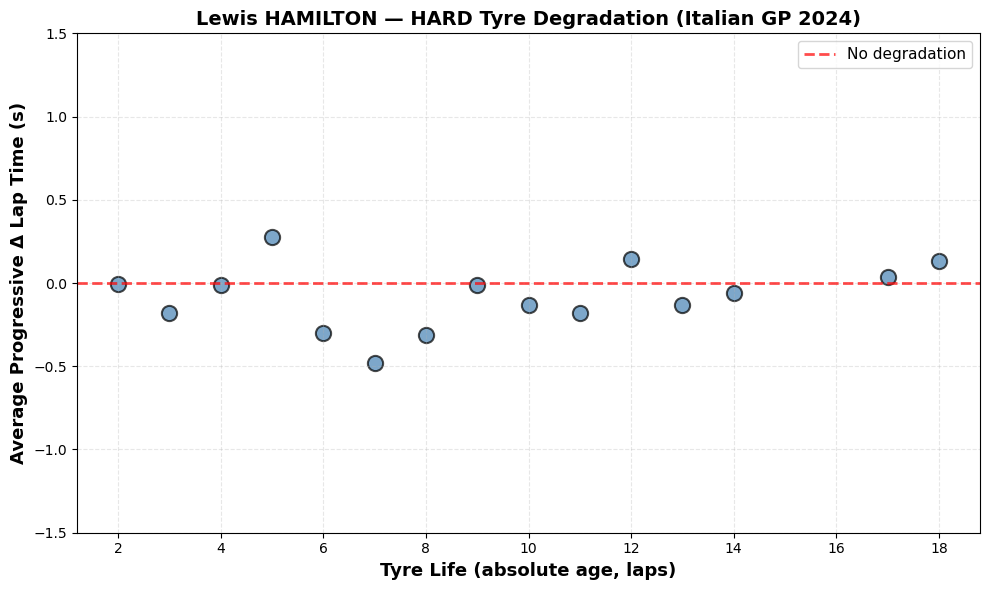

Plotting Lance STROLL...


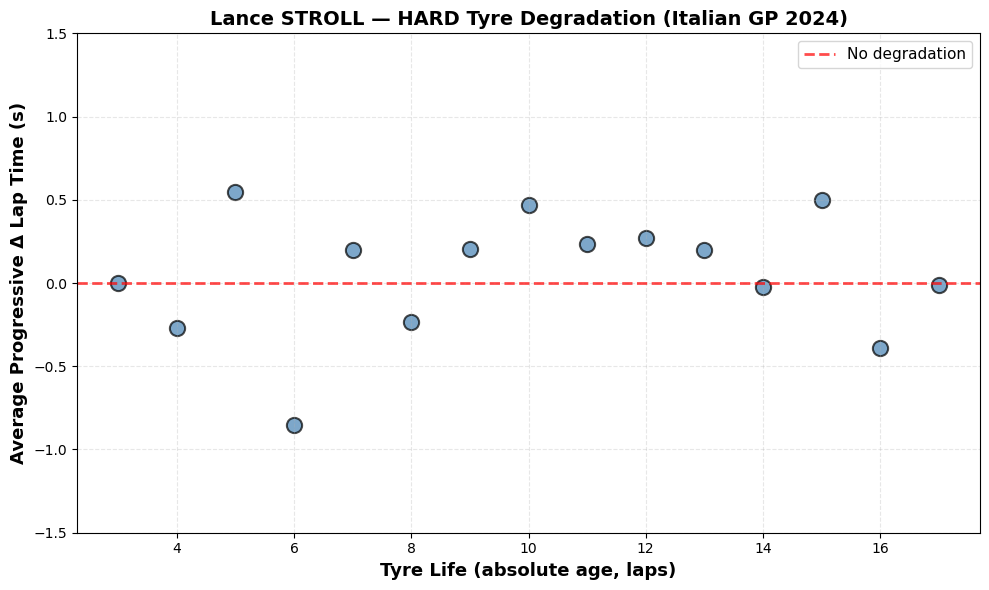

Plotting Kevin MAGNUSSEN...


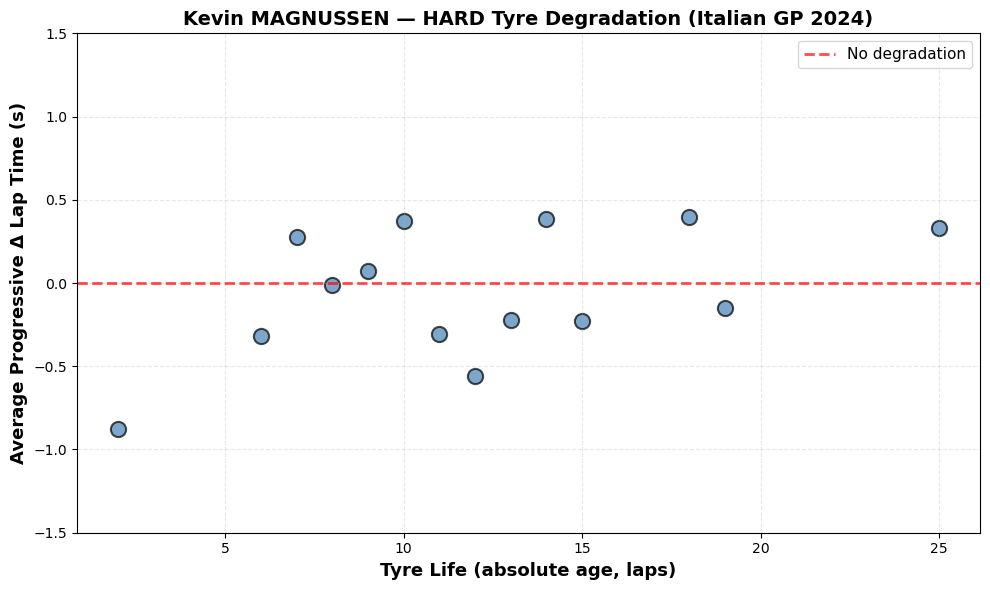

In [214]:

# Load data
df_pairs = pd.read_excel('csv_output/Filtered_03_with_deltas.xlsx')

# Filter for Italian GP 2024
df_it2024 = df_pairs[
    (df_pairs['year'] == 2024) &
    (df_pairs['Grand_Prix'] == 'Italian_Grand_Prix')
].copy()


# Get unique drivers
drivers = df_it2024['Name'].unique()


def plot_hard_tyre_degradation(df, driver,
                                tyre_life_col="TyreLife",
                                lap_in_stint_col="LapInStint",
                                stint_col="Stint",
                                drop_warmup=True,
                                warmup_cut=2,
                                bin_width=1):
    """
    Plot progressive tyre degradation (delta_laptime) vs tyre life for HARD tyres only.
    
    This shows lap-to-lap time change (LapTime_t - LapTime_{t-1}) for HARD compound.
    
    Parameters:
    -----------
    df : DataFrame
        Race data
    driver : str
        Driver name (should match 'Name' column)
    tyre_life_col : str
        Column name for tyre life (TyreLife = absolute tire age)
    lap_in_stint_col : str
        Column name for lap in stint (used for warmup filtering)
    stint_col : str
        Column name for stint number
    drop_warmup : bool
        Whether to drop first N laps
    warmup_cut : int
        Number of laps to drop
    bin_width : int
        Binning width for tyre life (lap grouping)
    """
    
    # Filter driver
    d = df[df["Name"] == driver].copy()
    if len(d) == 0:
        return None
    
    # Filter to HARD tyres only
    d = d[d["Compound"] == "HARD"].copy()
    if len(d) == 0:
        return None
    
    # Drop warmup laps (using LapInStint)
    if drop_warmup and lap_in_stint_col in d.columns:
        d = d[d[lap_in_stint_col] > warmup_cut].copy()
    
    # Drop NaNs
    required_cols = [tyre_life_col, "delta_laptime"]
    d = d.dropna(subset=required_cols).copy()
    
    if len(d) == 0:
        return None
    
    # Bin TyreLife
    d["TyreLifeBin"] = (d[tyre_life_col] // bin_width) * bin_width
    
    # Aggregate delta_laptime by tyre life bin
    agg = (
        d.groupby("TyreLifeBin")["delta_laptime"]
        .mean()
        .reset_index()
        .rename(columns={"TyreLifeBin": "TyreLife", "delta_laptime": "AvgProgressiveDeg"})
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(agg["TyreLife"], agg["AvgProgressiveDeg"], color='steelblue', s=120, alpha=0.7, edgecolors="black", linewidth=1.5)
    ax.axhline(0, linestyle="--", linewidth=2, color='red', alpha=0.7, label='No degradation')
    ax.set_xlabel("Tyre Life (absolute age, laps)", fontsize=13, fontweight='bold')
    ax.set_ylabel("Average Progressive Δ Lap Time (s)", fontsize=13, fontweight='bold')
    ax.set_title(f"{driver} — HARD Tyre Degradation (Italian GP 2024)", fontsize=14, fontweight='bold')
    ax.set_ylim(-1.5, 1.5)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    
    # Save
    filename = f'figures/italian_gp_2024_{driver.lower().replace(" ", "_")}_hard_tyre_degradation.pdf'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return agg



print(f"\nHARD tyre degradation analysis - Italian GP 2024")


for driver in ['Max VERSTAPPEN', 'Lewis HAMILTON', 'Lance STROLL', 'Kevin MAGNUSSEN']:
    if driver in drivers:
        print(f"Plotting {driver}...")
        result = plot_hard_tyre_degradation(df_it2024, driver, bin_width=1)
     




In [215]:
# This function implements a minimal, causal 'pushing' detector with robust scale and optional momentum/traffic tweaks to seem how well we can identify 'pushing' laps.

def compute_pushing_flags_simple_improved(
    df,
    window=5,                 # past laps for baseline
    k=0.7,                    # threshold multiplier (in MAD units)
    momentum_window=3,        # past laps for momentum confirmation
    momentum_threshold=0.3,   # fraction of MAD required for momentum
    use_momentum=True,
    use_traffic_adjustment=False,
    use_race_normalization=True
):
    """
    Minimal, causal 'pushing' detector with robust scale and optional momentum/traffic tweaks.
    Uses ONLY information available up to lap t (no leakage).
    Returns df with: pushing (0/1), pushing_confidence, plus helper columns.
    """
    df = df.copy().sort_values(['year','round','RacingNumber','Stint','lap_number'])
    g  = df.groupby(['year','round','RacingNumber','Stint'], group_keys=False)

    # 0) Pace (optionally normalized by race baseline for circuit-independence)
    if use_race_normalization and 'race_baseline' in df.columns:
        df['pace_norm'] = df['LapTime'] / df['race_baseline']
        pace_col = 'pace_norm'
    else:
        pace_col = 'LapTime'

    # 1) Stint-local baseline (past-only rolling median, strictly causal)
    df['stint_baseline'] = g[pace_col].apply(lambda x: (x.shift(1)).rolling(window, min_periods=2).median())

    # 2) Deviation from baseline (negative => faster than expected)
    df['dev_stint'] = df[pace_col] - df['stint_baseline']

    # 3) True past-only MAD: median( |past - past_rolling_median| )
    #    More mathematically correct than MAD of deviations
    df['mad_raw'] = (df[pace_col].shift(1) - df['stint_baseline'].shift(1)).abs()
    df['stint_mad'] = g['mad_raw'].apply(lambda x: x.rolling(window, min_periods=3).median())

    # Fallback scale for early laps (tiny positive value)
    global_scale = (df[pace_col].median() if np.isfinite(df[pace_col].median()) else 1.0) * 1e-3
    df['stint_mad'] = df['stint_mad'].replace(0, np.nan).fillna(global_scale)

    # 4) Optional momentum confirmation (past-only, causal)
    if use_momentum:
        df['momentum'] = g['dev_stint'].apply(lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean())
        df['momentum_valid'] = (df['momentum'] <= -(momentum_threshold * df['stint_mad'])).astype(int)
    else:
        df['momentum'] = np.nan
        df['momentum_valid'] = 1

    # 5) Optional light traffic adjustment of the threshold (kept OFF by default)
    if use_traffic_adjustment:
        k_adj = pd.Series(k, index=df.index)
        if 'in_dirty_air' in df.columns:
            k_adj = np.where(df['in_dirty_air'] == 1, k * 1.15, k_adj)
        if 'in_clean_air' in df.columns:
            k_adj = np.where(df['in_clean_air'] == 1, k * 0.85, k_adj)
        if 'in_drs_range' in df.columns:
            k_adj = np.where(df['in_drs_range'] == 1, k * 0.75, k_adj)
        k_adj = pd.Series(k_adj, index=df.index)
    else:
        k_adj = pd.Series(k, index=df.index)

    # 6) Main flag + confidence (all causal, no look-ahead)
    threshold = -k_adj * df['stint_mad']
    df['pushing'] = ((df['dev_stint'] <= threshold) & (df['momentum_valid'] == 1)).astype(int)

    # Return only pushing column (will be added back to df_pairs via assignment)
    return df[['pushing']].copy()


# Apply pushing detection (optimized version)
df_pairs['pushing'] = compute_pushing_flags_simple_improved(
    df_pairs,
    window=5,
    k=0.8,
    momentum_window=3,
    momentum_threshold=0.3,
    use_momentum=True,
    use_traffic_adjustment=False,
    use_race_normalization=True
)['pushing'].values


# Count pushing laps
n_pushing = (df_pairs['pushing'] == 1).sum()
total_laps = len(df_pairs)
pct_pushing = 100 * n_pushing / total_laps
print(f"Pushing laps: {n_pushing:,} / {total_laps:,} ({pct_pushing:.1f}%)")


Pushing laps: 5,620 / 40,396 (13.9%)


<h1><center> Creating the final dataset </center></h1>

In [216]:
print(f"\nWorking with filtered dataset 03 with deltas")

# Use df_pairs directly (already has delta_laptime and cumulative_degradation)
df_merged = df_pairs.copy()

# Add squared term (captures accelerating degradation)
df_merged['LapInStint_squared'] = df_merged['LapInStint'] ** 2




Working with filtered dataset 03 with deltas


<h1><center> Correlation matrix </center></h1>


 Plotting the correlation matrix for numerical features

Numerical columns for correlation (32):
['year', 'round', 'RacingNumber', 'lap_number', 'LapTime', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Stint', 'TyreAgeAtStart', 'LapInStint', 'TyreLife', 'is_leader', 'in_drs_range', 'in_dirty_air', 'in_clean_air', 'stint_length', 'rel_stint_progress', 'LapTime_next', 'delta_laptime', 'LapTime_next_normalized', 'race_median', 'cumulative_degradation', 'laptime_rolling_std_3', 'laptime_cumulative_trend', 'stint_mean_so_far', 'pushing', 'LapInStint_squared']

 High Correlations (|r| > 0.7)

Found 11 high correlations:
  LapTime_next                   <-> LapTime                        : +0.999
  stint_mean_so_far              <-> LapTime                        : +0.998
  stint_mean_so_far              <-> LapTime_next                   : +0.997
  race_median                    <-> LapTime_next                   : +0.997
  race_median           

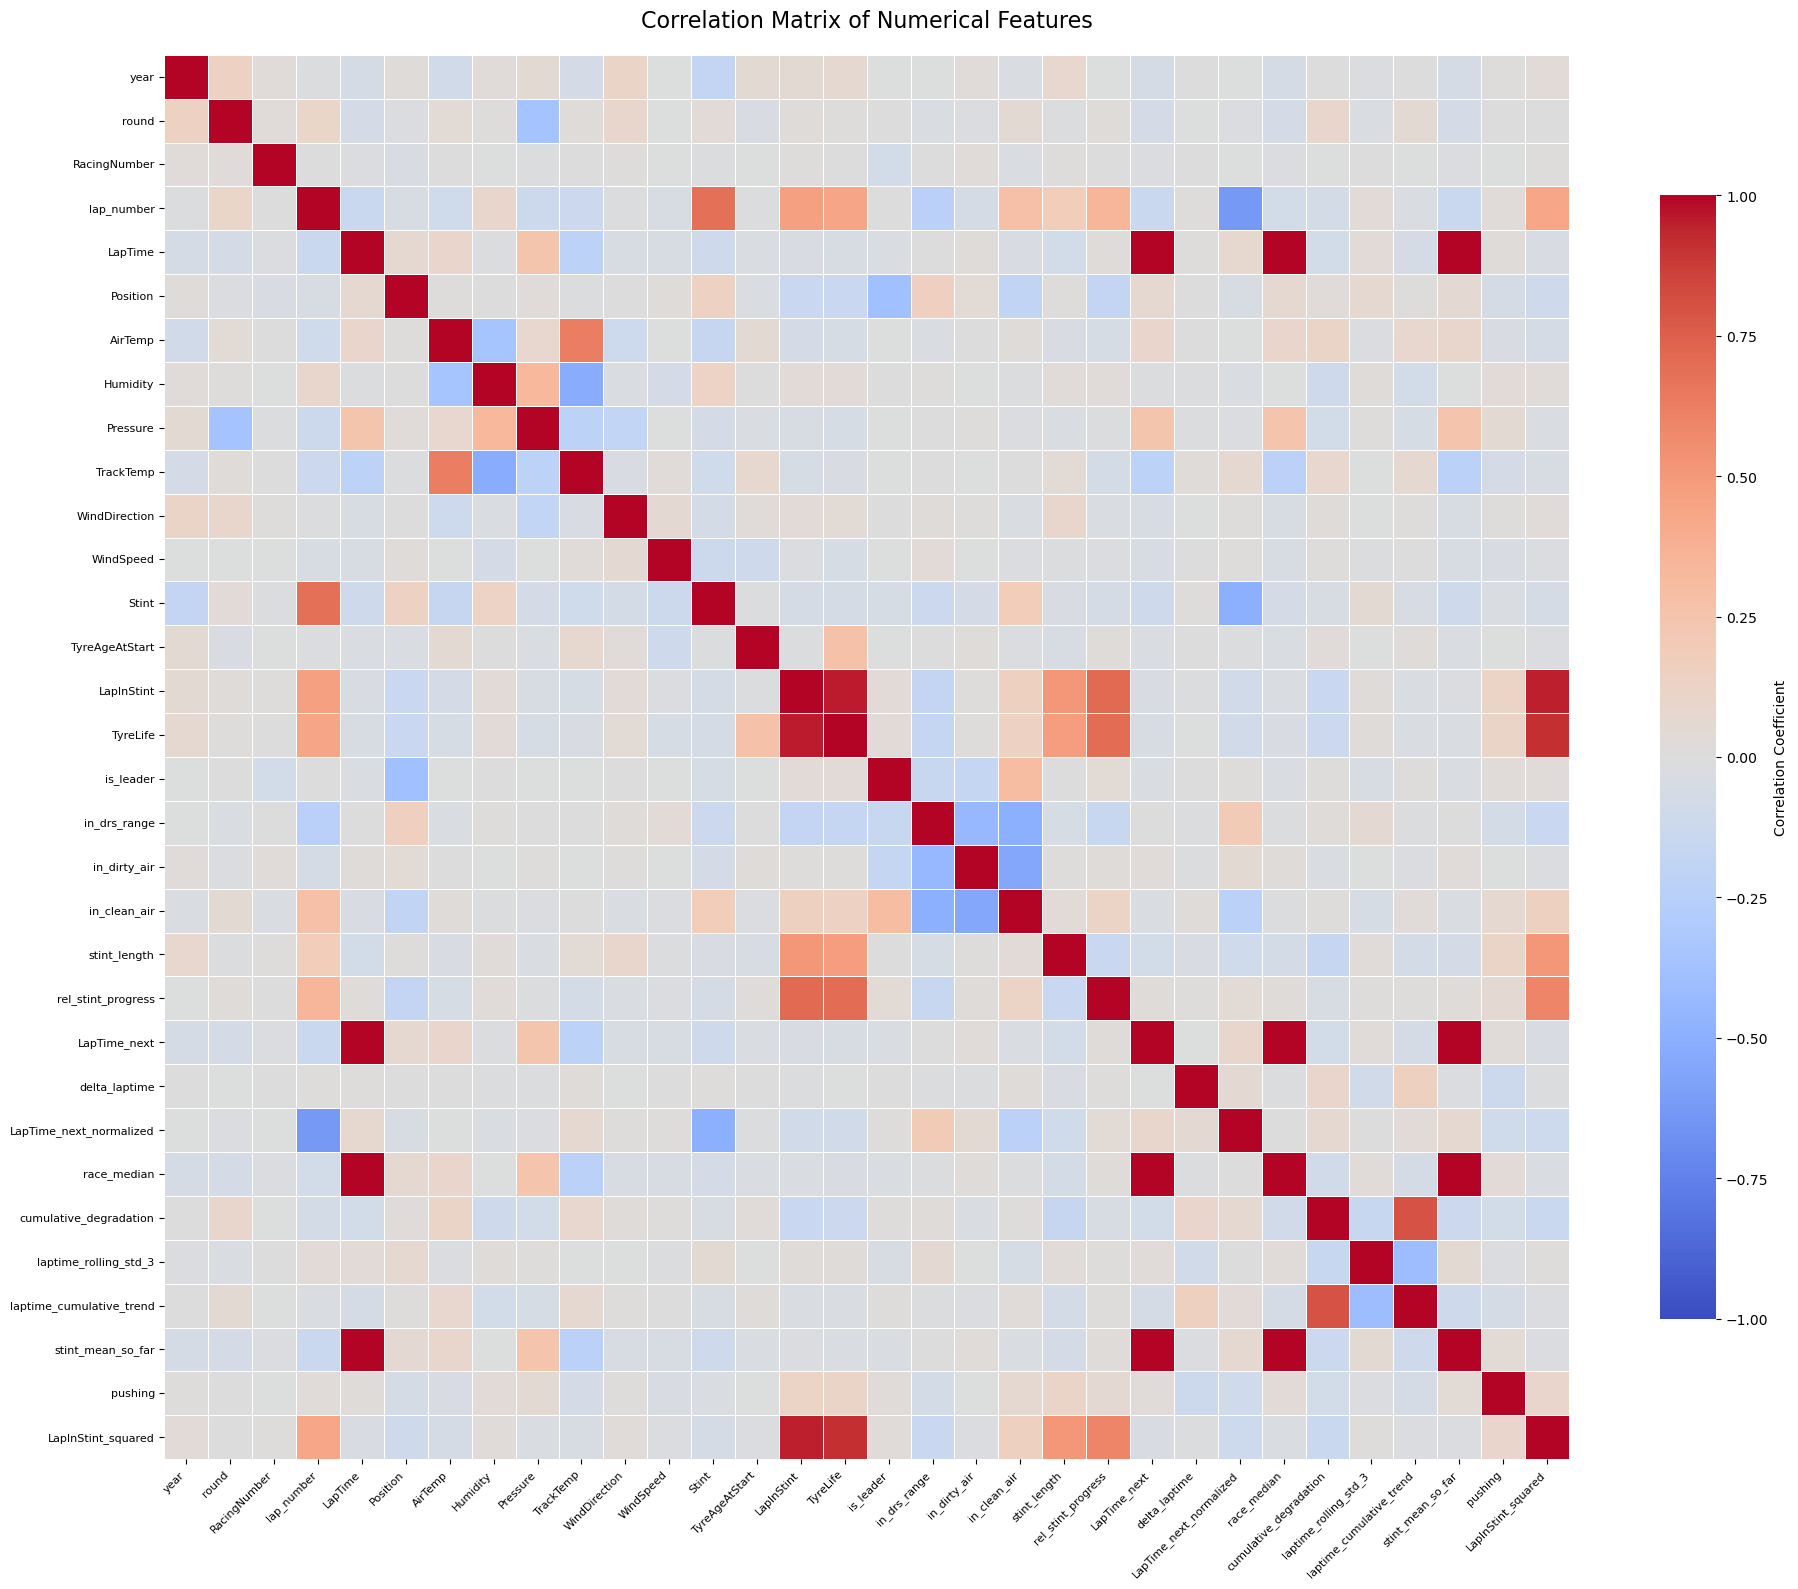

In [217]:

print(f"\n Plotting the correlation matrix for numerical features")

# Select only numerical columns for correlation
numerical_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns for correlation ({len(numerical_cols)}):")
print(numerical_cols)

# Calculate correlation matrix
df_corr = df_merged[numerical_cols].corr()

# Create figure with appropriate size
fig, ax = plt.subplots(figsize=(20, 16))

# Create heatmap
sns.heatmap(df_corr, 
            annot=False,  # Set to True if you want to see correlation values
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,  
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            ax=ax)

plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# # Save the plot
plt.savefig('figures/Correlation_Matrix.pdf', dpi=300, bbox_inches='tight')

# plt.show()

# Print some high correlations (absolute value > 0.7, excluding diagonal)
print(f"\n High Correlations (|r| > 0.7)")


# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(df_corr, dtype=bool))
df_corr_upper = df_corr.where(~mask)

# Find high correlations
high_corr = []
for col in df_corr_upper.columns:
    for idx in df_corr_upper.index:
        val = df_corr_upper.loc[idx, col]
        if pd.notna(val) and abs(val) > 0.7:
            high_corr.append((idx, col, val))

# Sort by absolute correlation value
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr:
    print(f"\nFound {len(high_corr)} high correlations:")
    for var1, var2, corr_val in high_corr[:20]:  # Show top 20
        print(f"  {var1:30s} <-> {var2:30s} : {corr_val:+.3f}")
    if len(high_corr) > 20:
        print(f"  ... and {len(high_corr) - 20} more")
else:
    print("\nNo correlations with |r| > 0.7 found (excluding diagonal)")

In [218]:
 # dropping columns with correlation almost 1 in order to avoid multicollinearity issues

# WIND ENCODING

# Convert degrees to radians
theta = np.deg2rad(df_merged['WindDirection'])

# Cyclic encoding (prevents discontinuity)
df_merged['wind_sin'] = np.sin(theta)
df_merged['wind_cos'] = np.cos(theta)

# Columns to drop due to high correlation or redundancy

columns_to_drop_corr = [
    # REMOVE REDUNDANT FEATURES (high correlation)
    'LapTime_next_normalized',                # leakage (r=0.999 with LapTime)
    'race_median',                 # redundant with LapTime (r=0.996)
    'stint_mean_so_far',           # redundant with LapTime (r=0.998)
    'first_lap_of_stint',          # redundant with LapTime (r=0.949)
    'LapInStint_squared',          # redundant (r=0.947 with LapInStint)              # redundant (keep TyreLife instead)
    # potential leakage
    'laptime_cumulative_trend',
    'stint_length',    # potential leakage
    'LapInStint',
    'laptime_cumulative_trend',       
    'stint_mean_so_far'
]

# Drop columns that exist in the dataframe
existing_cols_to_drop = [col for col in columns_to_drop_corr if col in df_merged.columns]
print(f"\nDropping {len(existing_cols_to_drop)} columns:")
for col in existing_cols_to_drop:
    print(f"  - {col}")

df_merged.drop(columns=existing_cols_to_drop, inplace=True)


column_order = [ 
    # METADATA
      'year', 'round', 'name', 'Grand_Prix', 'type', 'Name', 'RacingNumber', 'Team', 'lap_number',
    
    # RACE STATE
    'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing',
    
    # TYRE/STINT (updated with TyreLife, removed TyreAgeAtStart and LapInStint_squared)

    'Compound', 'Stint', 'TyreLife',  'TyreAgeAtStart',
    
    # TARGET (MAIN)
    'LapTime_next',
    
    # DEGRADATION FEATURES
    'delta_laptime', 'cumulative_degradation', 
    
    # ENVIRONMENT
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'WindDirection','wind_sin', 'wind_cos',
    
    # ADDITIONAL FEATURES
    'laptime_rolling_std_3'
]

df_merged = df_merged[[col for col in column_order if col in df_merged.columns]]

print(f"\nMerged dataset shape: {df_merged.shape}")
print(f"Columns after merge: {len(df_merged.columns)}")

# Save the merged dataset
df_merged.to_excel('csv_output/Filtered_final.xlsx', index=False)
print(f"\n✓ Saved: csv_output/Filtered_final.xlsx")

print(f"\nFinal merged columns ({len(df_merged.columns)}):")
print(df_merged.columns.tolist())


Dropping 9 columns:
  - LapTime_next_normalized
  - race_median
  - stint_mean_so_far
  - LapInStint_squared
  - laptime_cumulative_trend
  - stint_length
  - LapInStint
  - laptime_cumulative_trend
  - stint_mean_so_far

Merged dataset shape: (40396, 30)
Columns after merge: 30

✓ Saved: csv_output/Filtered_final.xlsx

Final merged columns (30):
['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Compound', 'Stint', 'TyreLife', 'TyreAgeAtStart', 'LapTime_next', 'delta_laptime', 'cumulative_degradation', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'WindDirection', 'wind_sin', 'wind_cos', 'laptime_rolling_std_3']



FINAL CORRELATION MATRIX - Post Feature Engineering

Numerical columns for correlation (25):
['year', 'round', 'RacingNumber', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Stint', 'TyreLife', 'TyreAgeAtStart', 'LapTime_next', 'delta_laptime', 'cumulative_degradation', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'WindDirection', 'wind_sin', 'wind_cos', 'laptime_rolling_std_3']


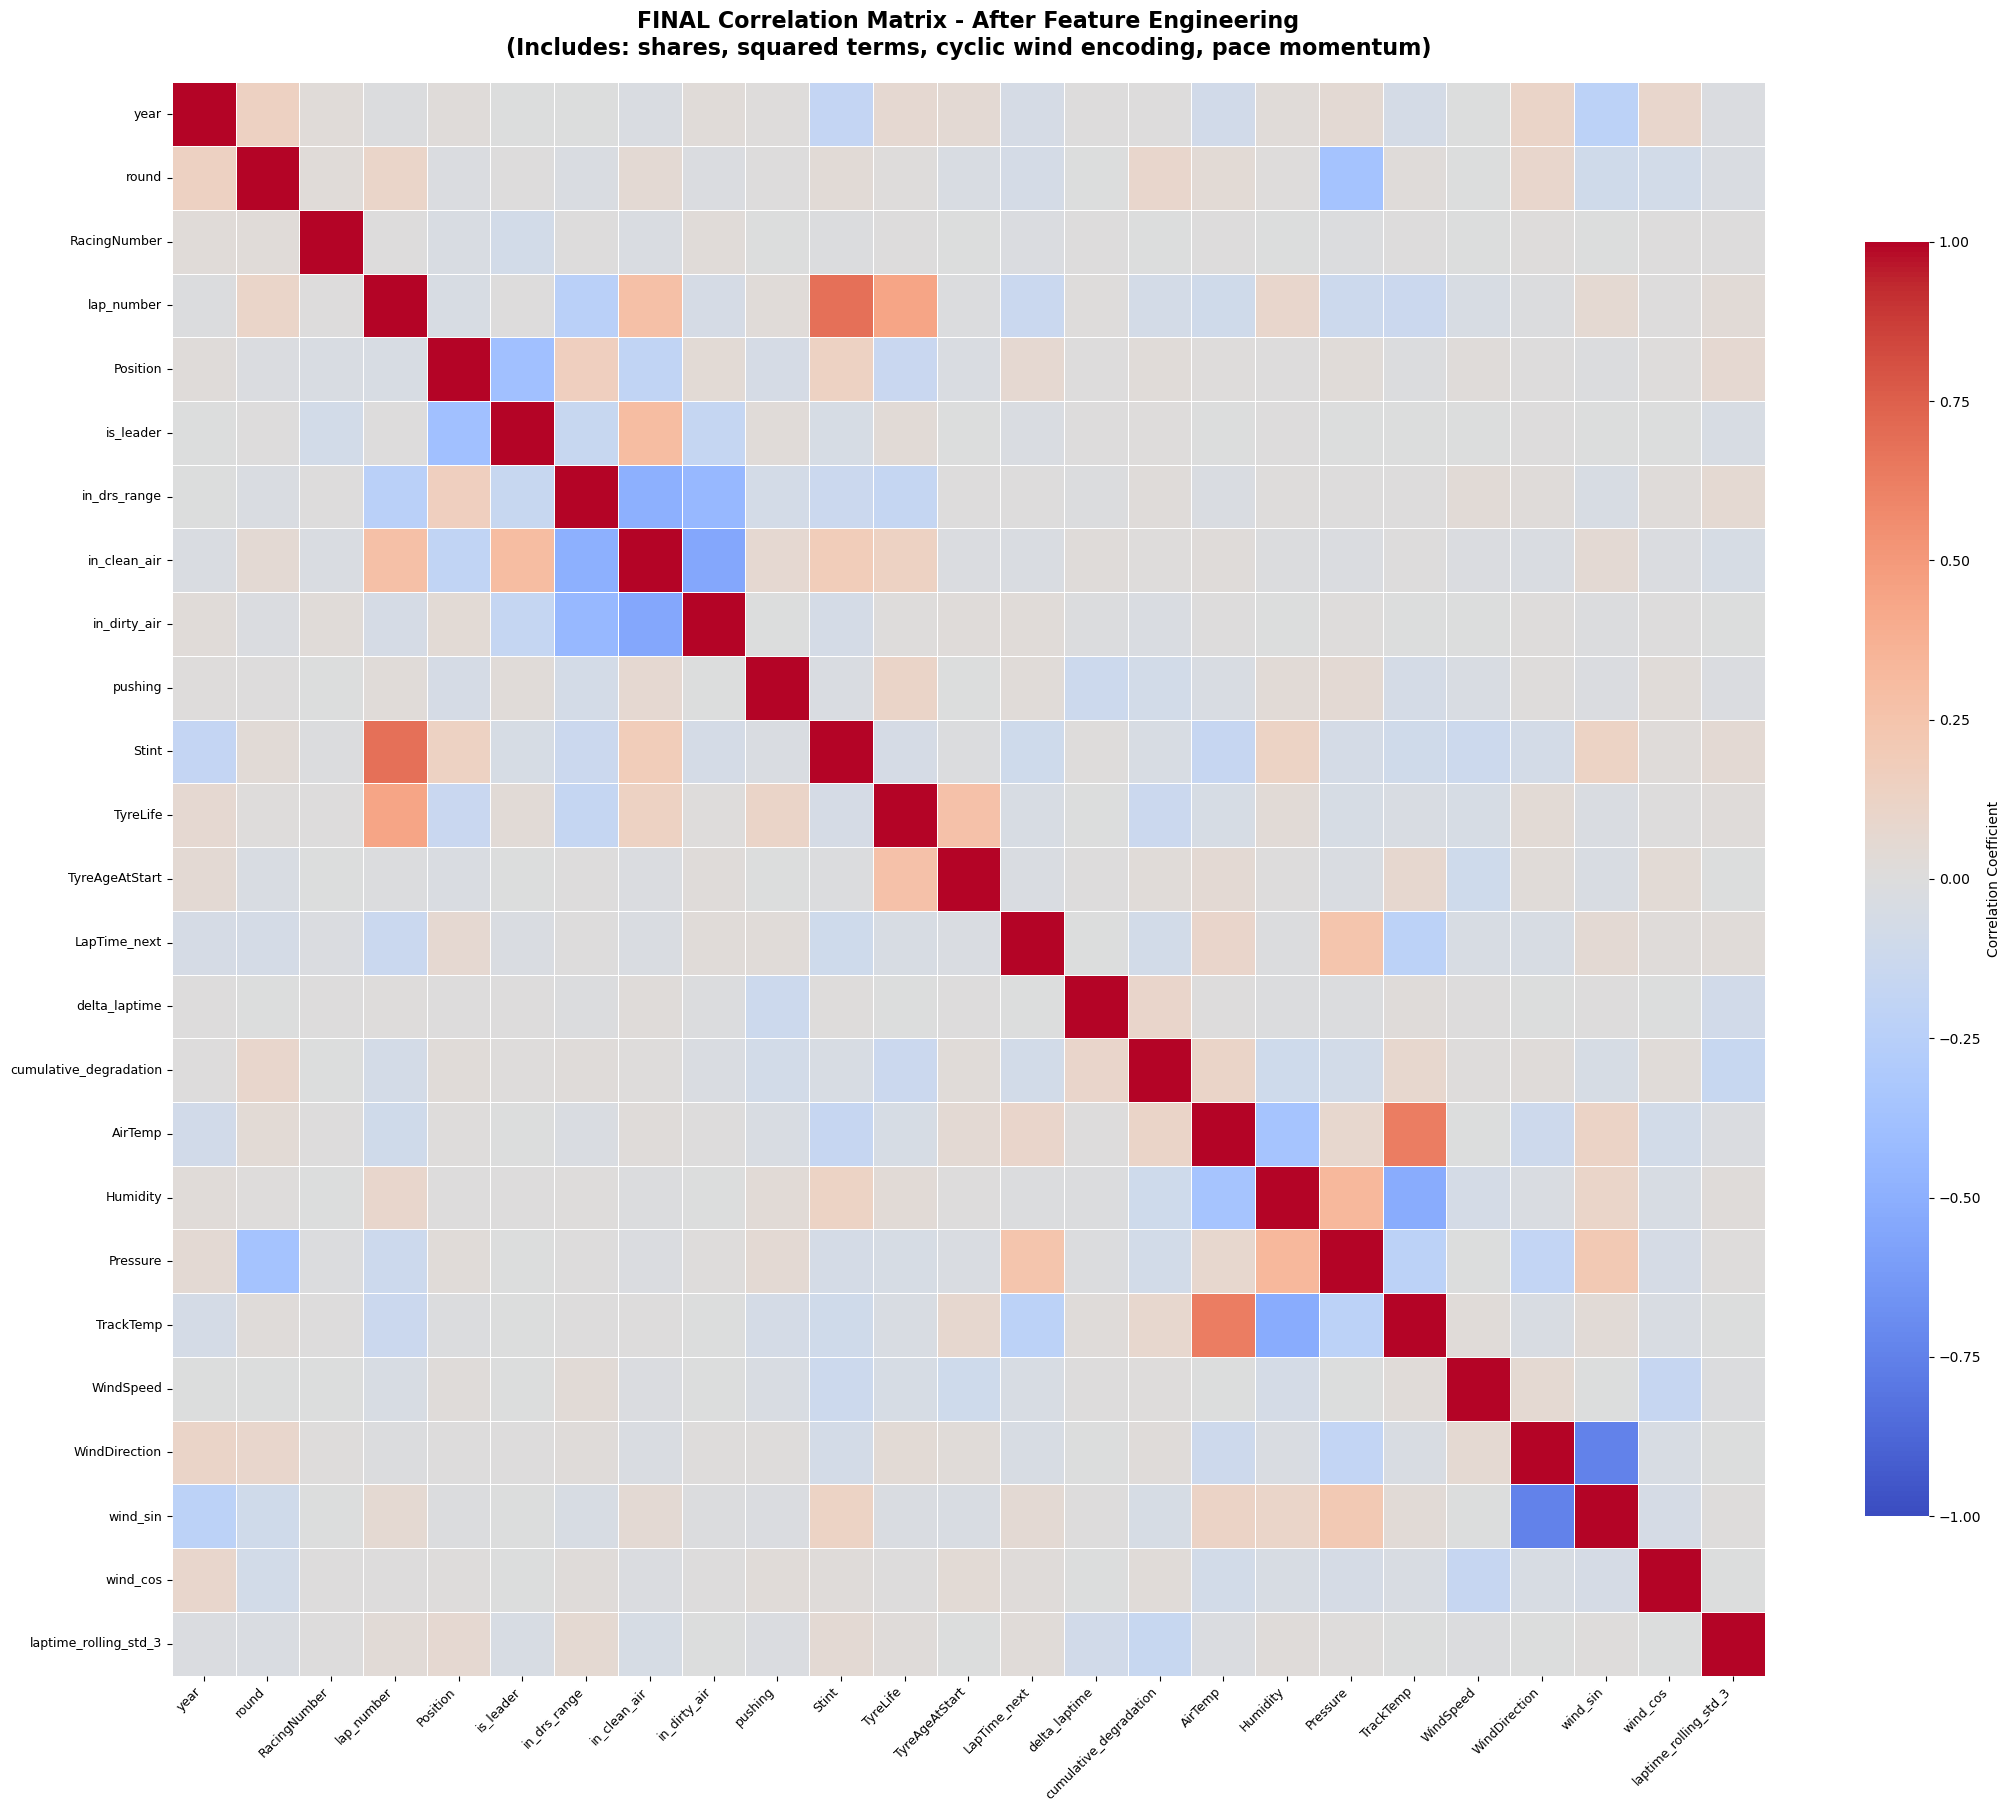


Saved: figures/Correlation_Matrix_Final.pdf
High Correlations in FINAL Dataset (|r| > 0.7)

Found 1 high correlations:

Variable 1                          Variable 2                           Correlation
------------------------------------------------------------------------------------------
wind_sin                            WindDirection                            -0.7462


In [219]:

# ──────────────────────────────────────────────────────────────────────────
# FINAL CORRELATION MATRIX - After all feature engineering
# ──────────────────────────────────────────────────────────────────────────

print(f"\n{'='*90}")
print("FINAL CORRELATION MATRIX - Post Feature Engineering")
print(f"{'='*90}")

# Select only numerical columns for correlation
numerical_cols_final = df_merged.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns for correlation ({len(numerical_cols_final)}):")
print(numerical_cols_final)

# Calculate correlation matrix
df_corr_final = df_merged[numerical_cols_final].corr()

# Create figure with appropriate size
fig, ax = plt.subplots(figsize=(22, 18))

# Create heatmap
sns.heatmap(df_corr_final, 
            annot=False,  # Set to True if you want to see correlation values
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,  
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            ax=ax)

plt.title('FINAL Correlation Matrix - After Feature Engineering\n(Includes: shares, squared terms, cyclic wind encoding, pace momentum)', 
          fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Save the plot
plt.savefig('figures/Correlation_Matrix_Final.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: figures/Correlation_Matrix_Final.pdf")

# Print high correlations (absolute value > 0.7, excluding diagonal)

print("High Correlations in FINAL Dataset (|r| > 0.7)")


# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(df_corr_final, dtype=bool))
df_corr_upper_final = df_corr_final.where(~mask)

# Find high correlations
high_corr_final = []
corr_stacked = df_corr_upper_final.stack()
for (idx, col), val in corr_stacked.items():
    if pd.notna(val) and abs(val) > 0.7:
        high_corr_final.append((idx, col, val))

# Sort by absolute correlation value
high_corr_final.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr_final:
    print(f"\nFound {len(high_corr_final)} high correlations:")
    print(f"\n{'Variable 1':<35} {'Variable 2':<35} {'Correlation':>12}")
    print("-" * 90)
    for var1, var2, corr_val in high_corr_final[:30]:  # Show top 30
        print(f"{var1:<35} {var2:<35} {corr_val:>+12.4f}")
    if len(high_corr_final) > 30:
        print(f"\n... and {len(high_corr_final) - 30} more")
else:
    print("\n✓ No correlations with |r| > 0.7 found (good for multicollinearity!)")




In [220]:
import pickle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit


In [221]:
df_merged.columns.tolist()

['year',
 'round',
 'name',
 'Grand_Prix',
 'Name',
 'RacingNumber',
 'Team',
 'lap_number',
 'Position',
 'is_leader',
 'in_drs_range',
 'in_clean_air',
 'in_dirty_air',
 'pushing',
 'Compound',
 'Stint',
 'TyreLife',
 'TyreAgeAtStart',
 'LapTime_next',
 'delta_laptime',
 'cumulative_degradation',
 'AirTemp',
 'Humidity',
 'Pressure',
 'TrackTemp',
 'WindSpeed',
 'WindDirection',
 'wind_sin',
 'wind_cos',
 'laptime_rolling_std_3']

<h1><center> Splitting the dataset  </center></h1>

For each race:
  ├─ Filter race-specific data
  ├─ One-hot encode drivers (safe - all drivers are in training)
  ├─ Train on 70% of that race's laps
  ├─ Test on 30% of that race's laps
  ├─ Extract driver effects (how much faster/slower each driver is)
  └─ Store results

Output:
  ├─ Race-specific model performance (MAE, RMSE, R²)
  ├─ Driver effects per race
  ├─ Results table
  └─ Excel export

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [223]:
# Choice 1 (most faithful to “t+1”): time-ordered within each driver-stint

# This is the closest to real forecasting. It does split a stint, which you earlier said you “ideally” avoid — but for t+1 prediction, this is actually the scientifically correct evaluation.

# For each (race, driver, stint), sort by lap and do:
# 	•	first 70% laps → train
# 	•	next 15% → val
# 	•	last 15% → test

# This guarantees:
# 	•	same race in all splits ✅
# 	•	every driver with enough laps appears in all splits ✅
# 	•	no future-to-past usage if features are causal ✅

# Choice 2 (keeps stints intact): split stints within each race and driver

# If you insist on keeping stints together, you can do:
# 	•	per race, per driver: allocate entire stints to train/val/test

# But here’s the catch I want you to face: many drivers only have 1–2 stints in a race. You often cannot put that driver into all three splits without breaking your “keep stints together” rule. So missing race-driver pairs across splits is unavoidable in that regime.

# So you have to choose which principle you want more:
# 	•	forecasting realism (t+1) → split within stints (Choice 1)
# 	•	stint purity → accept missing drivers in some splits (Choice 2)

In [224]:
import numpy as np
import pandas as pd

df = df_merged.copy()

# ─────────────────────────────────────────────────────────────
# 1) Stable identifiers
# ─────────────────────────────────────────────────────────────
df['race_id'] = (
    df['year'].astype(str) + '_' +
    df['round'].astype(str) + '_' +
    df['Grand_Prix'].astype(str)
)

group_cols = ['race_id', 'RacingNumber', 'Stint']

# Choose the best time column available inside a stint
time_col = 'LapInStint' if 'LapInStint' in df.columns else 'lap_number'

# Sort so splits are strictly chronological inside each driver-stint
df = df.sort_values(group_cols + [time_col]).reset_index(drop=True)

# ─────────────────────────────────────────────────────────────
# 2) Time-ordered 70/15/15 split inside each (race, driver, stint)
#    - For very short stints, we don't create a test slice
# ─────────────────────────────────────────────────────────────
MIN_TEST = 3   # minimum laps we want in test if we create a test segment
MIN_VAL  = 2   # minimum laps we want in val if we create a val segment
MIN_SPLIT_N = 10  # below this, keep in train (or train+val), avoid tiny test

def assign_time_split(g: pd.DataFrame) -> pd.DataFrame:
    n = len(g)

    # Too short -> keep it in train (avoids unstable tiny val/test)
    if n < MIN_SPLIT_N:
        g['split'] = 'train'
        return g

    # nominal cut points
    i1 = int(np.floor(0.70 * n))
    i2 = int(np.floor(0.85 * n))

    # enforce minimum sizes
    # ensure test has at least MIN_TEST
    i2 = min(i2, n - MIN_TEST)
    # ensure val has at least MIN_VAL
    i1 = min(i1, i2 - MIN_VAL)

    # ensure train has at least 1
    i1 = max(1, i1)
    # ensure val non-empty
    i2 = max(i1 + 1, i2)

    split = np.array(['train'] * n, dtype=object)
    split[i1:i2] = 'val'
    split[i2:] = 'test'
    g['split'] = split
    return g

df_with_split = df.groupby(group_cols, group_keys=False).apply(assign_time_split)

df_train = df_with_split[df_with_split['split'] == 'train'].drop(columns=['split']).copy()
df_val   = df_with_split[df_with_split['split'] == 'val'].drop(columns=['split']).copy()
df_test  = df_with_split[df_with_split['split'] == 'test'].drop(columns=['split']).copy()

# ─────────────────────────────────────────────────────────────
# 3) Reporting
# ─────────────────────────────────────────────────────────────
total = len(df_with_split)
print("Overall split (laps):")
print(f"  Train: {len(df_train)} ({len(df_train)/total*100:.1f}%)")
print(f"  Val:   {len(df_val)} ({len(df_val)/total*100:.1f}%)")
print(f"  Test:  {len(df_test)} ({len(df_test)/total*100:.1f}%)")

# How many groups were too short and went fully to train?
group_sizes = df_with_split.groupby(group_cols).size()
print(f"\nDriver-stint groups total: {len(group_sizes)}")
print(f"Groups with n < {MIN_SPLIT_N} put fully in train: {(group_sizes < MIN_SPLIT_N).sum()}")

# ─────────────────────────────────────────────────────────────
# 4) HARD sanity checks (these catch subtle bugs)
# ─────────────────────────────────────────────────────────────

# A) Contiguity check: splits must be contiguous blocks (train -> val -> test)
def is_noncontiguous(s):
    # if labels change more times than the number of unique labels, it's non-contiguous
    changes = (s != s.shift()).sum()
    return changes > s.nunique()

bad_contig = (df_with_split.groupby(group_cols)['split'].apply(is_noncontiguous))
print("\nAny non-contiguous split blocks within a driver-stint group?:", bad_contig.any())

# B) Time monotonicity check inside each group
bad_time = (df_with_split.groupby(group_cols)[time_col].apply(lambda s: not s.is_monotonic_increasing))
print("Any non-monotonic time ordering inside a driver-stint group?:", bad_time.any())

# C) “Future in train” check: max train time should be <= min val time, etc.
def boundary_ok(g):
    t = g.loc[g['split']=='train', time_col]
    v = g.loc[g['split']=='val', time_col]
    te = g.loc[g['split']=='test', time_col]
    ok = True
    if len(v) > 0 and len(t) > 0:
        ok &= (t.max() <= v.min())
    if len(te) > 0 and len(v) > 0:
        ok &= (v.max() <= te.min())
    if len(te) > 0 and len(t) > 0 and len(v) == 0:
        ok &= (t.max() <= te.min())
    return ok

bad_boundary = ~(df_with_split.groupby(group_cols).apply(boundary_ok))
print("Any boundary violations (train after val/test)?:", bad_boundary.any())

# ─────────────────────────────────────────────────────────────
# 5) Save
# ─────────────────────────────────────────────────────────────
df_train.to_excel('csv_output/Train_set.xlsx', index=False)
df_val.to_excel('csv_output/Validation_set.xlsx', index=False)
df_test.to_excel('csv_output/Test_set.xlsx', index=False)


Overall split (laps):
  Train: 28425 (70.4%)
  Val:   5388 (13.3%)
  Test:  6583 (16.3%)

Driver-stint groups total: 2869
Groups with n < 10 put fully in train: 1019

Any non-contiguous split blocks within a driver-stint group?: False
Any non-monotonic time ordering inside a driver-stint group?: False
Any boundary violations (train after val/test)?: False


In [225]:

print(f"\nCreating synthetic features...")
for df_split in [df_train, df_val, df_test]:
    df_split['is_new_tyre'] = (df_split['TyreAgeAtStart'] == 0).astype(int)
print(f"   is_new_tyre created (1=fresh, 0=used)")


Creating synthetic features...
   is_new_tyre created (1=fresh, 0=used)


In [226]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────────────────────────────────────────────
# CONFIG & FEATURE SETS
# ─────────────────────────────────────────────────────────────
TARGET = "LapTime_next"

NUM_FEATS_FULL = [
    "is_new_tyre",
    "TyreLife",
    "TyreAgeAtStart",
    "is_leader",
    "in_drs_range",
    "in_clean_air",
    "in_dirty_air",
    "pushing",
    "AirTemp",
    "Humidity",
    "Pressure",
    "TrackTemp",
    "WindSpeed",
    "wind_sin",
    "wind_cos",
    "delta_laptime",
    "cumulative_degradation",
    "laptime_rolling_std_3"
]

CAT_FEATS_FULL = ["RacingNumber", "Team", "Compound"]

# Define feature sets for comparison
FEATURE_SETS = {
    "Tyre+Stint": {
        "num": [
            "is_new_tyre",
            "TyreLife",
            "TyreAgeAtStart"
        ],
        "cat": ["Compound"]
    },
    
    "Tyre+Stint+Weather": {
        "num": [
            "is_new_tyre",
            "TyreLife",
            "TyreAgeAtStart",
            "AirTemp",
            "Humidity",
            "Pressure",
            "TrackTemp",
            "WindSpeed",
            "wind_sin",
            "wind_cos"
        ],
        "cat": ["Compound"]
    },
    


    "Full (No Driver/Team)": {
        "num": NUM_FEATS_FULL,
        "cat": ["Compound"]  # Only tyre compound, NO driver/team
    },
    
    # "Full (Driver+Team+Compound)": {
    #     "num": NUM_FEATS_FULL,
    #     "cat": CAT_FEATS_FULL  # Includes RacingNumber, Team, Compound
    # }
}

# Validation - only require WindDirection if needed
for name, cfg in FEATURE_SETS.items():
    all_cols = cfg["num"] + cfg["cat"] + ["year", "round", TARGET]
    # Only require WindDirection if wind features are used
    if ("wind_sin" in cfg["num"]) or ("wind_cos" in cfg["num"]):
        all_cols += ["WindDirection"]
    for c in all_cols:
        if c not in df_train.columns:
            raise ValueError(f"Missing column in df_train: {c} (needed for {name})")

# ─────────────────────────────────────────────────────────────
# FEATURE PREP
# ─────────────────────────────────────────────────────────────
def add_wind_trig(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    theta = np.deg2rad(d["WindDirection"].astype(float))
    d["wind_sin"] = np.sin(theta)
    d["wind_cos"] = np.cos(theta)
    return d

def make_Xy(df: pd.DataFrame, num_feats, cat_feats, fit_cols=None, medians=None):
    """Make X, y matrices with dynamic feature selection."""
    # Only compute wind trig if wind features are used
    need_wind = ("wind_sin" in num_feats) or ("wind_cos" in num_feats)
    d = add_wind_trig(df) if need_wind else df.copy()

    # keep only needed columns
    X_raw = d[num_feats + cat_feats].copy()
    y = d[TARGET].astype(float).copy()

    # one-hot categorical
    X = pd.get_dummies(X_raw, columns=cat_feats, drop_first=True)

    # align columns to training set if provided
    if fit_cols is not None:
        X = X.reindex(columns=fit_cols, fill_value=0)

    # impute using provided medians if available, otherwise compute from X (train only)
    if medians is None:
        medians = X.median(numeric_only=True)
    X = X.fillna(medians)

    # drop NaN target rows
    m = y.notna()
    return X.loc[m], y.loc[m], medians

# ─────────────────────────────────────────────────────────────
# TRAIN ONE MODEL PER RACE FOR A GIVEN FEATURE SET
# ─────────────────────────────────────────────────────────────
def train_race_models(df_train, num_feats, cat_feats, model_type="linear", alpha=1.0, min_samples=None):
    """
    Train race-specific models for given features.
    
    Parameters
    ----------
    df_train : pd.DataFrame
        Training data
    num_feats : list
        Numerical features
    cat_feats : list
        Categorical features
    model_type : str
        "linear" for LinearRegression or "ridge" for Ridge
    alpha : float
        Regularization strength (only for Ridge)
    min_samples : int
        Minimum samples to train a race model. If None, use 100 or 5x num features.
    """
    # Auto-calculate min_samples if not provided
    if min_samples is None:
        n_features = len(num_feats) + len(cat_feats)
        min_samples = max(100, 5 * n_features)
    
    models = {}

    for (y_, r_), d_race in df_train.groupby(["year", "round"]):
        if len(d_race) < min_samples:
            continue

        Xtr, ytr, med = make_Xy(d_race, num_feats, cat_feats)
        if len(Xtr) < min_samples:
            continue

        # Choose model type
        if model_type == "ridge":
            model = Ridge(alpha=alpha)
        else:
            model = LinearRegression()
        
        model.fit(Xtr, ytr)

        models[(int(y_), int(r_))] = {
            "model": model,
            "cols": Xtr.columns,
            "med": med,
        }

    return models

# ─────────────────────────────────────────────────────────────
# PREDICT & EVALUATE
# ─────────────────────────────────────────────────────────────
def eval_feature_set(df_test, models, num_feats, cat_feats, name="model"):
    """Evaluate a feature set on test data, with coverage reporting."""
    preds, trues = [], []
    covered_races = 0
    total_races = df_test.groupby(["year", "round"]).ngroups

    for (y_, r_), d_race in df_test.groupby(["year", "round"]):
        key = (int(y_), int(r_))
        if key not in models:
            continue

        covered_races += 1
        fit = models[key]
        X, y, _ = make_Xy(d_race, num_feats, cat_feats,
                          fit_cols=fit["cols"], medians=fit["med"])
        yhat = fit["model"].predict(X)

        preds.append(yhat)
        trues.append(y.values)

    if not preds:
        return None

    yhat = np.concatenate(preds)
    ytrue = np.concatenate(trues)

    return {
        "model": name,
        "MAE": mean_absolute_error(ytrue, yhat),
        "RMSE": np.sqrt(mean_squared_error(ytrue, yhat)),
        "R2": r2_score(ytrue, yhat),
        "n_samples": len(yhat),
        "n_races_trained": len(models),
        "n_races_covered": covered_races,
        "test_race_coverage": f"{covered_races}/{total_races}"
    }

# ─────────────────────────────────────────────────────────────
# RUN COMPARISON: SELECT BEST ALPHA PER FEATURE SET ON VAL, THEN TEST
# ─────────────────────────────────────────────────────────────
print("="*100)
print("RACE-SPECIFIC MODELS: FEATURE SET & MODEL TYPE COMPARISON")
print("Step 1: Train all configs")
print("Step 2: Select best α per feature set using VAL")
print("Step 3: Report TEST for best configs only")
print("="*100)

all_models_all = {}  # Store all trained models
best_per_feature = {}  # Track best model per feature set

# Model types to compare
MODEL_CONFIGS = {
    "Linear": {"type": "linear", "alpha": None},
    "Ridge (α=0.1)": {"type": "ridge", "alpha": 0.1},
    "Ridge (α=1.0)": {"type": "ridge", "alpha": 1.0},
    "Ridge (α=10.0)": {"type": "ridge", "alpha": 10.0},
}

# Phase 1: Train all and evaluate on VAL
print("\nPhase 1: Training and validating all configurations...\n")

for feature_name, cfg in FEATURE_SETS.items():
    print(f"\n{'─'*100}")
    print(f"Feature Set: {feature_name}")
    print(f"  Num features: {len(cfg['num'])}, Cat features: {len(cfg['cat'])}")
    print(f"{'─'*100}")
    
    best_val_mae = float('inf')
    best_model_name = None
    best_models = None
    
    for model_name, model_cfg in MODEL_CONFIGS.items():
        print(f"\n  [{model_name}]", end=" ")
        
        # Train
        kwargs = {"df_train": df_train, "num_feats": cfg["num"], 
                  "cat_feats": cfg["cat"], "model_type": model_cfg["type"]}
        if model_cfg["alpha"] is not None:
            kwargs["alpha"] = model_cfg["alpha"]
        
        models = train_race_models(**kwargs)
        
        model_key = f"{feature_name} + {model_name}"
        all_models_all[model_key] = models
        
        print(f"✓ {len(models)} races", end="")
        
        # Eval on val
        val_res = eval_feature_set(df_val, models, cfg["num"], cfg["cat"], model_key)
        if val_res:
            print(f" | Val MAE: {val_res['MAE']:.4f}s", end="")
            
            # Track best
            if val_res['MAE'] < best_val_mae:
                best_val_mae = val_res['MAE']
                best_model_name = model_name
                best_models = models
                best_cfg = cfg
    
    if best_model_name:
        best_per_feature[feature_name] = {
            "model_name": best_model_name,
            "models": best_models,
            "cfg": best_cfg,
            "val_mae": best_val_mae
        }
        print(f"\n  → Best on VAL: {best_model_name} (MAE: {best_val_mae:.4f}s)")

# Phase 2: Report TEST results for best configs only
print("\n\n" + "="*100)
print("Phase 2: TEST results for best configurations per feature set")
print("="*100 + "\n")

test_results = []

for feature_name, best_info in best_per_feature.items():
    model_name = best_info["model_name"]
    models = best_info["models"]
    cfg = best_info["cfg"]
    
    full_name = f"{feature_name} + {model_name}"
    test_res = eval_feature_set(df_test, models, cfg["num"], cfg["cat"], full_name)
    
    if test_res:
        print(f"\n{full_name}")
        print(f"  [Val]  MAE: {best_info['val_mae']:.4f}s")
        print(f"  [Test] MAE: {test_res['MAE']:.4f}s, RMSE: {test_res['RMSE']:.4f}s, R²: {test_res['R2']:.4f}")
        print(f"  Test coverage: {test_res['test_race_coverage']} ({test_res['n_samples']} samples)")
        test_results.append(test_res)

# Summary table
print("\n" + "="*100)
print("FINAL RESULTS (TEST SET)")
print("="*100 + "\n")

if test_results:
    results_df = pd.DataFrame(test_results).sort_values("MAE")
    print(results_df[["model", "MAE", "RMSE", "R2", "n_samples", "test_race_coverage"]].to_string(index=False))
    
    print(f"\n✓ BEST MODEL: {results_df.iloc[0]['model']}")
    print(f"  Test MAE: {results_df.iloc[0]['MAE']:.4f}s")
    print(f"  Test RMSE: {results_df.iloc[0]['RMSE']:.4f}s")
    print(f"  Test R²: {results_df.iloc[0]['R2']:.4f}")


# ─────────────────────────────────────────────────────────────
# DRIVER EFFECTS FOR ONE RACE
# ─────────────────────────────────────────────────────────────
def driver_effects_for_race(year, round_num, feature_set="Full (Driver+Team+Compound)", model_type="Linear", top=10):
    """
    Show driver effects for a race using specific feature set and model type.
    
    Parameters
    ----------
    year : int
        Race year
    round_num : int
        Race round
    feature_set : str
        Feature set name (e.g., "Full (Driver+Team+Compound)")
    model_type : str
        Model type (e.g., "Linear" or "Ridge (α=1.0)")
    top : int
        Number of top/bottom drivers to show
    
    Example
    -------
    driver_effects_for_race(2023, 14, 
                           feature_set="Full (Driver+Team+Compound)", 
                           model_type="Linear", 
                           top=8)
    """
    model_key = f"{feature_set} + {model_type}"
    
    if model_key not in all_models_all:
        available = [k for k in all_models_all.keys() if feature_set in k]
        print(f"Model key '{model_key}' not found.")
        print(f"Available for {feature_set}: {available}")
        return None
    
    models = all_models_all[model_key]
    key = (int(year), int(round_num))
    
    if key not in models:
        print(f"No model for ({year}, R{round_num}) in training set.")
        return None

    fit = models[key]
    coefs = pd.Series(fit["model"].coef_, index=fit["cols"])

    # driver dummies look like "RacingNumber_44" etc
    drv = coefs[coefs.index.str.startswith("RacingNumber_")].sort_values()

    if len(drv) == 0:
        print(f"\nNo driver features in {model_key} (feature set doesn't include drivers)")
        return None

    print(f"\nDriver effects: ({year}, R{round_num}) - {model_key}")
    print("→ negative = faster than reference driver\n")
    
    print("Fastest (most negative):")
    print(drv.head(top).to_string())
    print("\nSlowest (most positive):")
    print(drv.tail(top).to_string())

    return drv

# Example usage:
# driver_effects_for_race(2023, 14, feature_set="Full (Driver+Team+Compound)", model_type="Linear", top=8)



RACE-SPECIFIC MODELS: FEATURE SET & MODEL TYPE COMPARISON
Step 1: Train all configs
Step 2: Select best α per feature set using VAL
Step 3: Report TEST for best configs only

Phase 1: Training and validating all configurations...


────────────────────────────────────────────────────────────────────────────────────────────────────
Feature Set: Tyre+Stint
  Num features: 3, Cat features: 1
────────────────────────────────────────────────────────────────────────────────────────────────────

  [Linear] ✓ 64 races | Val MAE: 0.7939s
  [Ridge (α=0.1)] ✓ 64 races | Val MAE: 0.7922s
  [Ridge (α=1.0)] ✓ 64 races | Val MAE: 0.7834s
  [Ridge (α=10.0)] ✓ 64 races | Val MAE: 0.7820s
  → Best on VAL: Ridge (α=10.0) (MAE: 0.7820s)

────────────────────────────────────────────────────────────────────────────────────────────────────
Feature Set: Tyre+Stint+Weather
  Num features: 10, Cat features: 1
────────────────────────────────────────────────────────────────────────────────────────────────────

 

In [227]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────────────────────────────────────────────
# CONFIG & FEATURE SETS
# ─────────────────────────────────────────────────────────────
TARGET = "LapTime_next"

NUM_FEATS_FULL = [
    "lap_number",
    "TyreLife",
    "TyreAgeAtStart",
    "is_leader",
    "in_drs_range",
    "in_clean_air",
    "in_dirty_air",
    "pushing",
    "AirTemp",
    "Humidity",
    "Pressure",
    "TrackTemp",
    "WindSpeed",
    "wind_sin",
    "wind_cos",
    "delta_laptime",
    "cumulative_degradation",
    "laptime_rolling_std_3"
]

CAT_FEATS_FULL = ["RacingNumber", "Team", "Compound"]

# Define feature sets for comparison
FEATURE_SETS = {
    "Tyre+Stint": {
        "num": [
            "lap_number",
            "TyreLife",
            "TyreAgeAtStart"
        ],
        "cat": ["Compound"]
    },
    
    "Tyre+Stint+Weather": {
        "num": [
            "lap_number",
            "TyreLife",
            "TyreAgeAtStart",
            "AirTemp",
            "Humidity",
            "Pressure",
            "TrackTemp",
            "WindSpeed",
            "wind_sin",
            "wind_cos"
        ],
        "cat": ["Compound"]
    },
    
    "Full (No Driver/Team)": {
        "num": NUM_FEATS_FULL,
        "cat": ["Compound"]  # Only tyre compound, NO driver/team
    },
    
    "Full (Driver+Team+Compound)": {
        "num": NUM_FEATS_FULL,
        "cat": CAT_FEATS_FULL  # Includes RacingNumber, Team, Compound
    }
}

# Validation - only require WindDirection if needed
for name, cfg in FEATURE_SETS.items():
    all_cols = cfg["num"] + cfg["cat"] + ["year", "round", TARGET]
    # Only require WindDirection if wind features are used
    if ("wind_sin" in cfg["num"]) or ("wind_cos" in cfg["num"]):
        all_cols += ["WindDirection"]
    for c in all_cols:
        if c not in df_train.columns:
            raise ValueError(f"Missing column in df_train: {c} (needed for {name})")

# ─────────────────────────────────────────────────────────────
# FEATURE PREP
# ─────────────────────────────────────────────────────────────
def add_wind_trig(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    theta = np.deg2rad(d["WindDirection"].astype(float))
    d["wind_sin"] = np.sin(theta)
    d["wind_cos"] = np.cos(theta)
    return d

def make_Xy(df: pd.DataFrame, num_feats, cat_feats, fit_cols=None, medians=None):
    """Make X, y matrices with dynamic feature selection."""
    # Only compute wind trig if wind features are used
    need_wind = ("wind_sin" in num_feats) or ("wind_cos" in num_feats)
    d = add_wind_trig(df) if need_wind else df.copy()

    # keep only needed columns
    X_raw = d[num_feats + cat_feats].copy()
    y = d[TARGET].astype(float).copy()

    # one-hot categorical
    X = pd.get_dummies(X_raw, columns=cat_feats, drop_first=True)

    # align columns to training set if provided
    if fit_cols is not None:
        X = X.reindex(columns=fit_cols, fill_value=0)

    # impute using provided medians if available, otherwise compute from X (train only)
    if medians is None:
        medians = X.median(numeric_only=True)
    X = X.fillna(medians)

    # drop NaN target rows
    m = y.notna()
    return X.loc[m], y.loc[m], medians

# ─────────────────────────────────────────────────────────────
# TRAIN ONE MODEL PER RACE FOR A GIVEN FEATURE SET
# ─────────────────────────────────────────────────────────────
def train_race_models(df_train, num_feats, cat_feats, model_type="linear", alpha=1.0, min_samples=None):
    """
    Train race-specific models for given features.
    
        Parameters
        ----------
    df_train : pd.DataFrame
        Training data
    num_feats : list
        Numerical features
    cat_feats : list
        Categorical features
    model_type : str
        "linear" for LinearRegression or "ridge" for Ridge
    alpha : float
        Regularization strength (only for Ridge)
    min_samples : int
        Minimum samples to train a race model. If None, use 100 or 5x num features.
    """
    # Auto-calculate min_samples if not provided
    if min_samples is None:
        n_features = len(num_feats) + len(cat_feats)
        min_samples = max(100, 5 * n_features)
    
    models = {}

    for (y_, r_), d_race in df_train.groupby(["year", "round"]):
        if len(d_race) < min_samples:
            continue

        Xtr, ytr, med = make_Xy(d_race, num_feats, cat_feats)
        if len(Xtr) < min_samples:
            continue

        # Choose model type
        if model_type == "ridge":
            model = Ridge(alpha=alpha)
        else:
            model = LinearRegression()
        
        model.fit(Xtr, ytr)

        models[(int(y_), int(r_))] = {
            "model": model,
            "cols": Xtr.columns,
            "med": med,
        }

    return models

# ─────────────────────────────────────────────────────────────
# PREDICT & EVALUATE
# ─────────────────────────────────────────────────────────────
def eval_feature_set(df_test, models, num_feats, cat_feats, name="model"):
    """Evaluate a feature set on test data, with coverage reporting."""
    preds, trues = [], []
    covered_races = 0
    total_races = df_test.groupby(["year", "round"]).ngroups

    for (y_, r_), d_race in df_test.groupby(["year", "round"]):
        key = (int(y_), int(r_))
        if key not in models:
            continue

        covered_races += 1
        fit = models[key]
        X, y, _ = make_Xy(d_race, num_feats, cat_feats,
                          fit_cols=fit["cols"], medians=fit["med"])
        yhat = fit["model"].predict(X)

        preds.append(yhat)
        trues.append(y.values)

    if not preds:
            return None
        
    yhat = np.concatenate(preds)
    ytrue = np.concatenate(trues)

    return {
        "model": name,
        "MAE": mean_absolute_error(ytrue, yhat),
        "RMSE": np.sqrt(mean_squared_error(ytrue, yhat)),
        "R2": r2_score(ytrue, yhat),
        "n_samples": len(yhat),
        "n_races_trained": len(models),
        "n_races_covered": covered_races,
        "test_race_coverage": f"{covered_races}/{total_races}"
    }

# ─────────────────────────────────────────────────────────────
# RUN COMPARISON: LINEAR BASELINES + RIDGE ON FULL MODEL ONLY
# ─────────────────────────────────────────────────────────────
print("="*100)
print("RACE-SPECIFIC MODELS: LINEAR BASELINES + OPTIMIZED RIDGE (Full Model Only)")
print("Step 1: Train LINEAR models on ALL feature sets")
print("Step 2: Optimize RIDGE alphas on FULL model only using VAL")
print("Step 3: Report best result")
print("="*100)

all_models_all = {}  # Store all trained models
test_results = []

# ─────────────────────────────────────────────────────────────
# PHASE 1: Train LINEAR models on all feature sets
# ─────────────────────────────────────────────────────────────
print("\nPhase 1: Training LINEAR baselines...\n")

for feature_name, cfg in FEATURE_SETS.items():
    print(f"[{feature_name}]", end=" ")
    
    # Train linear
    models = train_race_models(df_train, cfg["num"], cfg["cat"], 
                               model_type="linear", alpha=None)
    
    model_key = f"{feature_name} + Linear"
    all_models_all[model_key] = models
    
    print(f"✓ {len(models)} races", end="")
    
    # Eval on test
    test_res = eval_feature_set(df_test, models, cfg["num"], cfg["cat"], model_key)
    if test_res:
        print(f" | Test MAE: {test_res['MAE']:.4f}s")
        test_results.append(test_res)

# ─────────────────────────────────────────────────────────────
# PHASE 2: Optimize Ridge ONLY on Full (Driver/Team model
# ─────────────────────────────────────────────────────────────
print(f"\n{'─'*100}")
print("Phase 2: Optimizing RIDGE alphas on Full (No Driver/Team) model only...\n")

full_cfg = FEATURE_SETS["Full (Driver+Team+Compound)"]
ridge_alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
val_results_ridge = {}

for alpha in ridge_alphas:
    print(f"[Ridge α={alpha}]", end=" ")
    
    # Train ridge
    models = train_race_models(df_train, full_cfg["num"], full_cfg["cat"], 
                               model_type="ridge", alpha=alpha)
    
    model_key = f"Full (Driver+Team+Compound) + Ridge (α={alpha})"
    all_models_all[model_key] = models
    
    print(f"✓ {len(models)} races", end="")
    
    # Eval on val
    val_res = eval_feature_set(df_val, models, full_cfg["num"], full_cfg["cat"], model_key)
    if val_res:
        val_mae = val_res['MAE']
        val_results_ridge[alpha] = val_mae
        print(f" | Val MAE: {val_mae:.4f}s")

# Select best alpha
best_alpha = min(val_results_ridge, key=val_results_ridge.get)
best_val_mae = val_results_ridge[best_alpha]

print(f"\n✓ Best α on VAL: {best_alpha} (MAE: {best_val_mae:.4f}s)")

# Train best ridge model and evaluate on test
print(f"\n{'─'*100}")
print(f"Phase 3: Testing best Ridge model...\n")

best_models = train_race_models(df_train, full_cfg["num"], full_cfg["cat"], 
                                model_type="ridge", alpha=best_alpha)

best_model_key = f"Full (Driver+Team+Compound) + Ridge (α={best_alpha})"
test_res_best = eval_feature_set(df_test, best_models, full_cfg["num"], full_cfg["cat"], best_model_key)

if test_res_best:
    print(f"\n{best_model_key}")
    print(f"  [Val]  MAE: {best_val_mae:.4f}s")
    print(f"  [Test] MAE: {test_res_best['MAE']:.4f}s, RMSE: {test_res_best['RMSE']:.4f}s, R²: {test_res_best['R2']:.4f}")
    test_results.append(test_res_best)

# ─────────────────────────────────────────────────────────────
# SUMMARY
# ─────────────────────────────────────────────────────────────
print("\n" + "="*100)
print("FINAL RESULTS (TEST SET)")
print("="*100 + "\n")

if test_results:
    results_df = pd.DataFrame(test_results).sort_values("MAE")
    print(results_df[["model", "MAE", "RMSE", "R2", "n_samples", "test_race_coverage"]].to_string(index=False))
    
    print(f"\n✓ BEST MODEL: {results_df.iloc[0]['model']}")
    print(f"  Test MAE: {results_df.iloc[0]['MAE']:.4f}s")
    print(f"  Test RMSE: {results_df.iloc[0]['RMSE']:.4f}s")
    print(f"  Test R²: {results_df.iloc[0]['R2']:.4f}")

# Store best model info for feature importance analysis
best_model_key_final = best_model_key



RACE-SPECIFIC MODELS: LINEAR BASELINES + OPTIMIZED RIDGE (Full Model Only)
Step 1: Train LINEAR models on ALL feature sets
Step 2: Optimize RIDGE alphas on FULL model only using VAL
Step 3: Report best result

Phase 1: Training LINEAR baselines...

[Tyre+Stint] ✓ 64 races | Test MAE: 0.6506s
[Tyre+Stint+Weather] ✓ 64 races | Test MAE: 0.7012s
[Full (No Driver/Team)] ✓ 64 races | Test MAE: 0.6102s
[Full (Driver+Team+Compound)] ✓ 64 races | Test MAE: 0.4281s

────────────────────────────────────────────────────────────────────────────────────────────────────
Phase 2: Optimizing RIDGE alphas on Full (No Driver/Team) model only...

[Ridge α=0.01] ✓ 64 races | Val MAE: 0.3316s
[Ridge α=0.1] ✓ 64 races | Val MAE: 0.3305s
[Ridge α=0.5] ✓ 64 races | Val MAE: 0.3281s
[Ridge α=1.0] ✓ 64 races | Val MAE: 0.3272s
[Ridge α=2.0] ✓ 64 races | Val MAE: 0.3272s
[Ridge α=5.0] ✓ 64 races | Val MAE: 0.3314s
[Ridge α=10.0] ✓ 64 races | Val MAE: 0.3402s

✓ Best α on VAL: 1.0 (MAE: 0.3272s)

────────────────

In [228]:

# ─────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE ANALYSIS (Ridge Model Coefficients)
# ─────────────────────────────────────────────────────────────
print("\n" + "="*100)
print("FEATURE IMPORTANCE: Ridge Model Coefficient Analysis")
print("="*100)

# Get best model: Full (No Driver/Team) + Ridge (α=1.0)
best_feature_set = "Full (No Driver/Team)"
best_model_type = "Ridge (α=1.0)"
best_model_key = f"{best_feature_set} + {best_model_type}"

if best_model_key in all_models_all:
    models_dict = all_models_all[best_model_key]
    
    # Aggregate coefficients across all races
    all_coefs = {}
    coef_counts = {}
    
    print(f"\nAnalyzing {len(models_dict)} race-specific models...")
    print(f"Model: {best_model_key}\n")
    
    for (year, round_num), model_info in models_dict.items():
        model = model_info["model"]
        cols = model_info["cols"]
        
        # Get coefficients
        coefs = pd.Series(model.coef_, index=cols)
        
        for feat, coef in coefs.items():
            if feat not in all_coefs:
                all_coefs[feat] = 0
                coef_counts[feat] = 0
            all_coefs[feat] += coef
            coef_counts[feat] += 1
    
    # Average coefficients across races
    avg_coefs = pd.Series({feat: all_coefs[feat] / coef_counts[feat] 
                           for feat in all_coefs})
    
    # Absolute value for importance ranking
    importance = avg_coefs.abs().sort_values(ascending=False)
    
    print("TOP 15 MOST IMPORTANT FEATURES (by avg |coefficient|):\n")
    print(f"{'Rank':<5} {'Feature':<35} {'Avg Coef':<12} {'Importance'}")
    print("─" * 100)
    
    for i, (feat, imp) in enumerate(importance.head(15).items(), 1):
        avg_val = avg_coefs[feat]
        direction = "↓ slower" if avg_val > 0 else "↑ faster"
        print(f"{i:<5} {feat:<35} {avg_val:>11.6f}  {imp:>11.6f}  {direction}")
    
    # Summary statistics
    print("\n" + "─"*100)
    print("\nCoefficient Statistics:")
    print(f"  Mean absolute coefficient:  {importance.mean():.6f}")
    print(f"  Median absolute coefficient: {importance.median():.6f}")
    print(f"  Std of coefficients:        {avg_coefs.std():.6f}")
    print(f"  Max coefficient (positive):  {avg_coefs.max():.6f} ({avg_coefs.idxmax()})")
    print(f"  Min coefficient (negative):  {avg_coefs.min():.6f} ({avg_coefs.idxmin()})")
    
    # Feature groups
    print("\n" + "="*100)
    print("FEATURE GROUPS: Average Contribution")
    print("="*100 + "\n")
    
    feature_groups = {
        "Tyre State": ["lap_number", "TyreLife", "TyreAgeAtStart"],
        "Race Dynamics": ["is_leader", "in_drs_range", "in_clean_air", "in_dirty_air", "pushing"],
        "Weather": ["AirTemp", "Humidity", "Pressure", "TrackTemp", "WindSpeed", "wind_sin", "wind_cos"],
        "Compound": [col for col in avg_coefs.index if "Compound_" in col]
    }
    
    group_importance = {}
    for group_name, features in feature_groups.items():
        group_feats = [f for f in features if f in avg_coefs.index]
        if group_feats:
            avg_importance = avg_coefs[group_feats].abs().mean()
            group_importance[group_name] = avg_importance
    
    group_df = pd.DataFrame(list(group_importance.items()), 
                            columns=["Feature Group", "Avg |Coefficient|"]).sort_values("Avg |Coefficient|", ascending=False)
    
    print(group_df.to_string(index=False))
    
    print("\n" + "="*100)
    print("INTERPRETATION:")
    print("="*100)
    print("""
Positive coefficient  → Feature increases lap time (makes it slower)
Negative coefficient  → Feature decreases lap time (makes it faster)

Example:
  lap_number: +0.002  → As stint progresses, lap times get slower (tire deg)
  is_leader: -0.100   → Being leader (clean air) makes you ~0.1s faster
  Compound_HARD: -0.05 → Hard tires are ~0.05s faster than reference tyre
""")
    
    # Show which features to drop (minimal importance)
    low_importance = importance[importance < importance.quantile(0.25)]
    if len(low_importance) > 0:
        print(f"\nLOW IMPORTANCE FEATURES (bottom 25%, could consider dropping):")
        print("─" * 100)
        for feat, imp in low_importance.items():
            print(f"  • {feat:<35} ({imp:.6f})")

else:
    print(f"Model not found: {best_model_key}")





FEATURE IMPORTANCE: Ridge Model Coefficient Analysis
Model not found: Full (No Driver/Team) + Ridge (α=1.0)
